### Study design
  - two body sites: feces, cecum
  - male and female mice
  - TCDD vs oil (=control), n=9 mice per group
  - 12 weeks time course experiment

### Meeting notes 2025-01-31
  - at timepoint d0, mice were in the very same moment fed with TCDD-oil for the very first time while collecting feces when holding the mice in the technicians hand, i.e. no chance for TCDD to already have impacted the gut microbiome
  - mice were ordered 3 weeks prior to d0 and were acclimatized to IUF's mouse facility
  - strong differences in microbiome between feces and caecum is known. As mice digest most of their plant diet in their caecum, bacterial diversity is expected to be highest there
  - is it possible, that female mice microbiota are especially similar too each other because of synchronizes periods?

In [9]:
# toggle between "notebook" and "inline", if graphs are not directly displayes
%matplotlib  inline

In [45]:
%load_ext autoreload
%autoreload 2

from ggmap.workflow import *
from ggmap.analyses import *

from statannot import add_stat_annotation
from statannotations.Annotator import Annotator
from sklearn.manifold import MDS

import calour as ca
ca.set_log_level(40)

# use the following two information to create according github repo and project directory on lummerland
PROJECT_PI = 'Esser'
PROJECT_NAME = 'TCDD_2'

def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
    
#COLORS = {'f': '#eeccff',
#          'm': '#ccdcff',
#          'control': '#d7f4db',
#          'TCDD': '#f4d7d7',
#          'feces': '#f8ebd3',
#          'cecal': '#dfbaab',
#          '0w': '#f1f1f1',
#          '12w': '#d3d3d3'
#         }
#COLORS_DARK = {k: lighten_color(v, 4) for k, v in COLORS.items()}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# this object will hold many of the preprocessing data
# be careful to re-set it as you will have to re-do multiple steps to recreate these infos
prj_data = dict()

prj_data = init_project(pi=PROJECT_PI, name=PROJECT_NAME, prj_data=prj_data, force=True)

  /vol/jlab/MicrobiomeAnalyses/Projects/Esser_TCDD_2/tmp_workdir_sjanssen/no_backup


# Process data
## load metadata

In [6]:
# load sample metadata and prep metadata from Qiita
prj_data['metadata'] = pd.read_csv('FromQiita/15900_20250220-050919.txt', 
            sep="\t", na_values=['not applicable', 'not collected', 'missing'], dtype=str, index_col=0).merge(
    pd.concat([pd.read_csv(fp_prep, 
                           sep="\t", na_values=['not applicable', 'not collected', 'missing'], dtype=str, index_col=0)
               for fp_prep in ['FromQiita/15900_prep_18069_20250218-010241.txt', 'FromQiita/15900_prep_18071_20250218-011046.txt']], axis=0),
    left_index=True, right_index=True, how='left')

# convert data types
for col in ["body_weight_at_sacrifice", "dna_concentration_by_feces_weight", "feces_weight", "body_weight_at_sacrifice", "elevation", "fat", "host_weight", "latitude", "host_age", "liver_weight", "longitude"]:
    prj_data['metadata'][col] = prj_data['metadata'][col].astype(float)

for col in ["birth_date", "collection_date", "collection_timestamp"]:
    prj_data['metadata'][col] = prj_data['metadata'][col].apply(pd.to_datetime)

for col in ["facs_presorted_bacteria"]:
    prj_data['metadata'][col] = prj_data['metadata'][col].apply(lambda x: True if x == 'TRUE' else False)

#for col in ['host_subject_id', 'host_cage_id']:
#    prj_data['metadata'][col] = prj_data['metadata'][col].astype(int)

# rename header and cells to match manuscript
prj_data['metadata']['host_body_site'] = prj_data['metadata']['host_body_site'].apply(
    lambda x: {'UBERON:colon': 'feces', 
               'UBERON:caecum': 'cecum'}.get(x, x))
prj_data['metadata'] = prj_data['metadata'].rename(columns={'host_body_site': 'bodysite'})
prj_data['metadata']['timepoint'] = prj_data['metadata']['timepoint'].apply(lambda x: {'0w': 'd0'}.get(x, x))

## Rarefaction + Diversity + Emperor

You have to run the below function at least twice: 
 - First, to get rarefaction curves, which you will use to determine a rarefaction depth for samples to compute diversity values
 - Second, alpha- beta- and emperor computation need ONE specific `rarefaction_depth` value, which you have determined in step 1

### Feces

Reduced to 70 samples (feature-table had 70, metadata had 74 samples)
Information: 1210 of 1930 features have been removed from your Deblur table, since they have less than 10 read counts in all samples combined.
Using existing results from '.anacache/d8283412da44fa8c161ee5c107419d57.taxRDP'. 
Using existing results from '.anacache/96fa3455ba3741067f8c8ae8f16bc6da.taxRDP'. 
In total, 0 reads (0.000000%) have been filtered for chloroplast/mitochondia removal.
Using existing results from '.anacache/845ea62c95c7a058b7c2c8910ff05e0e.rare'. 
Using existing results from '.anacache/988143623a38bf460da224ec37e11e4f.rarefy'. 
Using existing results from '.anacache/23ed5ec0ec66024adc62147f20a0e52b.adiv'. 
Using existing results from '.anacache/eed9327c53acb171637bb2d626be02ac.bdiv'. 
Using existing results from '.anacache/474929c9a7fae42eab69bc45509fc2e8.emperor'. 
Your final feature table is composed of 70 samples and 720 features.


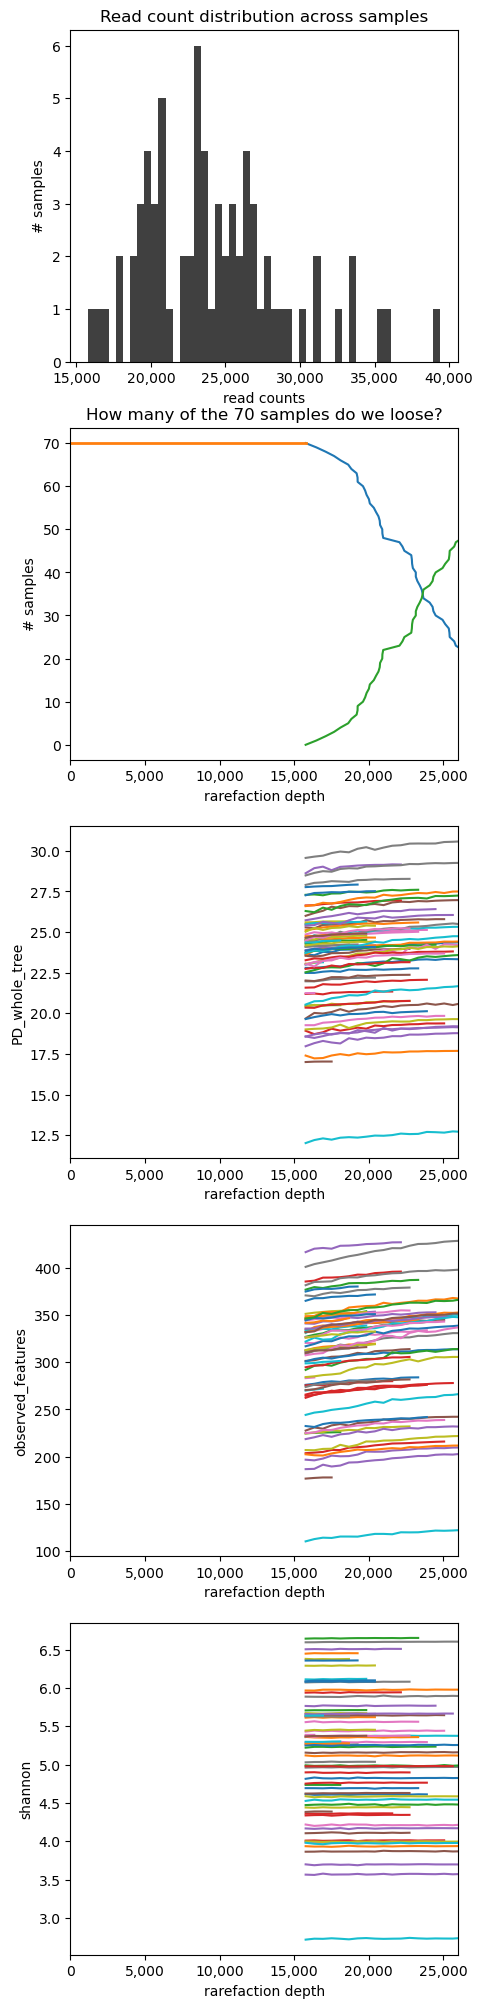

In [10]:
idx_control_samples = set(prj_data['metadata'][pd.isnull(prj_data['metadata']['host_subject_id'])].index)
res_feces = process_study(
    metadata=prj_data['metadata'][(prj_data['metadata']['bodysite'] == 'feces') & 
                                  (prj_data['metadata']['facs_presorted_bacteria'] == False)],
    control_samples=idx_control_samples,
    fp_deblur_biom=biom2pandas('FromQiita/214725_reference-hit.biom'),
    fp_insertiontree='FromQiita/214725_insertion_tree.relabelled.tre',
    rarefaction_depth=15000, rarefaction_min_depth=5000,
    fp_taxonomy_trained_classifier_gg138_chloroMitoRemoval='/vol/jlab/MicrobiomeAnalyses/References/Q2-Naive_Bayes_classifiers/gg-13-8-99-nb-classifier_2022.11.qza',
    fp_taxonomy_trained_classifier='/homes/sjanssen/MicrobiomeAnalyses/References/Q2-Naive_Bayes_classifiers/2024.09.backbone.full-length.nb.sklearn-1.4.2.qza',
    tree_insert=TreeNode.read('FromQiita/214725_insertion_tree.relabelled.tre', format='newick'),
    is_v4_region=True,
    emperor_fp=prj_data['paths']['Generated/Emperor'],
    emperor_infix='_deblur_feces_',
    dry=False,
    use_grid=True,
    fix_zero_len_branches=False, # since this has already been corrected via the project_sepp call
    ignore_noplantmito=True,
)

### Cecum

Reduced to 36 samples (feature-table had 44, metadata had 36 samples)
Information: 290 of 825 features have been removed from your Deblur table, since they have less than 10 read counts in all samples combined.
Using existing results from '.anacache/8b26abbe7eec2f626b9494648cbf04d3.taxRDP'. 
Using existing results from '.anacache/52cf1af1be45a6640e923854d502ee3a.taxRDP'. 
In total, 0 reads (0.000000%) have been filtered for chloroplast/mitochondia removal.
Using existing results from '.anacache/c1a8ca4e250534dffb262195e9129675.rare'. 
Using existing results from '.anacache/fedf792c37f91d8de10f57d69779f0aa.rarefy'. 
Using existing results from '.anacache/847bc1295c049ff9fb933407ce861658.adiv'. 
Using existing results from '.anacache/02e231bc4c7c0f8d9c9be4a080f9d091.bdiv'. 
Using existing results from '.anacache/021e032c294134f9692921d4d8f40931.emperor'. 
Your final feature table is composed of 36 samples and 535 features.


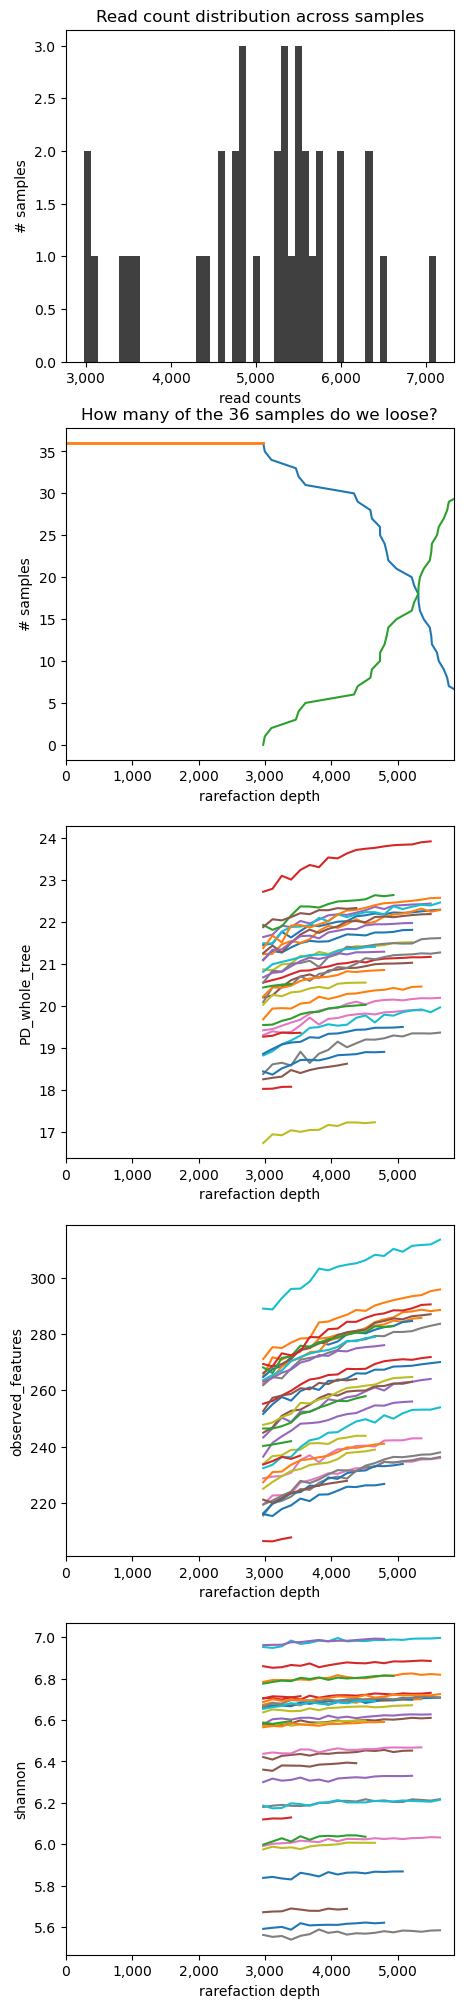

In [11]:
idx_control_samples = set(prj_data['metadata'][pd.isnull(prj_data['metadata']['host_subject_id'])].index)
res_cecal = process_study(
    metadata=prj_data['metadata'][(prj_data['metadata']['bodysite'] == 'cecum') & 
                                  (prj_data['metadata']['flowcells'] == 'M05620:119:000000000-DLGNK') & # assert not to use the first failed sequencing run!
                                  (prj_data['metadata']['facs_presorted_bacteria'] == False)],
    control_samples=idx_control_samples,
    fp_deblur_biom='FromQiita/214707_reference-hit.biom',
    fp_insertiontree='FromQiita/214707_insertion_tree.relabelled.tre',
    rarefaction_depth=2500,
    fp_taxonomy_trained_classifier_gg138_chloroMitoRemoval='/vol/jlab/MicrobiomeAnalyses/References/Q2-Naive_Bayes_classifiers/gg-13-8-99-nb-classifier_2022.11.qza',
    fp_taxonomy_trained_classifier='/homes/sjanssen/MicrobiomeAnalyses/References/Q2-Naive_Bayes_classifiers/2024.09.backbone.full-length.nb.sklearn-1.4.2.qza',
    tree_insert=TreeNode.read('FromQiita/214707_insertion_tree.relabelled.tre', format='newick'),
    is_v4_region=True,
    emperor_fp=prj_data['paths']['Generated/Emperor'],
    emperor_infix='_deblur_cecal_',
    dry=False,
    use_grid=True,
    fix_zero_len_branches=False, # since this has already been corrected via the project_sepp call
    ignore_noplantmito=True,
)

### Cecum, pre-sorted bacterial cells

Reduced to 6 samples (feature-table had 44, metadata had 6 samples)
Information: 527 of 825 features have been removed from your Deblur table, since they have less than 1 read counts in all samples combined.
Using existing results from '.anacache/a98626e2cf2af625d0016b37dda65a13.taxRDP'. 
Using existing results from '.anacache/c0a92fc2ea7fbc3d1d226fbc5227a229.taxRDP'. 
In total, 0 reads (0.000000%) have been filtered for chloroplast/mitochondia removal.
Using existing results from '.anacache/c10cc85750f4ffbced5176083e715c2c.rare'. 
Using existing results from '.anacache/7b4cb2ea4e2552025be41f0ac2269d6d.rarefy'. 
Using existing results from '.anacache/d6f0f84dd45293f38963f4663efbfa27.adiv'. 
Using existing results from '.anacache/9924bee3685edcea478bea87f35806c2.bdiv'. 
Using existing results from '.anacache/d514e1f23b0037e5125b28ea0d47b3ec.emperor'. 
Your final feature table is composed of 6 samples and 223 features.


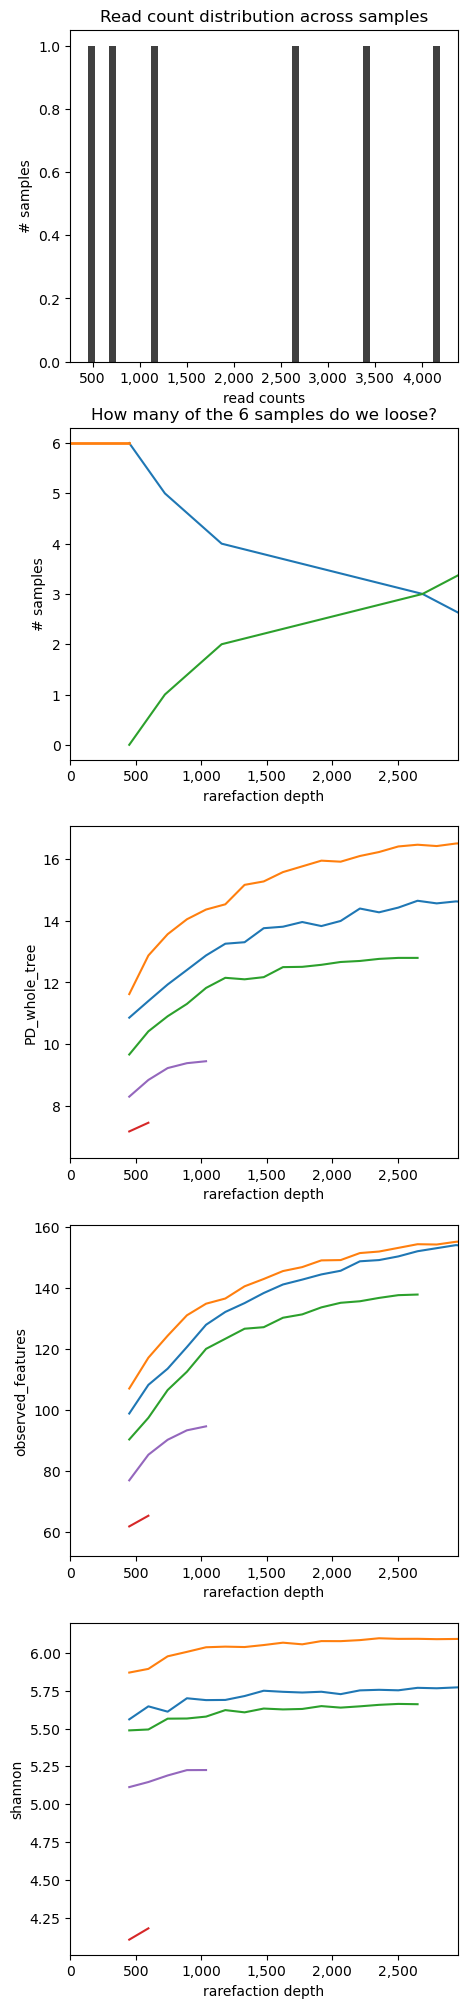

In [12]:
res_flow = process_study(
    metadata=prj_data['metadata'][(prj_data['metadata']['bodysite'] == 'cecum') & 
                                  (prj_data['metadata']['flowcells'] == 'M05620:119:000000000-DLGNK') & # assert not to use the first failed sequencing run!
                                  (prj_data['metadata']['facs_presorted_bacteria'] == True)],
    control_samples=set(),
    fp_deblur_biom='FromQiita/214707_reference-hit.biom',
    fp_insertiontree='FromQiita/214707_insertion_tree.relabelled.tre',
    rarefaction_depth=420, rarefaction_min_depth=100, # does not make sense as we expect to have absolute reads - but otherwise this function won't properly run through
    fp_taxonomy_trained_classifier_gg138_chloroMitoRemoval='/vol/jlab/MicrobiomeAnalyses/References/Q2-Naive_Bayes_classifiers/gg-13-8-99-nb-classifier_2022.11.qza',
    fp_taxonomy_trained_classifier='/homes/sjanssen/MicrobiomeAnalyses/References/Q2-Naive_Bayes_classifiers/2024.09.backbone.full-length.nb.sklearn-1.4.2.qza',
    tree_insert=TreeNode.read('FromQiita/214707_insertion_tree.relabelled.tre', format='newick'),
    is_v4_region=True,
    emperor_fp=prj_data['paths']['Generated/Emperor'],
    emperor_infix='_cellsorted_',
    dry=False,
    use_grid=True,
    fix_zero_len_branches=False, # since this has already been corrected via the project_sepp call
    ignore_noplantmito=True,
    deblur_remove_features_lessthanXreads=1,
    emperor_skip_tsne_umap=True,
)

# Study Design

cecum False
cecum True
feces False


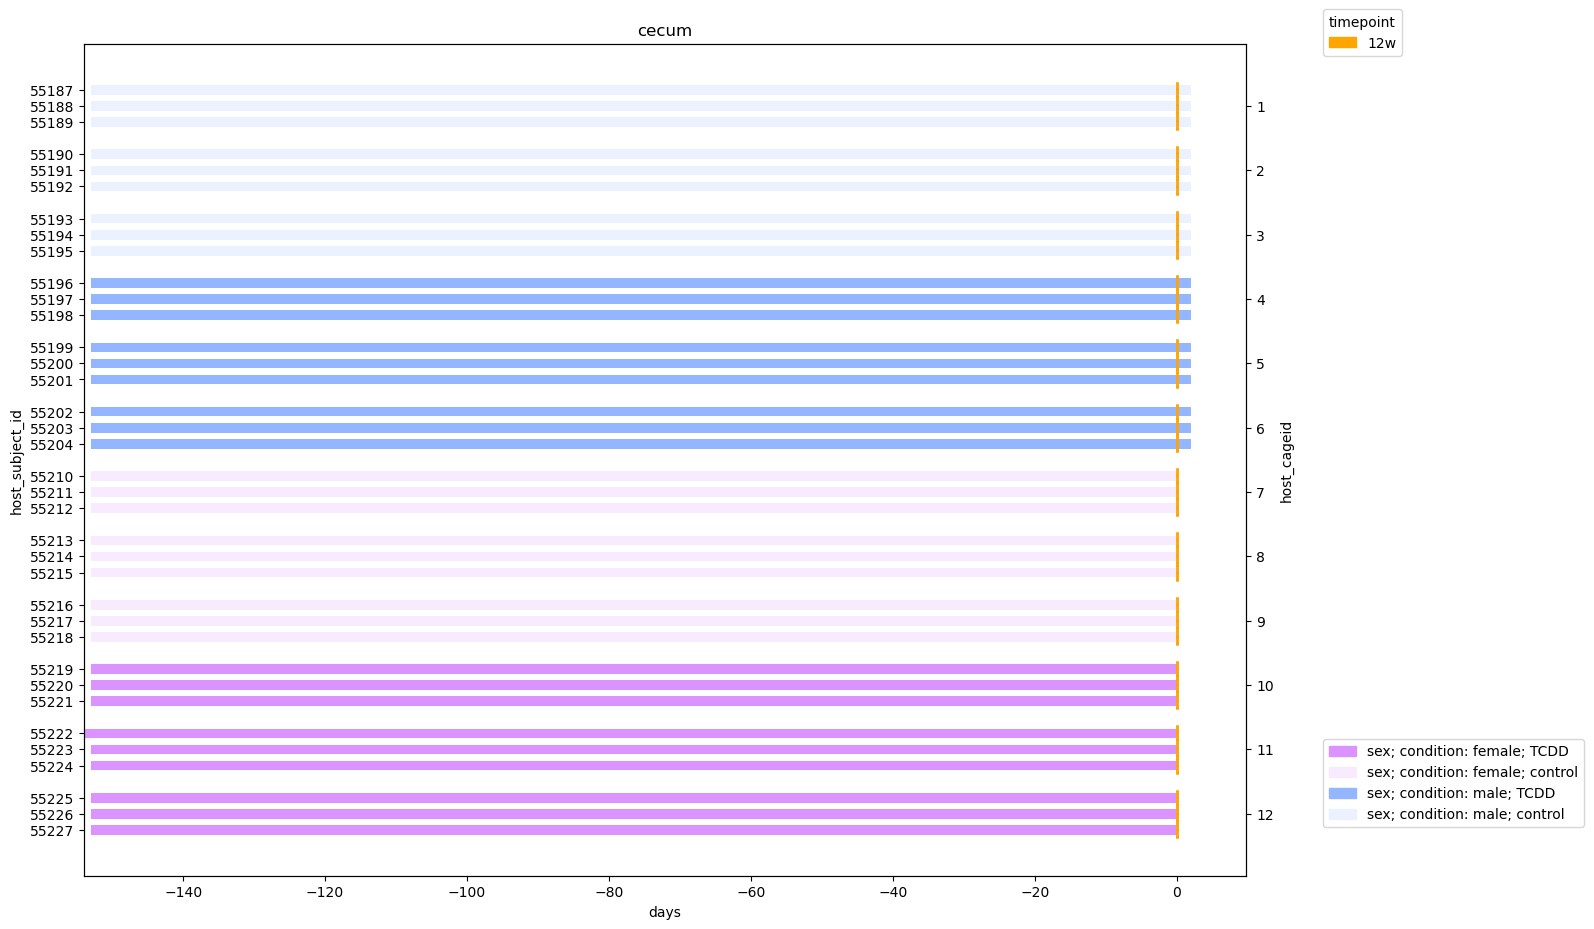

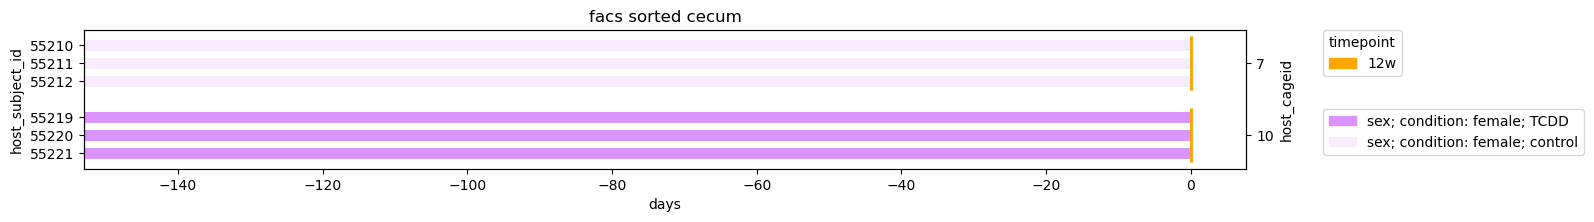

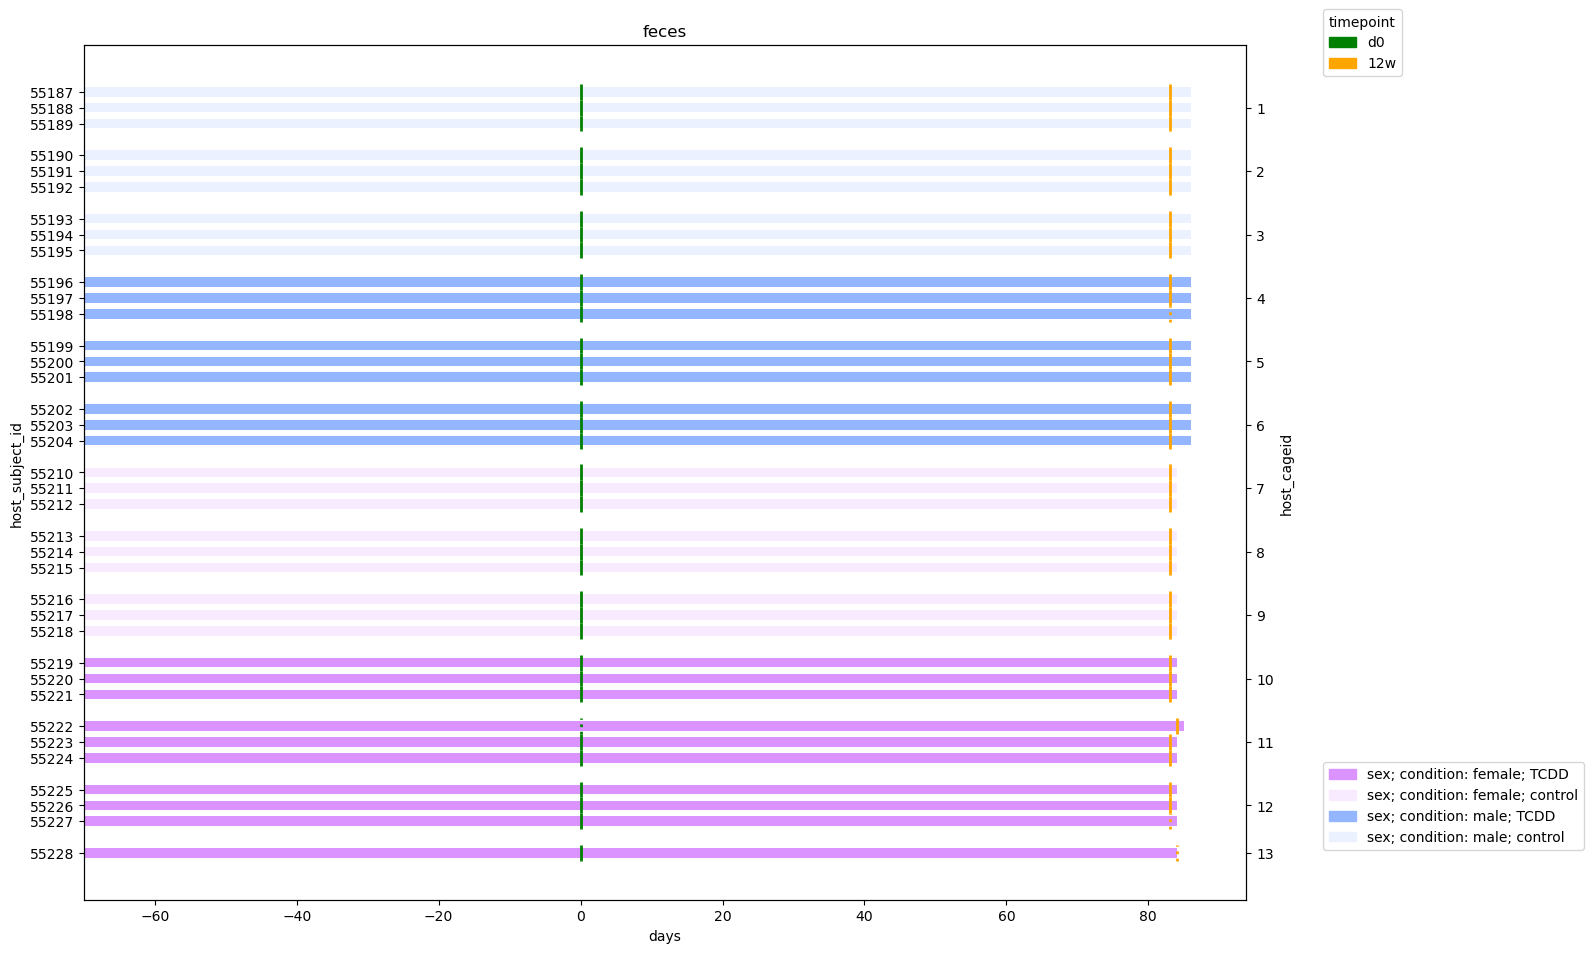

In [13]:
color_male = '#ccdcff'
color_female = '#eeccff'

for (bodysite, cellsorted), g in prj_data['metadata'].groupby(['bodysite', 'facs_presorted_bacteria']):
    if cellsorted is True:
        continue
    print(bodysite, cellsorted)
    gmeta = g.copy()
    for col in ['host_subject_id', 'host_cageid']:
        gmeta[col] = gmeta[col].astype(int)
    
    gmeta['sex; condition'] = gmeta.apply(lambda row: '; '.join([row['sex'], row['condition']]), axis=1)

    chart, col, info = ganttChart(
        gmeta.sort_values(by=['sex', 'condition', 'host_cageid', 'host_subject_id'], ascending=[True, True, False, False]),
        col_birth='birth_date',  # metadata column that flags the start of the timeline, must be some parsable dates like 2022-10-09
        col_entities='host_subject_id',  # metadata column that contains name of the person/animal which has been sampled over time, i.e. to know which samples belong to the same line
        col_events='collection_date', # metadata column that indicate the exact date when samples have been collected
        col_events_title='timepoint', # you might want to provide a metadata column to give sampling events more speaking names
        col_entity_groups='host_cageid',
        col_entity_colors='sex; condition',
        align_to_event_title='d0' if bodysite == 'feces' else '12w', # by default, lines are drawn by actual date. However, often it makes sense to align them to the first timepoint of an intervention
        counts={('feces', False): res_feces, ('cecum', False): res_cecal, ('cecum', True): res_flow}.get((bodysite, cellsorted))['rarefaction']['results'],
        event_line_width=2,
        colors_events={'d0': 'green', '12w': 'orange'},
        colors_entities={'male; control': lighten_color(color_male, 0.4),
                         'female; control': lighten_color(color_female, 0.4),
                         'male; TCDD': lighten_color(color_male, 2.1),
                         'female; TCDD': lighten_color(color_female, 2.1)}
        )
    chart.get_axes()[0].set_title('%s%s' % ('facs sorted ' if cellsorted else '', bodysite))
    #break

# Figures

In [14]:
ORDERS = {'sex': ['male', 'female'],
          'condition': ['control', 'TCDD'],
          'timepoint': ['d0', '12w'],
          'bodysite': ['feces', 'cecum']}

COLORS_CONDITIONS = {'control': sns.color_palette()[1], 
                     'TCDD': sns.color_palette()[0]}
COLORS_SEX = {'female': '#ef7d72',
              'male': '#79c8ca'}

RANK = 'Family'

if 'Generated/Figures' not in prj_data['paths']:
    prj_data['paths']['Generated/Figures'] = os.path.dirname(prj_data['paths']['Figures']) + '/Generated/Figures'
    
def _savefig(fig, name):
    os.makedirs(prj_data['paths']['Generated/Figures']+'/SVG', exist_ok=True)
    os.makedirs(prj_data['paths']['Generated/Figures']+'/PNG', exist_ok=True)

    #print(prj_data['paths']['Generated/Figures']+'/PNG')
    
    fig.savefig(prj_data['paths']['Generated/Figures']+'/SVG/%s.svg' % name, bbox_inches='tight')
    fig.savefig(prj_data['paths']['Generated/Figures']+'/PNG/%s.png' % name, bbox_inches='tight')

In [15]:
colors_genera = dict()
colors_phyla = dict()

## Figure 4

### Panel A

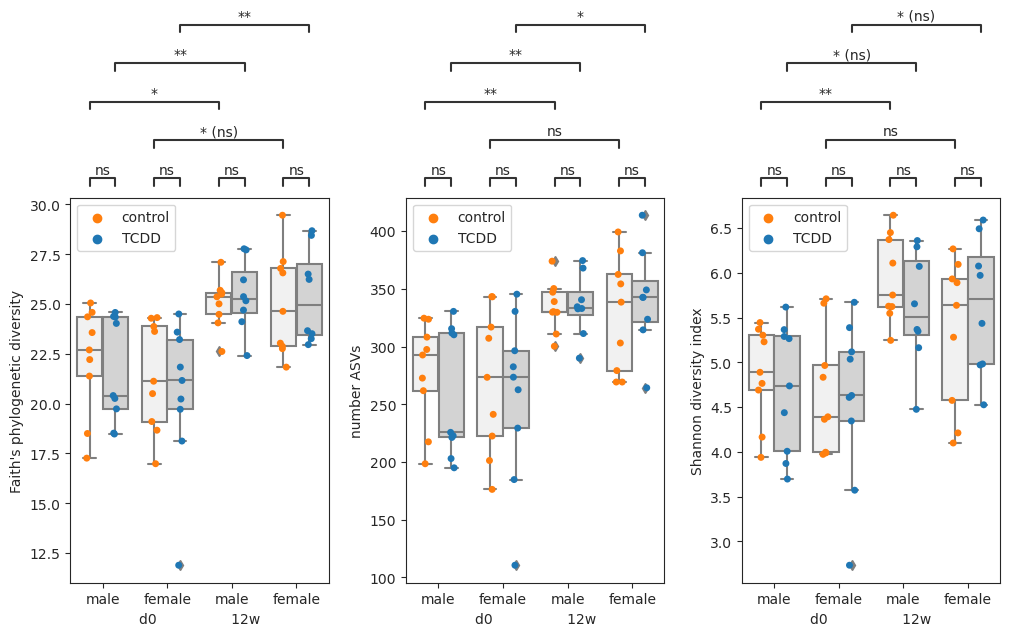

In [18]:
def plot_alpha(res, meta, bodysite):
    sns.set_style('ticks')
    fig, axes = plt.subplots(1,3, figsize=(3*4, 5))
    plt.subplots_adjust(wspace=0.3)

    alpha_data = res['alpha_diversity']['results'].stack().reset_index()
    alpha_data.columns = ['sample_name', 'metric', 'distance']
    alpha_data = alpha_data.merge(meta, left_on='sample_name', right_index=True)
    alpha_data['tp_sex'] = alpha_data['timepoint'] + ":" + alpha_data['sex']
    
    for ax, (metric, plot_data) in zip(axes, alpha_data[alpha_data['bodysite'] == bodysite].sort_values(by=['sex', 'metric'], ascending=[False, True]).groupby('metric', sort=False)):
        order_x = ['%s:%s' % (timepoint, sex) for timepoint in ORDERS['timepoint'] for sex in ORDERS['sex']]
        cmps = [
            (('d0:%s' % sex, cond), ('12w:%s' % sex, cond)) for sex in ['male', 'female'] for cond in ORDERS['condition']
            ] + [
            (('%s:%s' % (tp, sex), 'control'), ('%s:%s' % (tp, sex), 'TCDD')) for sex in ['male', 'female'] for tp in ORDERS['timepoint']
            ]
        if bodysite != 'feces':
            cmps = [(('12w:%s' % sex, 'control'), ('12w:%s' % sex, 'TCDD')) for sex in ORDERS['sex']]
            order_x = [x for x in order_x if 'd0' not in x]
        
        sns.boxplot(data=plot_data, y='distance', x='tp_sex', hue='condition', color='lightgray', ax=ax, hue_order=ORDERS['condition'], order=order_x)
        sns.stripplot(data=plot_data, y='distance', x='tp_sex', hue='condition', dodge=True, ax=ax, hue_order=ORDERS['condition'], order=order_x, palette=COLORS_CONDITIONS)
        
        annotator = Annotator(ax, cmps, data=plot_data, y='distance', x='tp_sex', hue='condition', hue_order=ORDERS['condition'], order=order_x)
        annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="fdr_bh", correction_format="default", verbose=False)
        annotator.apply_and_annotate()
        
        ax.set_ylabel({'PD_whole_tree': 'Faith\'s phylogenetic diversity',
                       'observed_features': 'number ASVs',
                       'shannon': 'Shannon diversity index'}.get(metric, metric))

        ax.set_xticklabels([x.get_text().split(':')[-1] for x in ax.get_xticklabels()])
        ax.legend().set_title("")
        if bodysite == 'feces':
            ax.set_xlabel('d0                 12w')
        else:
            ax.set_xlabel("")

        (legend_patches, legend_labels) = ax.get_legend_handles_labels()
        ax.legend(handles=legend_patches[-2:], labels=legend_labels[-2:])
    #fig.suptitle('Alpha diversity')
    
    return fig

fig = plot_alpha(res_feces, prj_data['metadata'], 'feces')
_savefig(fig, 'fig4_panelA')

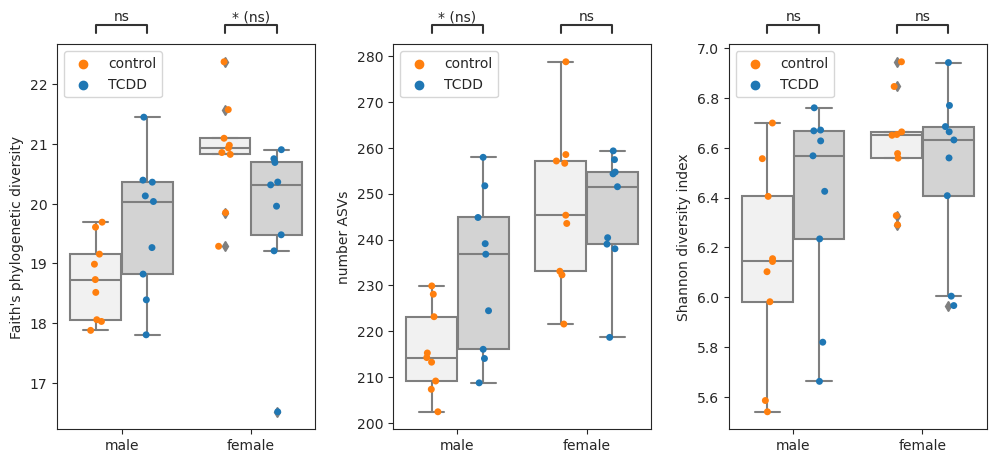

In [19]:
fig = plot_alpha(res_cecal, prj_data['metadata'], 'cecum')
_savefig(fig, 'fig4_panelB')

### Panels E+F

42 taxa left after collapsing to Family.
70 samples left with metadata and counts.
37 taxa left after filtering low abundant.
raw counts: 70
raw meta: 172
meta with counts: 8 samples x 5 fields
counts with meta: 8


/tmp/ipykernel_1103567/1639044935.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  p[0].get_axes()[0].set_yticklabels(map(lambda x: '%01.f' % (x*100), p[0].get_axes()[0].get_yticks()))


36 taxa left after collapsing to Family.
36 samples left with metadata and counts.
31 taxa left after filtering low abundant.
raw counts: 36
raw meta: 172
meta with counts: 4 samples x 4 fields
counts with meta: 4


/tmp/ipykernel_1103567/1639044935.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  p[0].get_axes()[0].set_yticklabels(map(lambda x: '%01.f' % (x*100), p[0].get_axes()[0].get_yticks()))


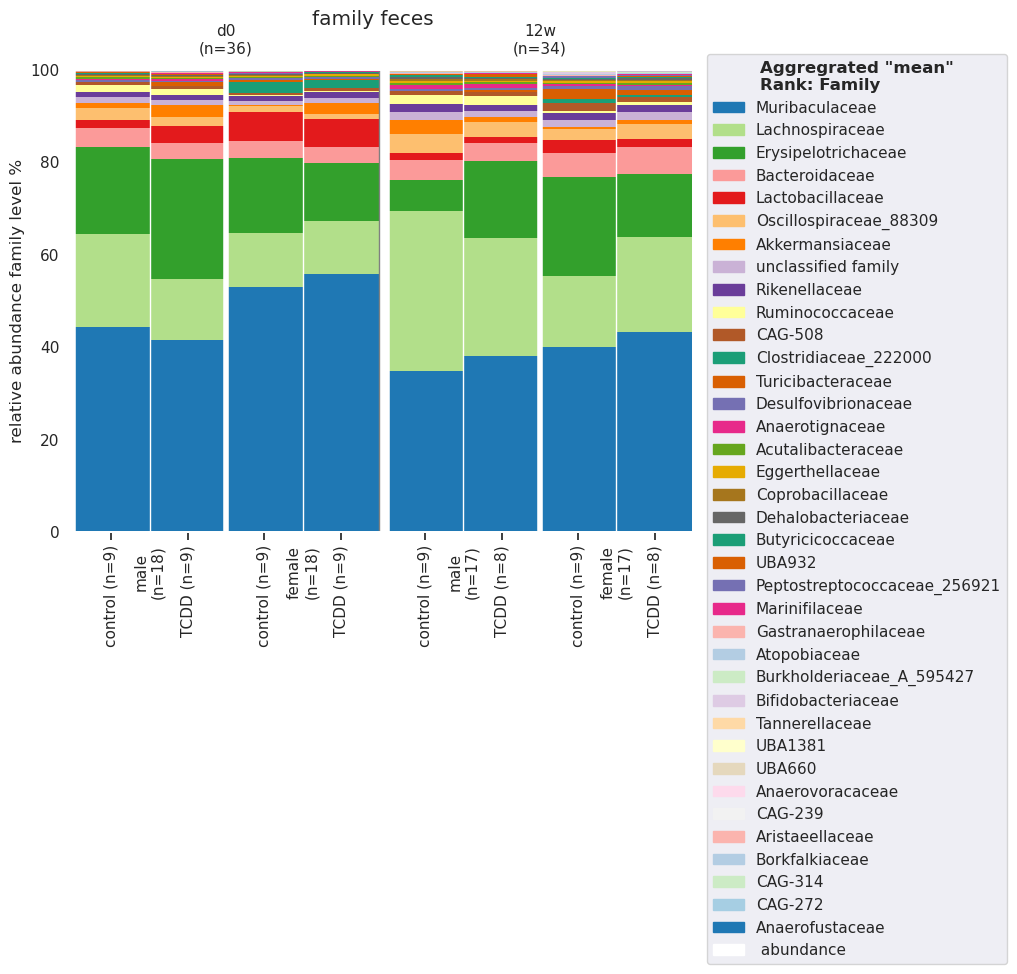

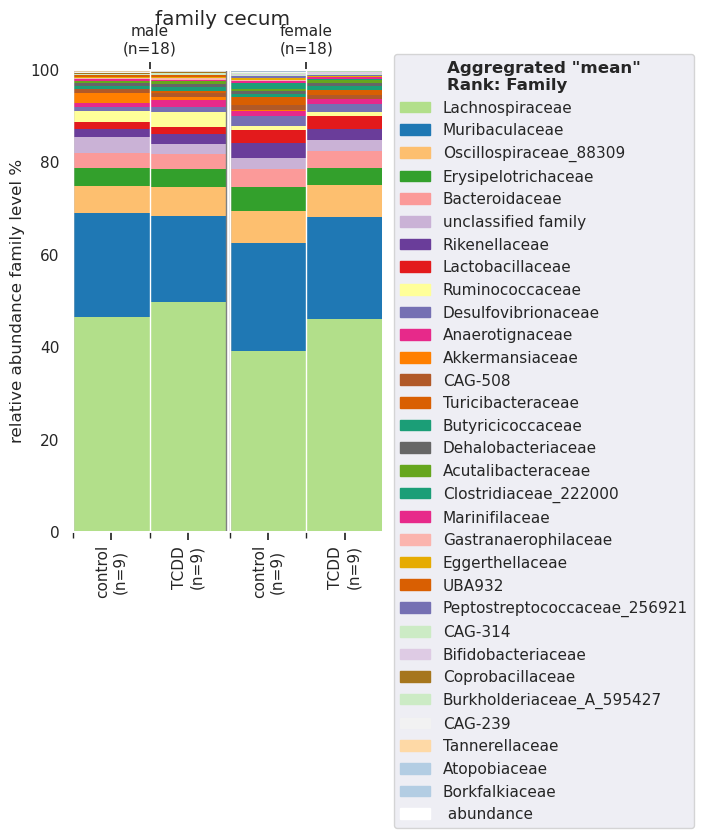

In [76]:
for bodysite, res, panel in [('feces', res_feces, 'E'), ('cecum', res_cecal, 'F')]:
    g0, g1, g2 = 'timepoint', 'sex', 'condition'
    spacer = [0.1, 0.04, 0.01]
    num_bars = 4*2
    if bodysite == 'cecum':
        g0, g1, g2 = g1, g2, None
        spacer = [0.04, 0.01, None]
        num_bars = 4*1
    p = plotTaxonomy(res['rarefaction']['results'],
                     prj_data['metadata'].sort_values(by=['sex', 'condition'], ascending=[False, False]), 
                     rank=RANK, file_taxonomy=res['taxonomy']['RDP']['results']['Taxon'],
                     group_l0=g0, group_l1=g1, group_l2=g2,
                     fct_aggregate=np.mean, 
                     horizontal_spacer=spacer,
                     legend_remove_rank_prefix=True,
                     #reorder_samples=False
                     colors=colors_genera,
                     print_sample_labels=True if bodysite == 'feces' else None,
                    )
    colors_genera = p[4]
    p[0].get_axes()[0].set_ylabel('relative abundance %s level %%' % RANK.lower())
    p[0].get_axes()[0].set_yticklabels(map(lambda x: '%01.f' % (x*100), p[0].get_axes()[0].get_yticks()))
    p[0].suptitle('%s %s' % (RANK.lower(), bodysite))
    p[0].set_size_inches((num_bars, 6))
    #break
    _savefig(p[0], 'fig4_panel%s_%s' % (panel, RANK))

#### Support statements: 
- "Collapsing ASVs to family level, decrease of Muribaculaceae from day 0 to week 12,
- as well as an increase in Lachnospiraceae is seen in both sexes, irrespective of TCDD exposure (Fig 4E).
- Note that male mice harbored more Ruminococcaceae than female mice at both time-points.
- In contrast, in cecum microbiota no difference were detactable at family level (Fig 4F)."

=========== feces d0->12w timepoint =========
42 taxa left after collapsing to Family.
'timepoint'  (n=70)
    23 (of   42) taxa different between 'd0' (n=36) vs. '12w' (n=34)

42 taxa left after collapsing to Family.


Reduced to 70 samples (feature-table had 70, metadata had 158 samples)
Using existing results from '.anacache/e66fa9973b823ce5cea5d4a1001ea922.ancom'. 


significantly different  >= 0.000000 mean rel. abundance  #Family
1                     True                             True        1
0                    False                             True       41

=========== cecum d0->12w timepoint =========
36 taxa left after collapsing to Family.


too few groups cecum timepoint


=========== feces d0->12w male timepoint =========
42 taxa left after collapsing to Family.
'timepoint'  (n=35)
    15 (of   42) taxa different between 'd0' (n=18) vs. '12w' (n=17)

42 taxa left after collapsing to Family.


Reduced to 70 samples (feature-table had 70, metadata had 158 samples)
Using existing results from '.anacache/e66fa9973b823ce5cea5d4a1001ea922.ancom'. 


significantly different  >= 0.000000 mean rel. abundance  #Family
1                     True                             True        1
0                    False                             True       41

=========== cecum d0->12w male timepoint =========
36 taxa left after collapsing to Family.


too few groups cecum timepoint


=========== feces d0->12w female timepoint =========
42 taxa left after collapsing to Family.
'timepoint'  (n=35)
    24 (of   42) taxa different between 'd0' (n=18) vs. '12w' (n=17)

42 taxa left after collapsing to Family.


Reduced to 70 samples (feature-table had 70, metadata had 158 samples)
Using existing results from '.anacache/e66fa9973b823ce5cea5d4a1001ea922.ancom'. 


significantly different  >= 0.000000 mean rel. abundance  #Family
1                     True                             True        1
0                    False                             True       41

=========== cecum d0->12w female timepoint =========
36 taxa left after collapsing to Family.
=========== feces male->female d0 sex =========
42 taxa left after collapsing to Family.


too few groups cecum timepoint


'sex'  (n=36)
    15 (of   42) taxa different between 'male' (n=18) vs. 'female' (n=18)

42 taxa left after collapsing to Family.


Reduced to 70 samples (feature-table had 70, metadata had 158 samples)
Using existing results from '.anacache/f1dc00a4be68da12cd5a6c44568fb593.ancom'. 


significantly different  >= 0.000000 mean rel. abundance  #Family
1                     True                             True        7
0                    False                             True       35

=========== cecum male->female d0 sex =========
36 taxa left after collapsing to Family.
=========== feces male->female 12w sex =========
42 taxa left after collapsing to Family.


too few groups cecum sex


'sex'  (n=34)
    19 (of   42) taxa different between 'female' (n=17) vs. 'male' (n=17)

42 taxa left after collapsing to Family.


Reduced to 70 samples (feature-table had 70, metadata had 158 samples)
Using existing results from '.anacache/f1dc00a4be68da12cd5a6c44568fb593.ancom'. 


significantly different  >= 0.000000 mean rel. abundance  #Family
1                     True                             True        7
0                    False                             True       35

=========== cecum male->female 12w sex =========
36 taxa left after collapsing to Family.
'sex'  (n=36)
    14 (of   36) taxa different between 'male' (n=18) vs. 'female' (n=18)

36 taxa left after collapsing to Family.


Reduced to 36 samples (feature-table had 36, metadata had 158 samples)
Using existing results from '.anacache/0966bb4ea577b59ae6db8c3d4f265aef.ancom'. 


significantly different  >= 0.000000 mean rel. abundance  #Family
1                     True                             True        5
0                    False                             True       31

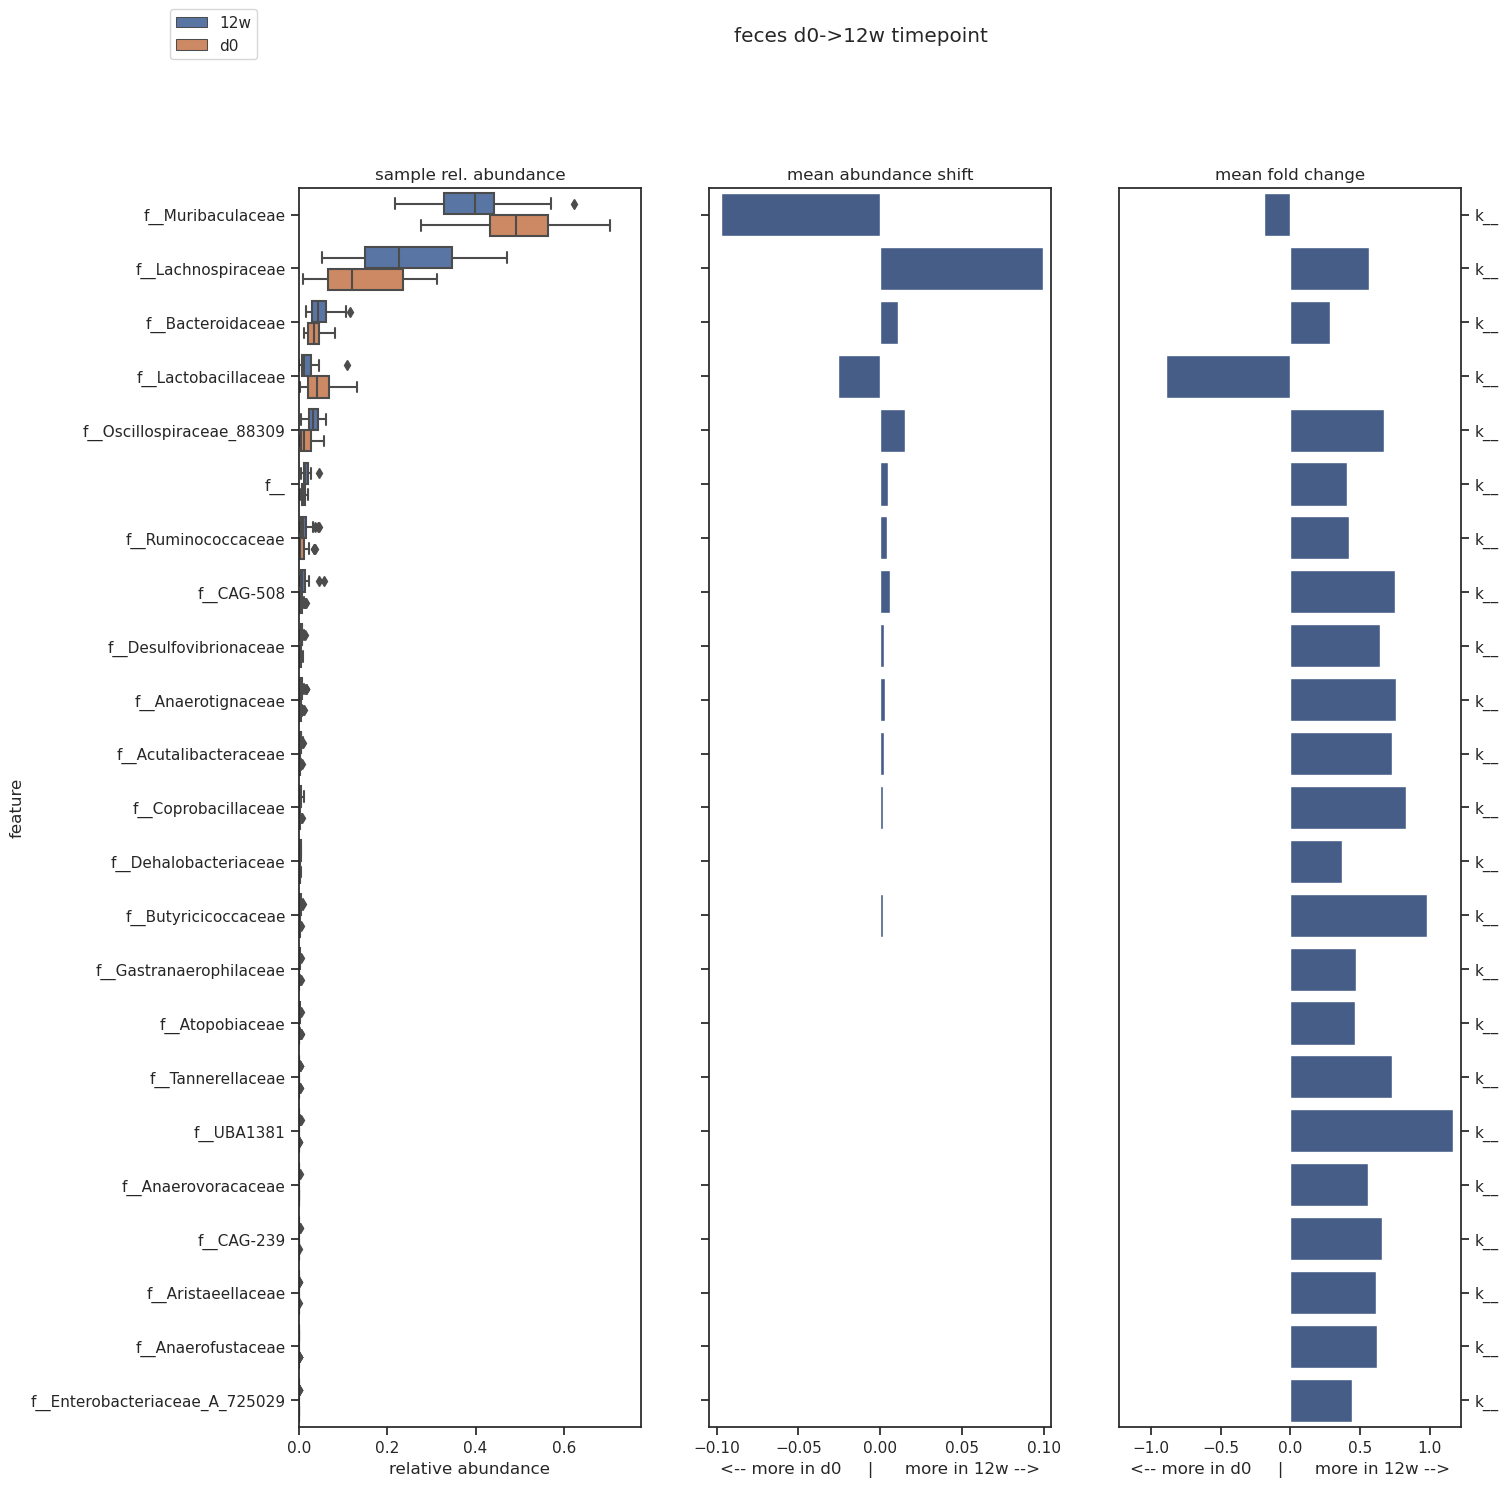

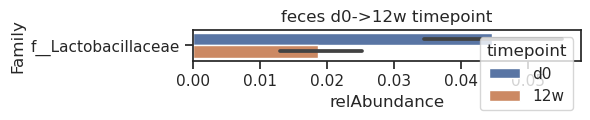

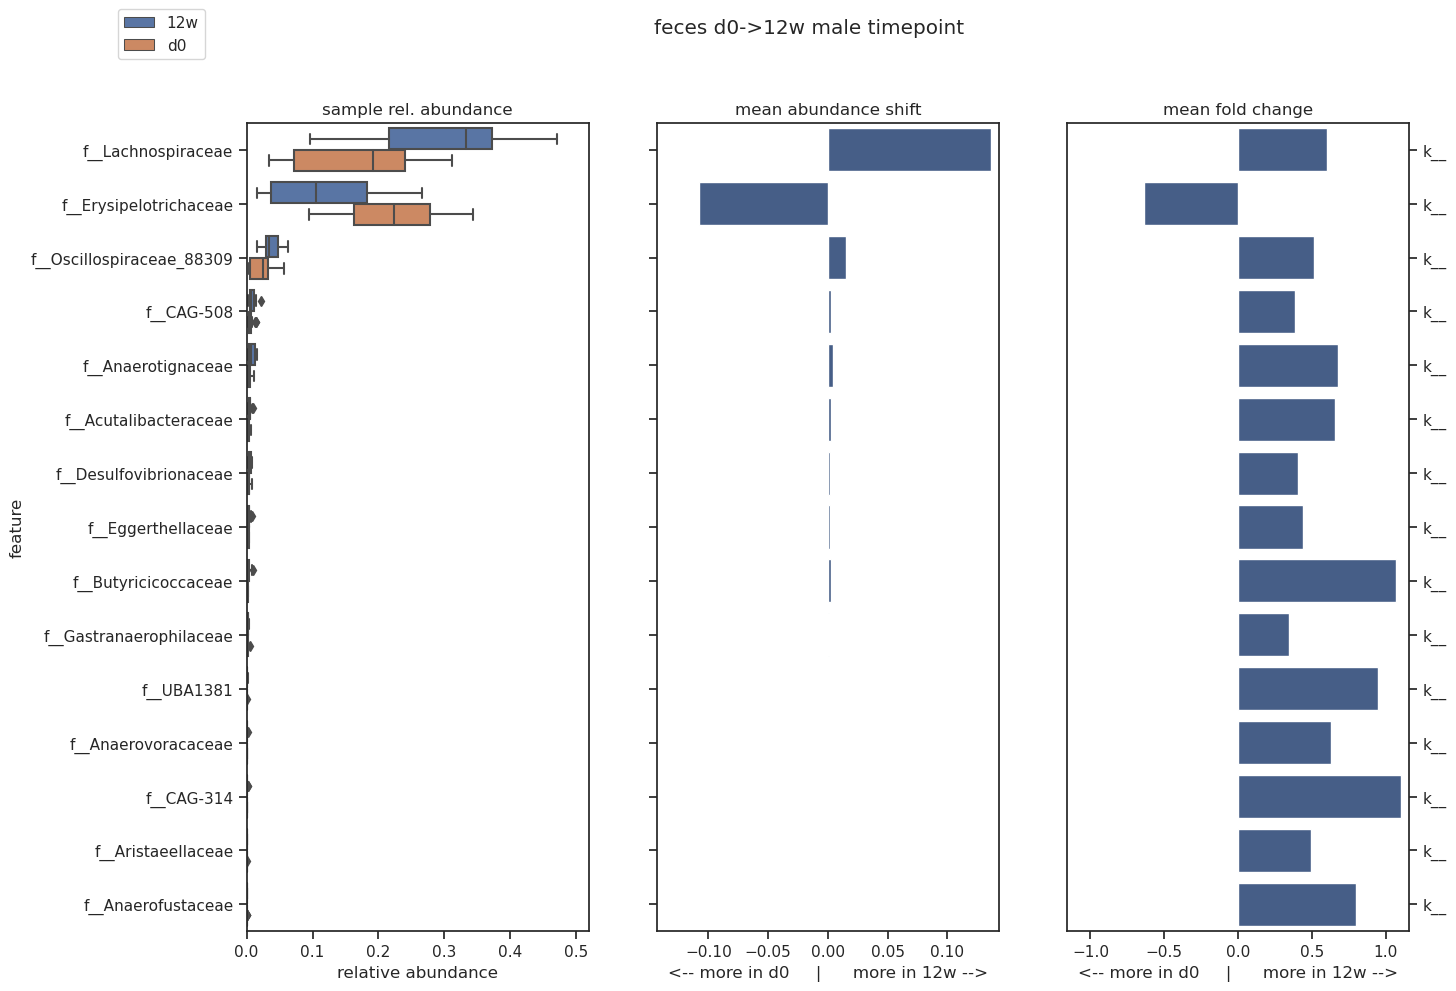

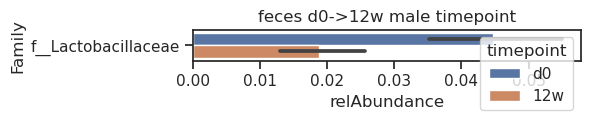

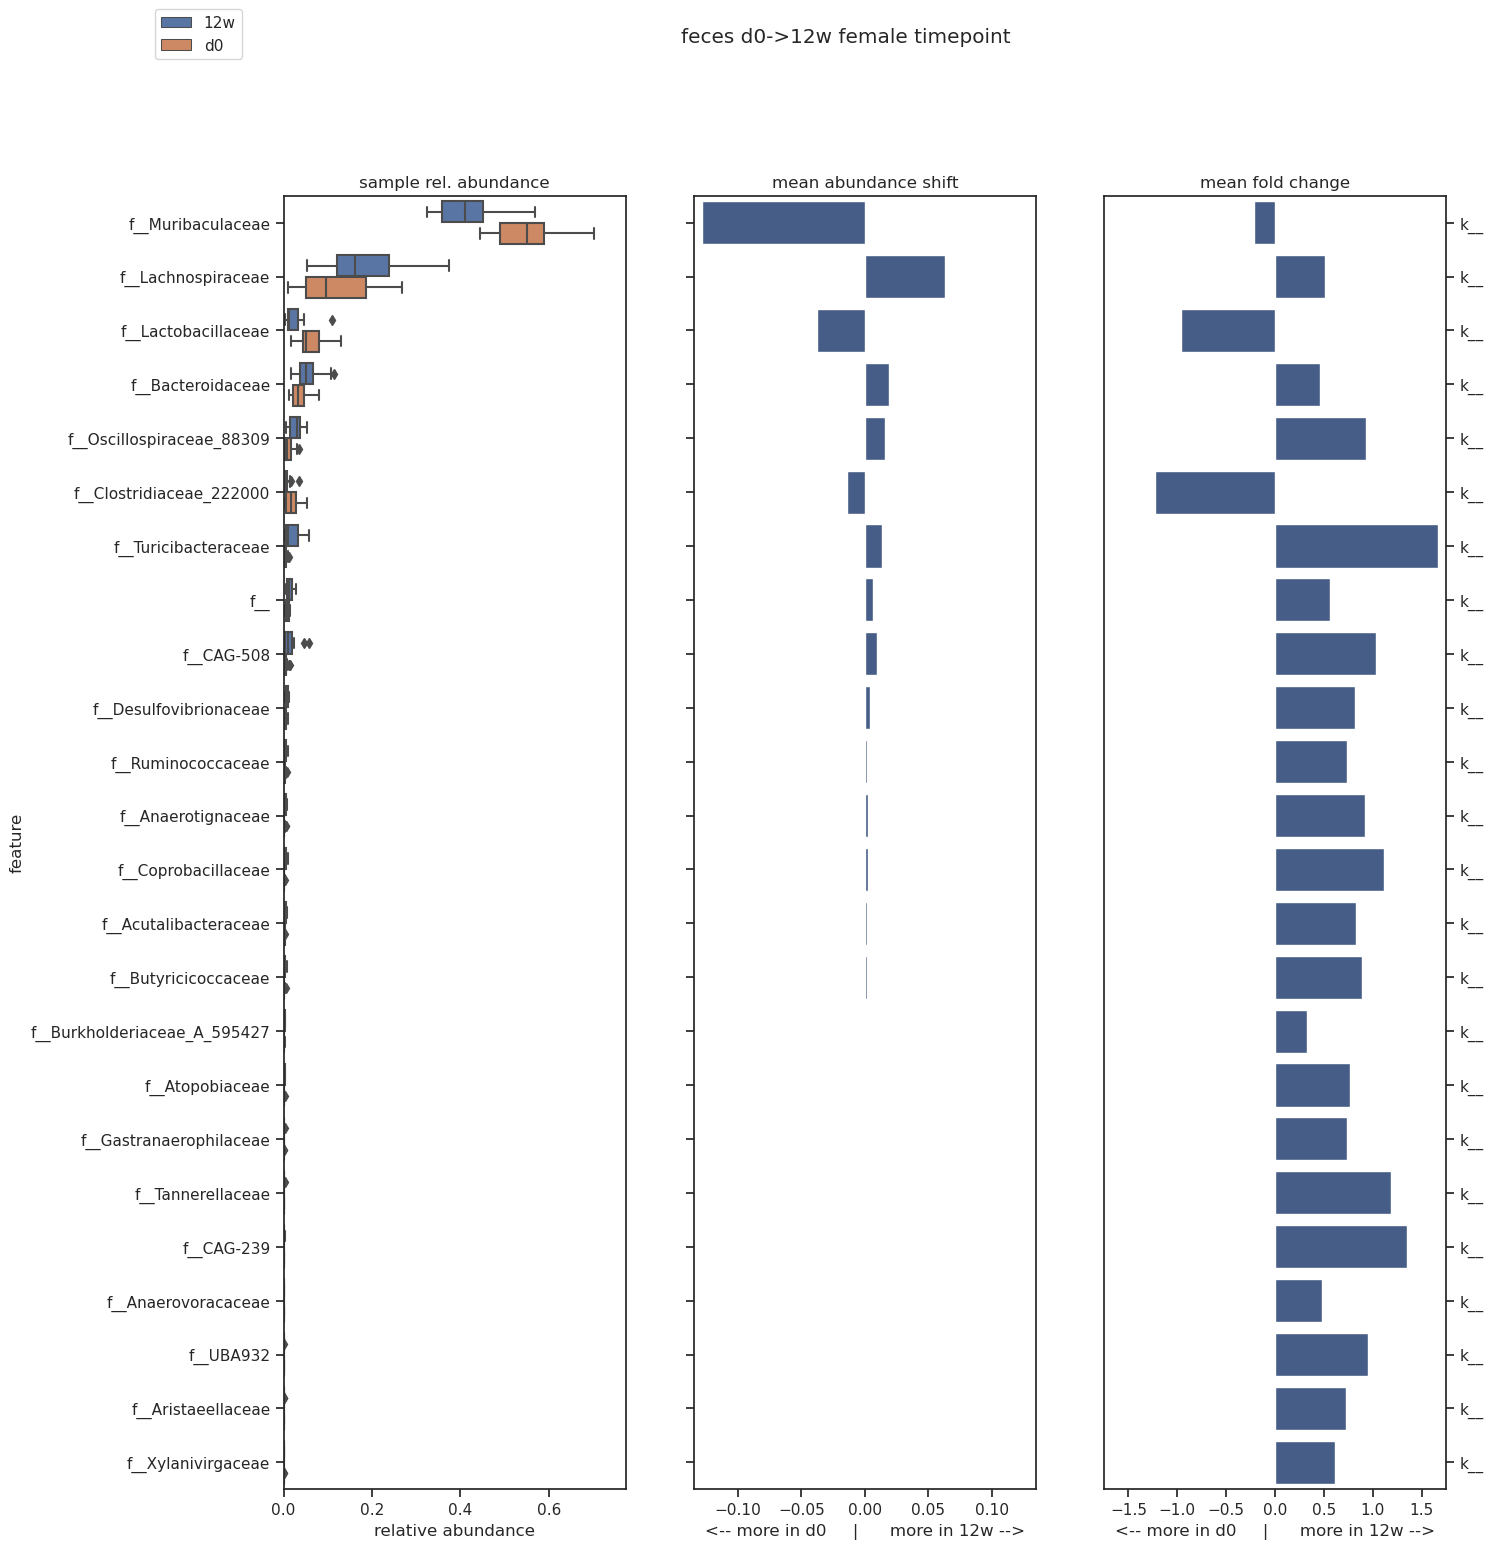

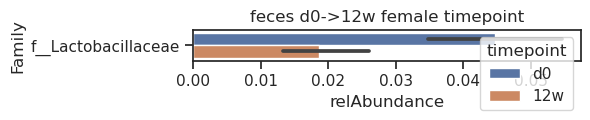

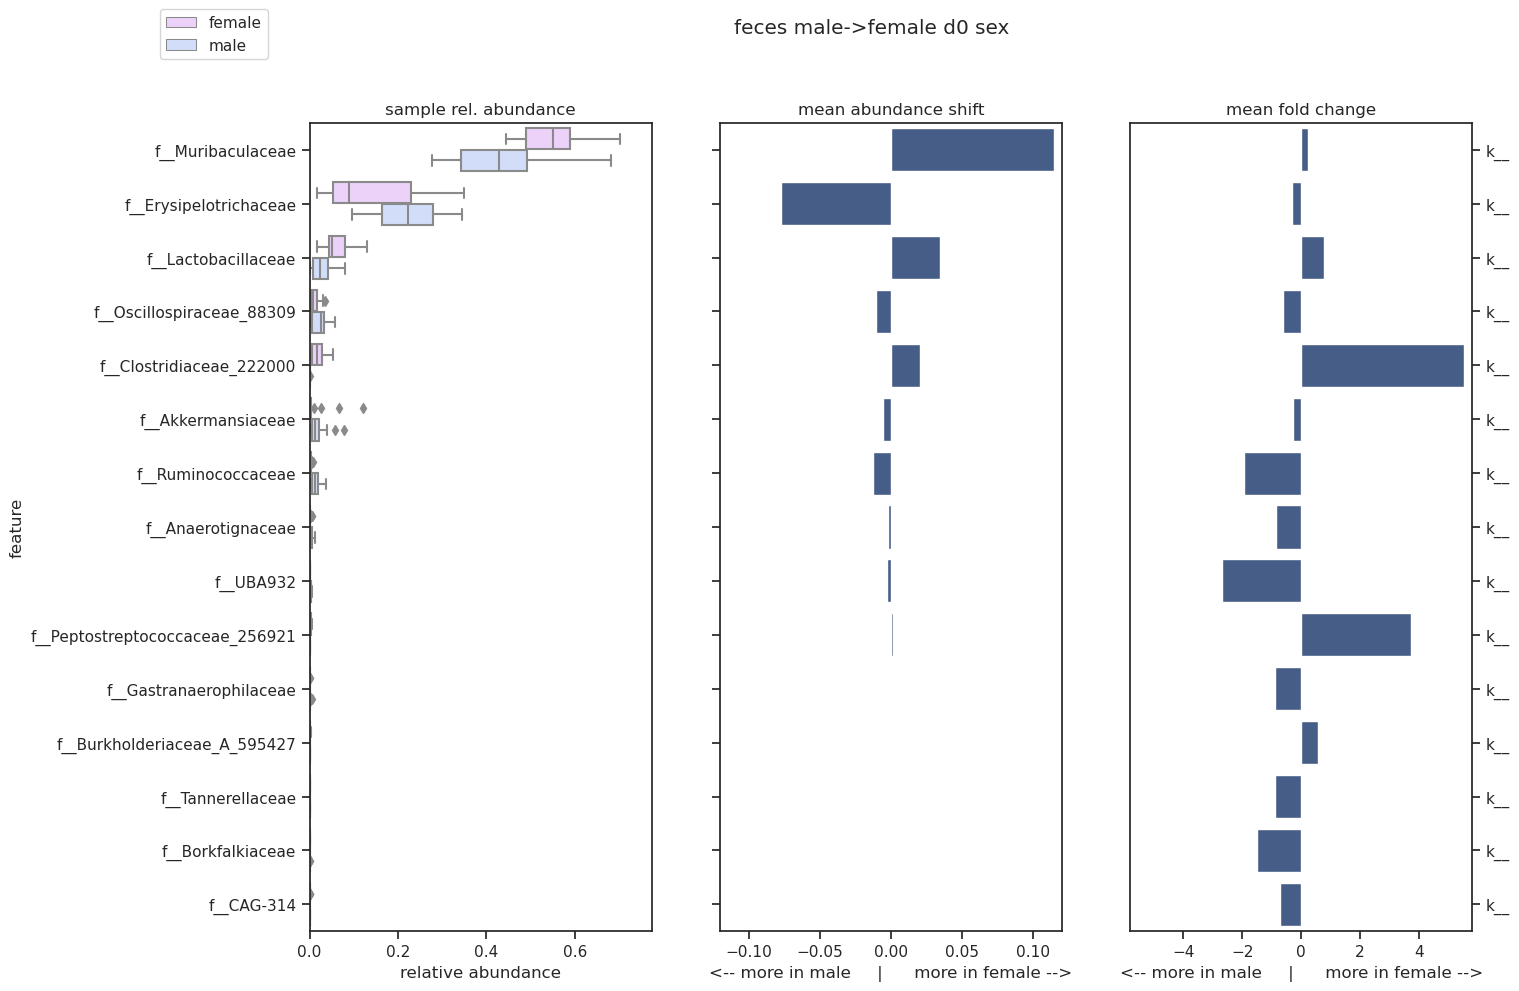

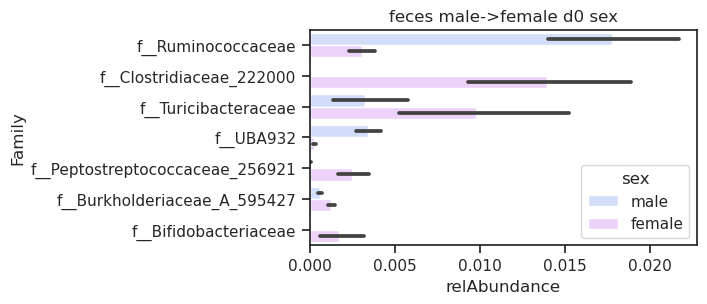

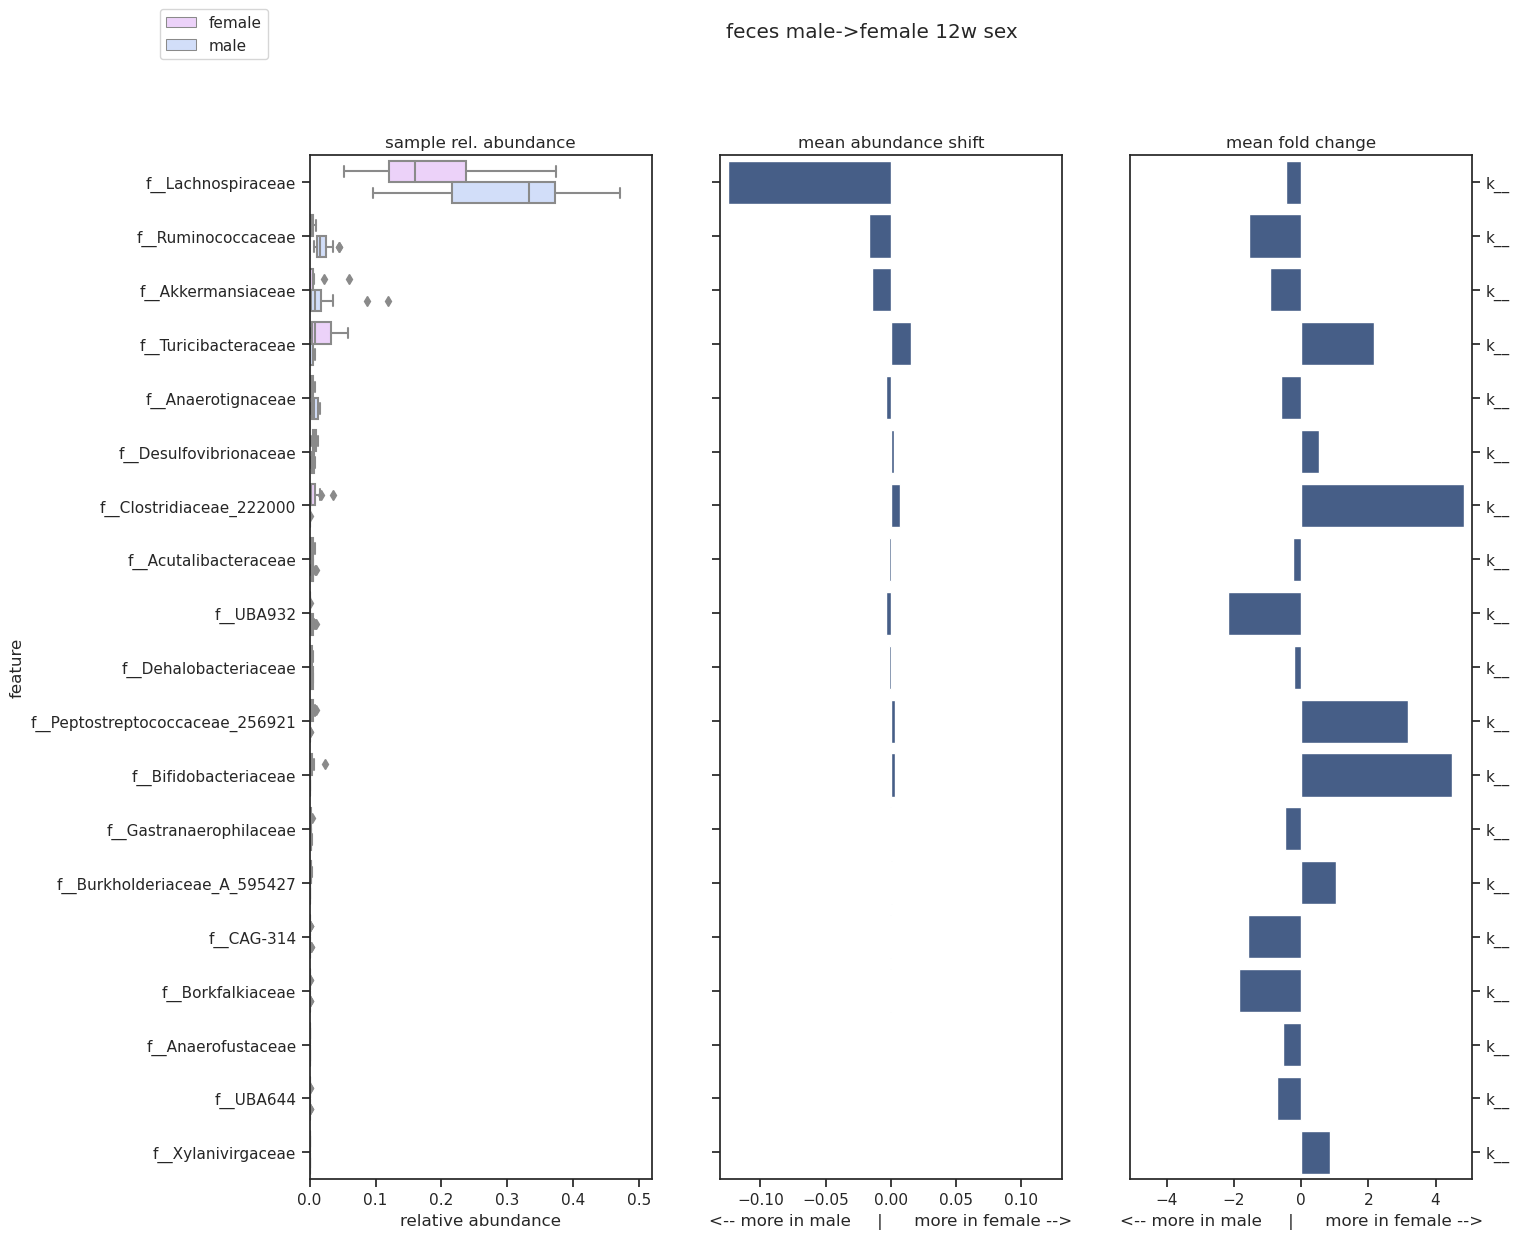

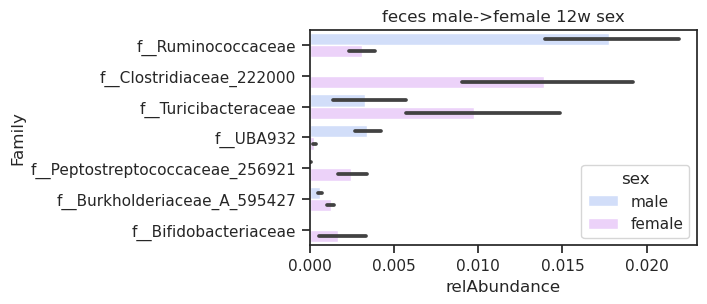

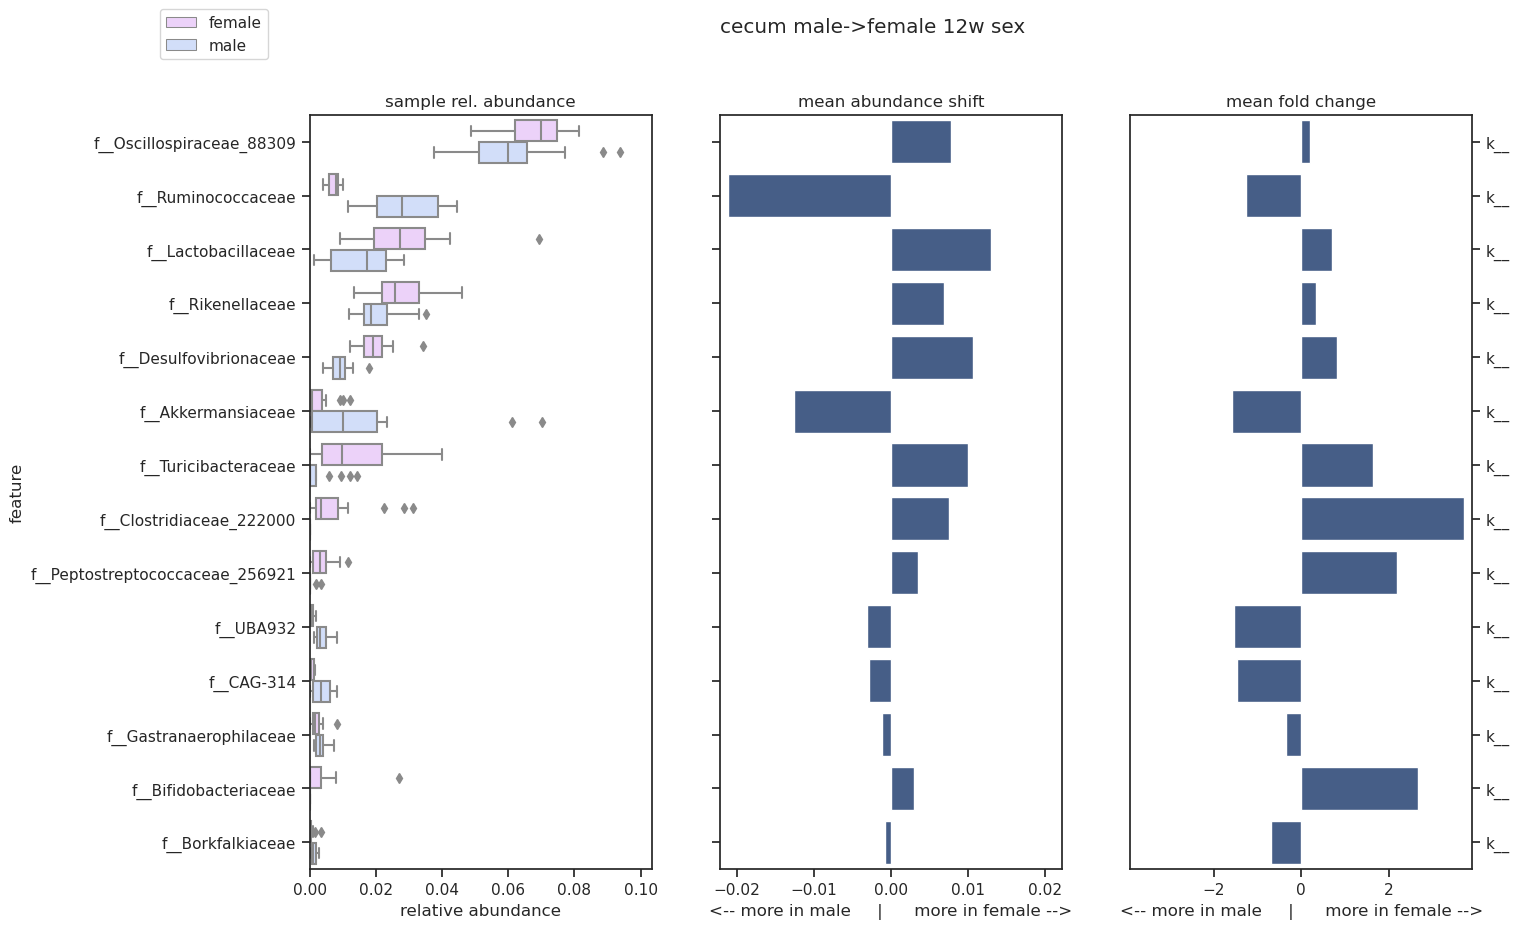

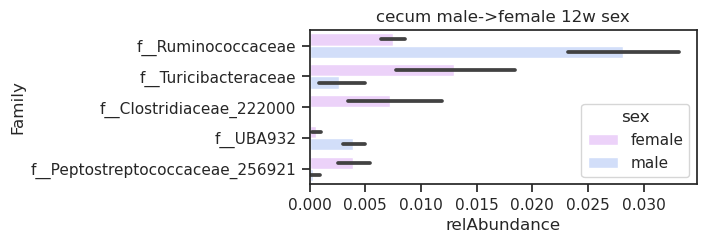

In [125]:
#meta = prj_data['metadata'].copy()
for (grp, meta, field) in [('d0->12w', prj_data['metadata'].copy(), 'timepoint'),
                    ('d0->12w male', prj_data['metadata'][prj_data['metadata']['sex'] == 'male'].copy(), 'timepoint'),
                    ('d0->12w female', prj_data['metadata'][prj_data['metadata']['sex'] == 'female'].copy(), 'timepoint'),
                    ('male->female d0', prj_data['metadata'][prj_data['metadata']['timepoint'] == 'd0'].copy(), 'sex'),
                    ('male->female 12w', prj_data['metadata'][prj_data['metadata']['timepoint'] == '12w'].copy(), 'sex'),
                    ]:
    meta.to_csv('%s/tmp_dsfdr.tsv' % prj_data['paths']['tmp_workdir'], sep="\t", index=True)
    diff_rank = 'Family'
    for bodysite, res in [('feces', res_feces), ('cecum', res_cecal)]:
        print("=========== %s %s %s =========" % (bodysite, grp, field))
        coll_counts = collapseCounts_objects(res['counts_plantsremoved'], diff_rank, res['taxonomy']['RDP']['results']['Taxon'])[0]
        pandas2biom('%s/tmp_dsfrd.biom' % prj_data['paths']['tmp_workdir'], coll_counts)
        dsFDR_experiment = ca.read_amplicon('%s/tmp_dsfrd.biom' % prj_data['paths']['tmp_workdir'], 
                                            '%s/tmp_dsfdr.tsv' % prj_data['paths']['tmp_workdir'], min_reads=0, normalize=10000)
        if len(meta.loc[list(set(coll_counts.columns) & set(meta.index)), field].unique()) < 2:
            print("too few groups", bodysite, field, file=sys.stderr)
            continue

        palette = None
        if field == 'sex':
            palette = {'female': color_female, 'male': color_male}
    
        res_dsFDR = find_diff_taxa(dsFDR_experiment, meta, [field])
        if len(res_dsFDR) > 0:
            p = plot_diff_taxa(coll_counts,
                               meta[field], res_dsFDR,
                               min_mean_abundance=0, #0.005,
                               colors_boxplot=palette, 
                               #color_barplot='gray'
                               taxonomy=res['taxonomy']['RDP']['results']['Taxon']
                              )
            p[0].suptitle('%s %s %s' % (bodysite, grp, field))
            
        res_ancom = ancom(
            res['rarefaction']['results'],  # you can in principle also start from a feature table NOT being rarefied, i.e. res_all['counts_plantsremoved']
            rank=diff_rank,  # feature table is collapsed at this taxonomic rank, as ANCOM struggles from too many features like individual ASVs. But try rank="raw" as well!
            taxonomy=res['taxonomy']['RDP']['results']['Taxon'],
            grouping=prj_data['metadata'][field],  # the metadata column that groups all samples into two conditions
            dry=False, wait=False,
            # following are plotting parameters only, i.e. won't change/trigger a re-run
            min_mean_abundance_per_feature=0, #0.007,
            post_cache_arguments={'palette': palette, 
                                  #'feature_order': list(name_map.keys()), 
                                  #'hue_order': ['B6J', 'C']
            })
        if res_ancom['results'] is not None:
            res_ancom['results']['figure'].get_axes()[0].set_title('%s %s %s' % (bodysite, grp, field))
            if field == 'sex':
                panel = {('feces', 'male->female d0'): 'E',
                         ('feces', 'male->female 12w'): 'F',
                         ('cecum', 'male->female 12w'): 'G'}
                _savefig(res_ancom['results']['figure'], 'figS6_panel%s_%s_%s' % (panel.get((bodysite, grp), 'X'), bodysite, grp.replace('->', '_vs_').replace(' ', '_')))

## Figure 5
### internal quality control

/tmp/ipykernel_3365253/1887424090.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=d, y=metric, x='condition', palette=COLORS_CONDITIONS, size=10, ax=ax)
/tmp/ipykernel_3365253/1887424090.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=d, y=metric, x='condition', palette=COLORS_CONDITIONS, size=10, ax=ax)
/tmp/ipykernel_3365253/1887424090.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=d, y=metric, x='condition', palette=COLORS_CONDITIONS, size=10, ax=ax)
/tmp/ipykernel_3365253/1887424090.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=d, y=metric, x='condition', palette=COLORS_CONDITIONS, size=10, ax=ax)
/tmp/ipykernel_3365253/1887424090.py:11: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=d, y=metric, x='condition', palette=COLORS_CON

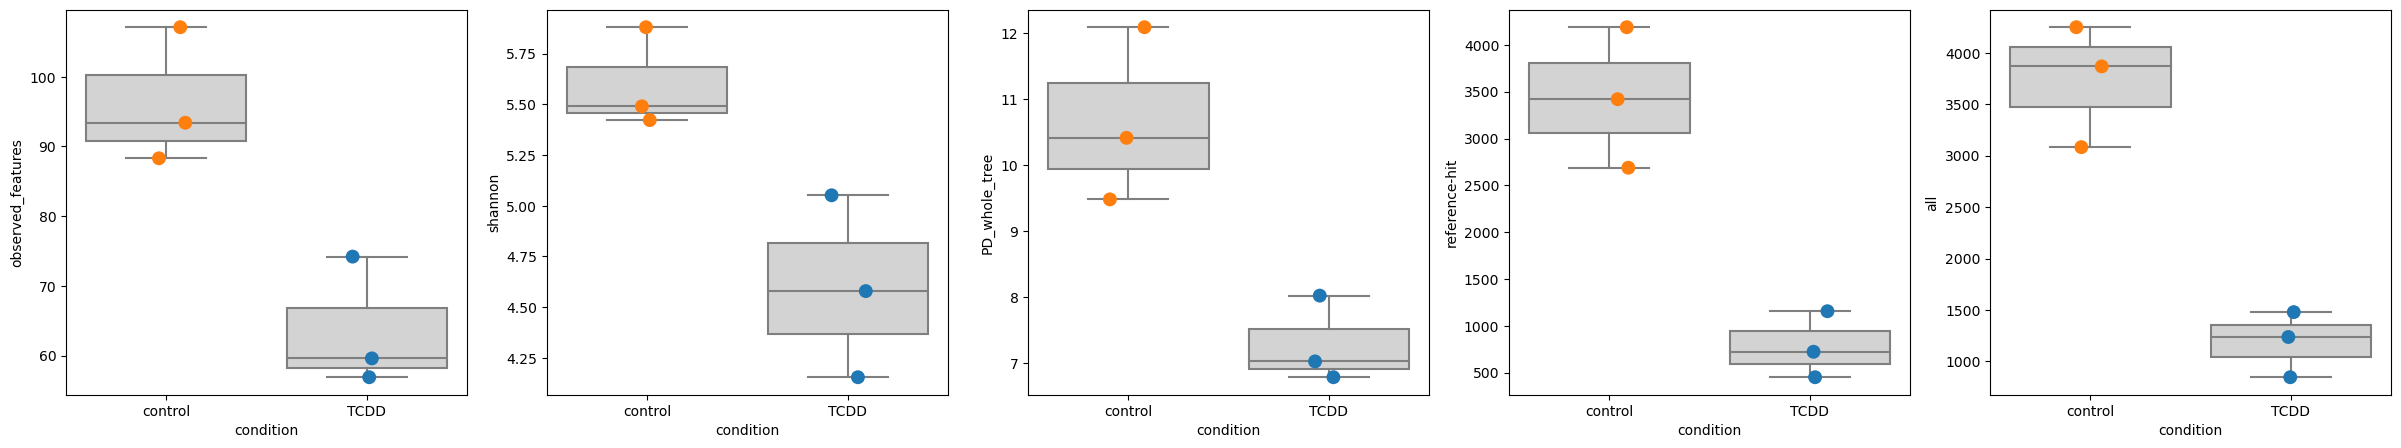

In [17]:
readcounts = pd.concat([
    biom2pandas('FromQiita/214707_reference-hit.biom').loc[:, res_flow['alpha_diversity']['results'].index].sum().rename('reference-hit'),
    biom2pandas('FromQiita/214706_all.biom').loc[:, res_flow['alpha_diversity']['results'].index].sum().rename('all'),], axis=1)

d = prj_data['metadata'].merge(res_flow['alpha_diversity']['results'], left_index=True, right_index=True, how='right')
d = d.merge(readcounts, left_index=True, right_index=True)

fig, axes = plt.subplots(1, 3+2, figsize=((3+2)*6, 1*5))
for ax, metric in zip(axes, list(res_flow['alpha_diversity']['results'].columns) + list(readcounts.columns)):
    sns.boxplot(data=d, y=metric, x='condition', color='lightgray', ax=ax)
    sns.stripplot(data=d, y=metric, x='condition', palette=COLORS_CONDITIONS, size=10, ax=ax)

### Panel D

63 taxa left after collapsing to Genus.
6 samples left with metadata and counts.
raw counts: 6
raw meta: 172
meta with counts: 6 samples x 83 fields
counts with meta: 6
81 taxa left after collapsing to Genus.
6 samples left with metadata and counts.
raw counts: 6
raw meta: 172
meta with counts: 6 samples x 83 fields
counts with meta: 6
27 taxa left after collapsing to Family.
6 samples left with metadata and counts.
raw counts: 6
raw meta: 172
meta with counts: 6 samples x 83 fields
counts with meta: 6
36 taxa left after collapsing to Family.
6 samples left with metadata and counts.
raw counts: 6
raw meta: 172
meta with counts: 6 samples x 83 fields
counts with meta: 6


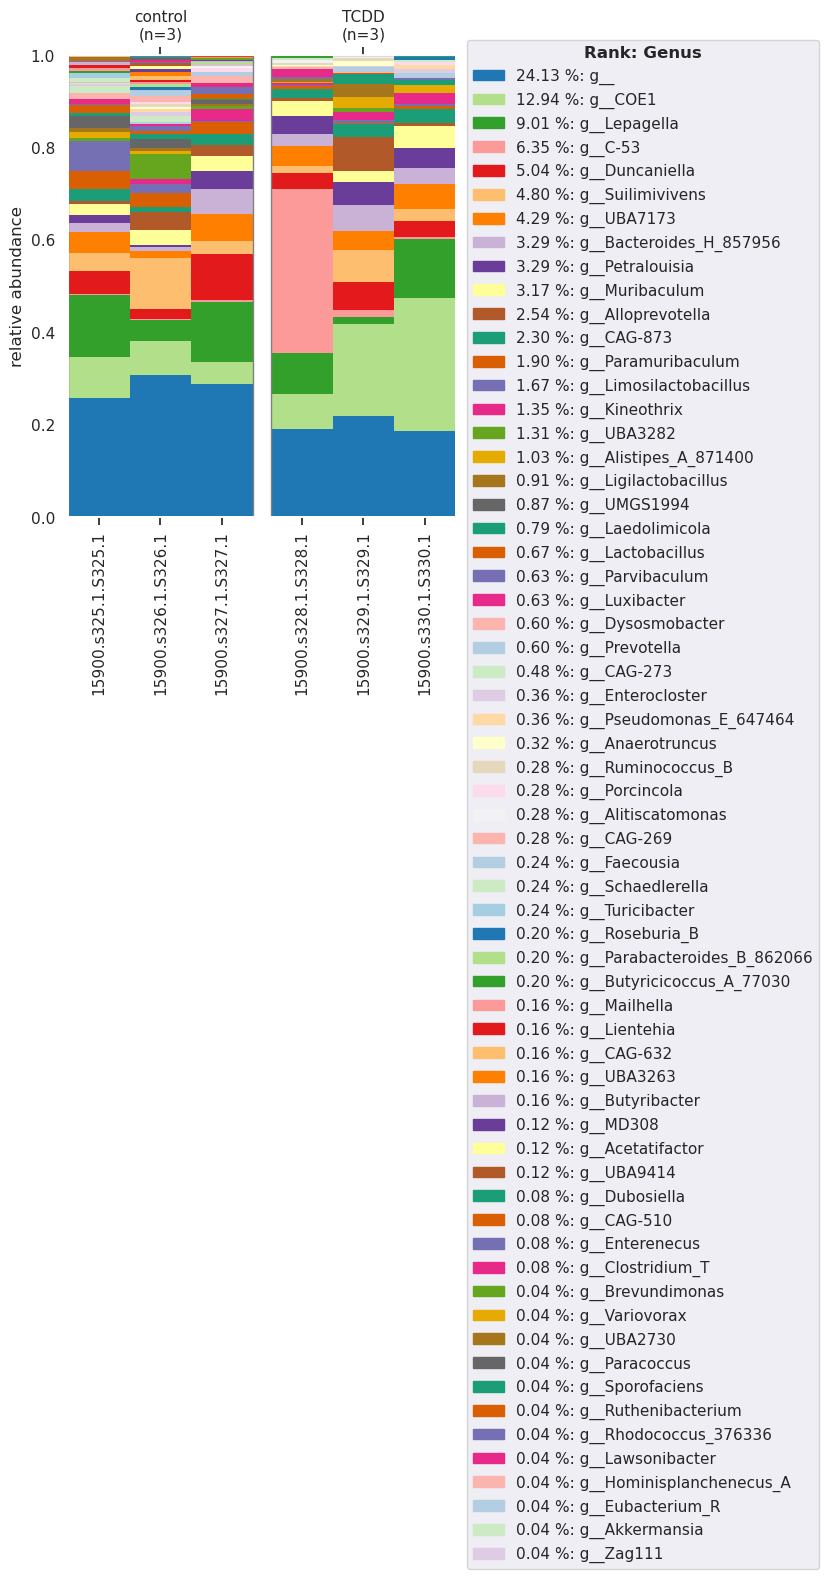

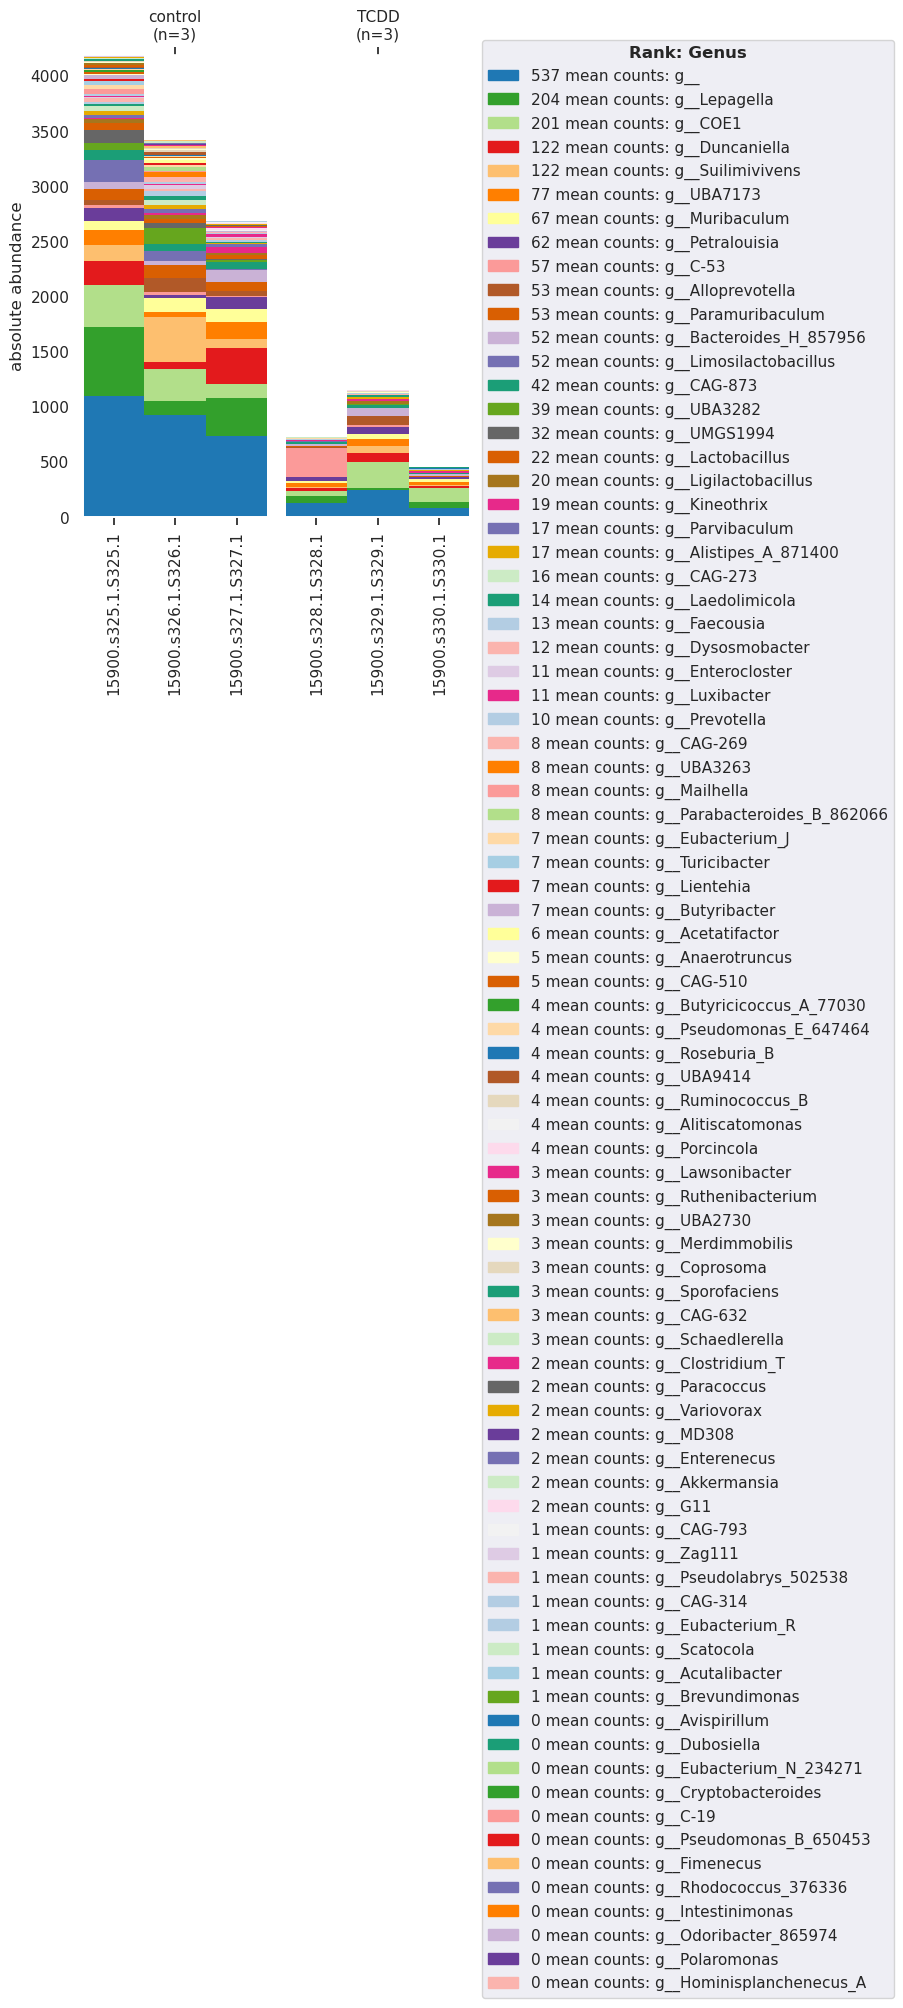

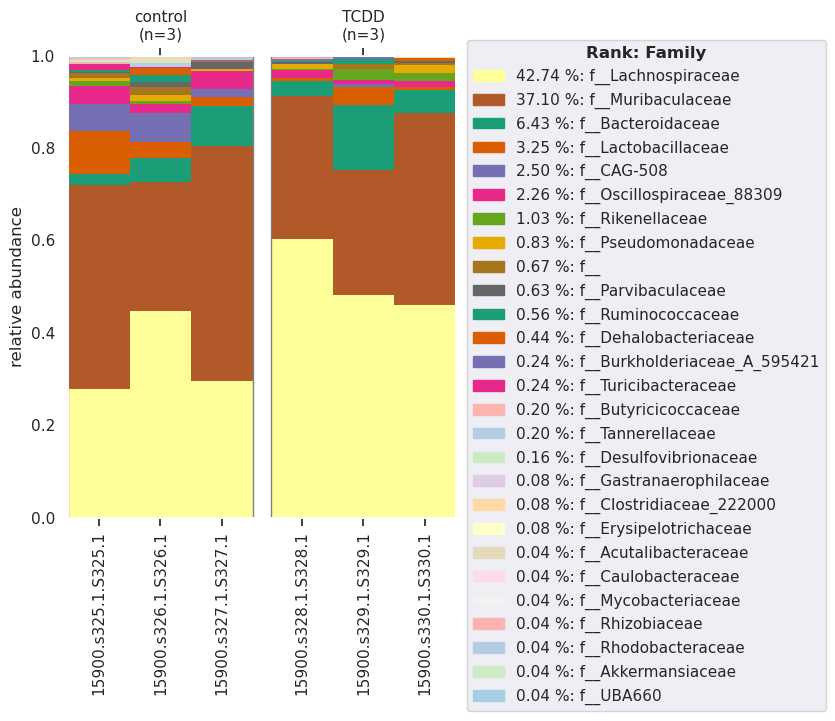

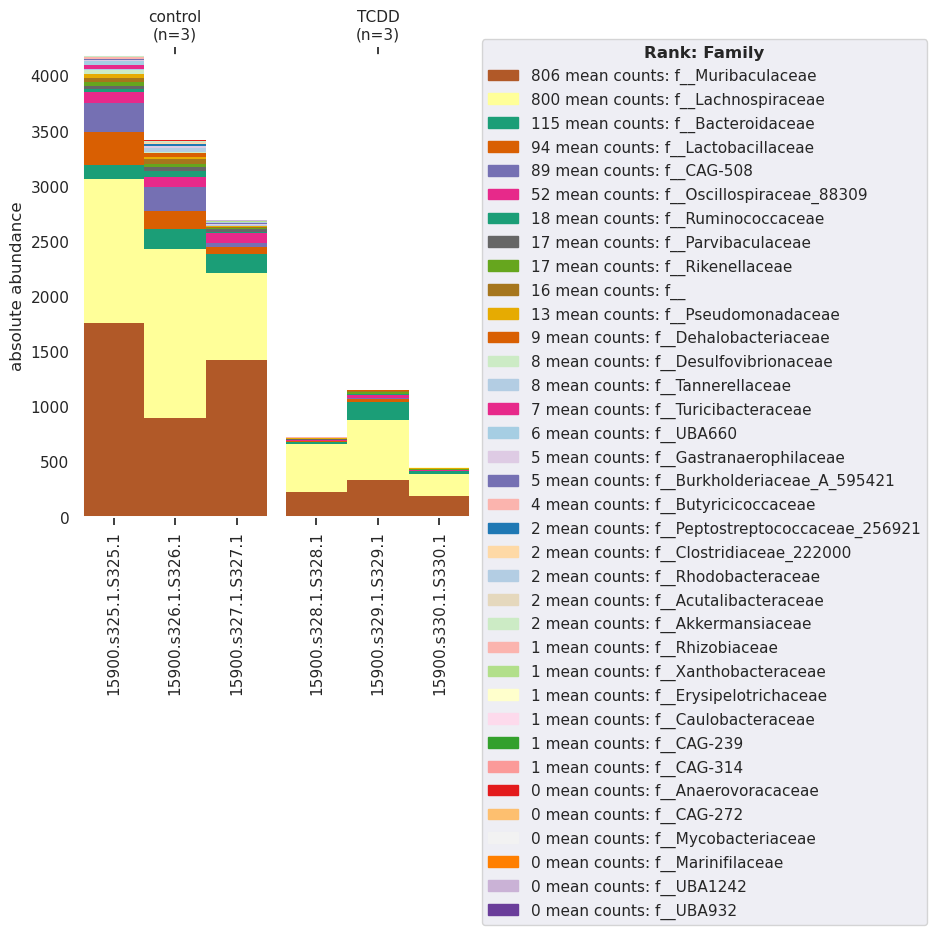

In [26]:
taxaSelections = {('manual', 'relative', 'Genus'): ["g__Enterocloster", "g__Lactobacillus", "g__Ligilactobacillus", "g__Limosilactobacillus"],
                  ('manual', 'relative', 'Family'): ["f__Lachnospiraceae", "f__Lactobacillaceae"]}

for RANK in ['Genus', 'Family']:
    taxaSelections[('manual', 'absolute', RANK)] = taxaSelections[('manual', 'relative', RANK)]  # duplicate from relative to absolute
    for relType in ['relative', 'absolute']:
        p = plotTaxonomy(res_flow['counts_plantsStillIn'] if relType == 'absolute' else res_flow['rarefaction']['results'],
                     prj_data['metadata'], #.sort_values(by=['sex', 'condition'], ascending=[False, False]), 
                     rank=RANK, file_taxonomy=res_flow['taxonomy']['RDP']['results']['Taxon'],
                     #group_l0='sex', 
                     group_l1='condition', #group_l2='condition',
                     #fct_aggregate=np.mean, 
                     horizontal_spacer=[0.3],
                     legend_remove_rank_prefix=True,
                     #reorder_samples=False
                     colors=colors_genera,
                     print_meanrelabunances=True, minreadnr=0, dont_normalize=(relType == 'absolute'),
                     print_sample_labels=True)
        taxaSelections[('auto', relType, RANK)] = [t for t in p[1].mean(axis=1).index if not t.endswith('__')][:4]
        taxaSelections[('top10', relType, RANK)] = [t for t in p[1].mean(axis=1).index if not t.endswith('__')][:10]
        p[0].set_size_inches((5, 6))
        _savefig(p[0], 'fig5_panelD_%s_%s' % (RANK, relType))
        #plt.close(p[0])

### Panel E

63 taxa left after collapsing to Genus.


/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/homes/sjanssen/Git/trevismd/statannotations/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/

27 taxa left after collapsing to Family.


/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)


81 taxa left after collapsing to Genus.


/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/homes/sjanssen/Git/trevismd/statannotations/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/tmp/ipykernel_3365253/

63 taxa left after collapsing to Genus.


/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/homes/sjanssen/Git/trevismd/statannotations/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/homes/sjanssen/Git/trevismd/statannotations/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/homes/sjanssen/Git/trevismd/statannot

63 taxa left after collapsing to Genus.


/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/homes/s

81 taxa left after collapsing to Genus.


/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/homes/sjanssen/Git/trevismd/statannotations/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/tmp/ipykernel_3365253/

81 taxa left after collapsing to Genus.


/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/homes/sjanssen/Git/trevismd/statannotations/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/tmp/ipykernel_3365253/

36 taxa left after collapsing to Family.


/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/homes/sjanssen/Git/trevismd/statannotations/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/homes/sjanssen/Git/trevismd/statannotations/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


27 taxa left after collapsing to Family.


/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/homes/s

27 taxa left after collapsing to Family.


/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipy

36 taxa left after collapsing to Family.


/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)


36 taxa left after collapsing to Family.


/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipykernel_3365253/96999288.py:14: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
/tmp/ipy

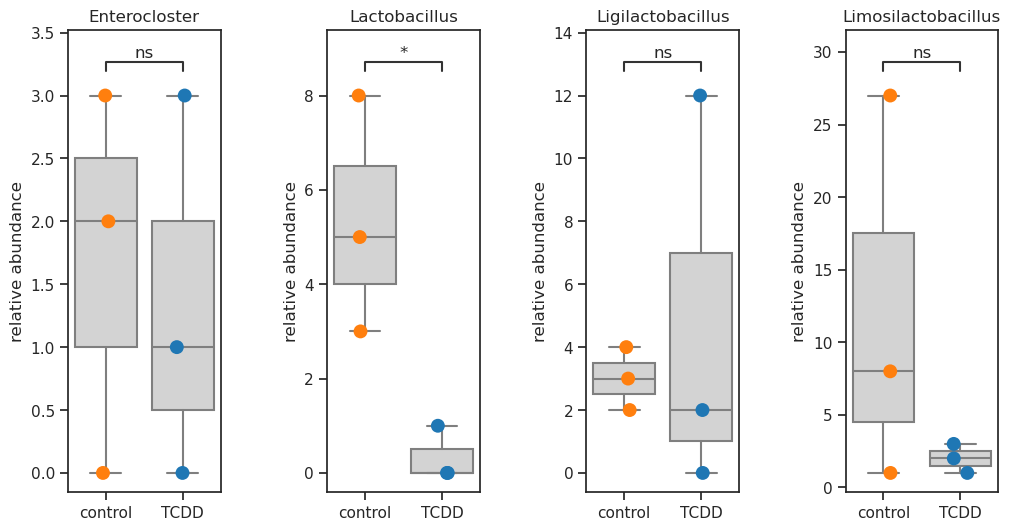

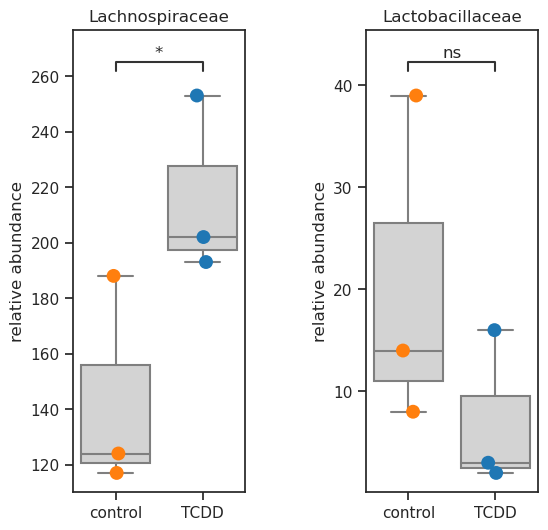

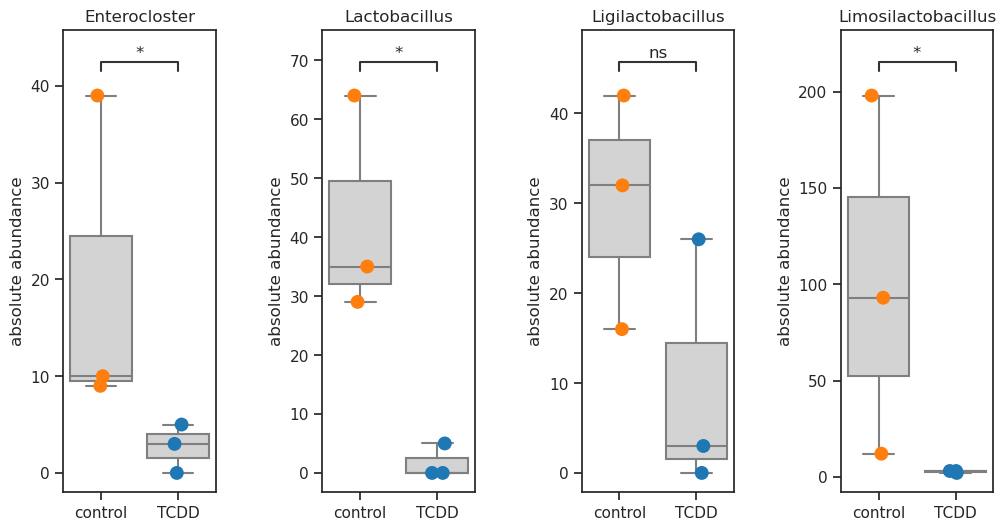

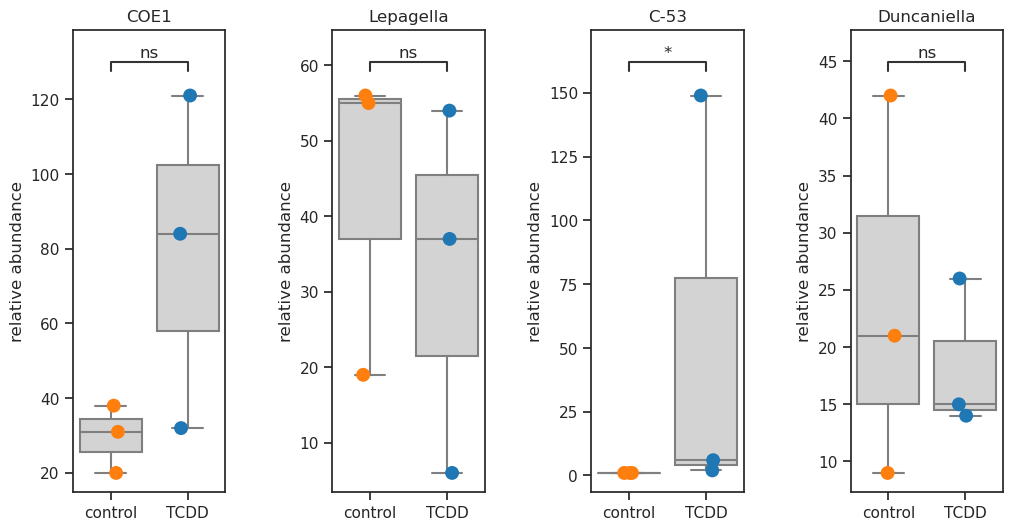

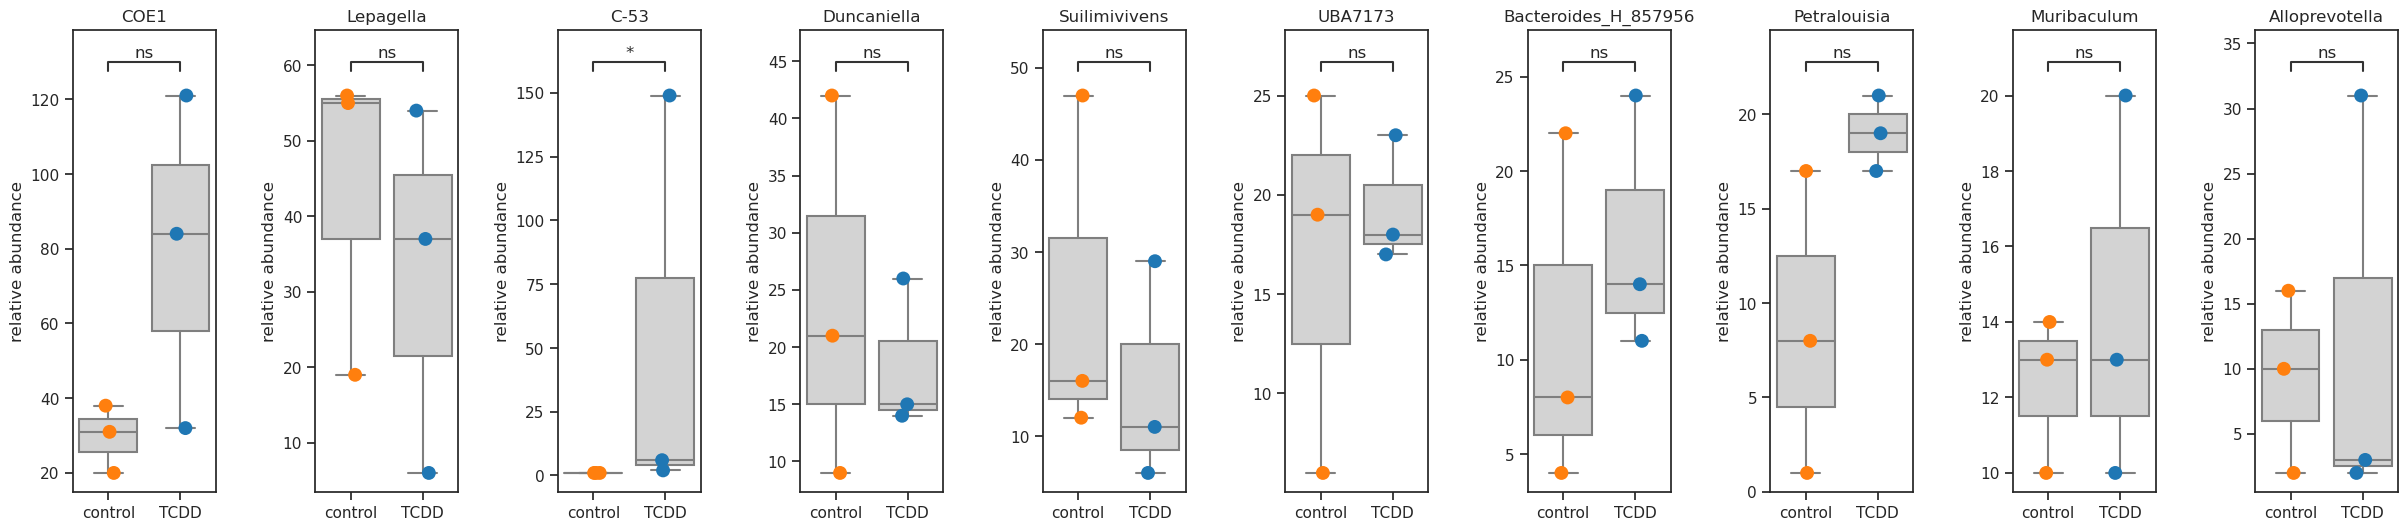

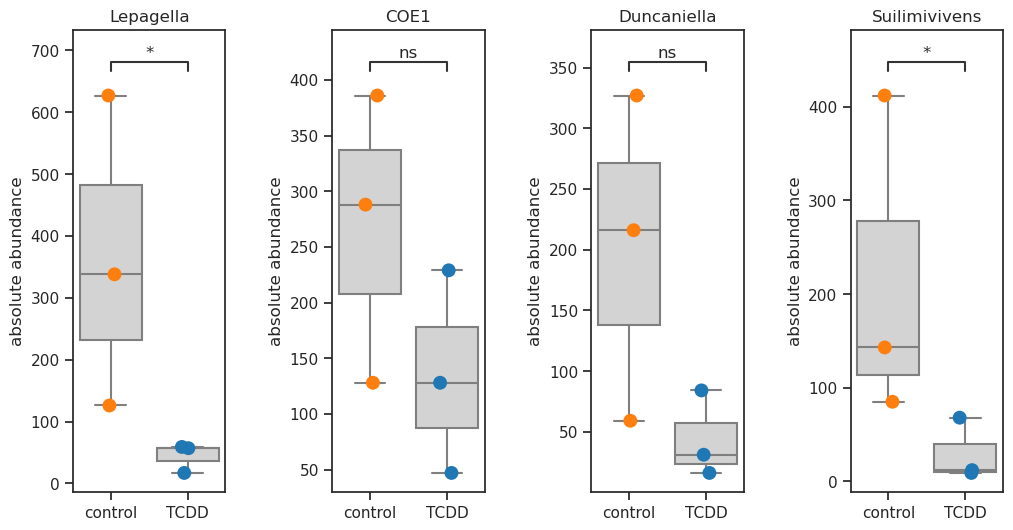

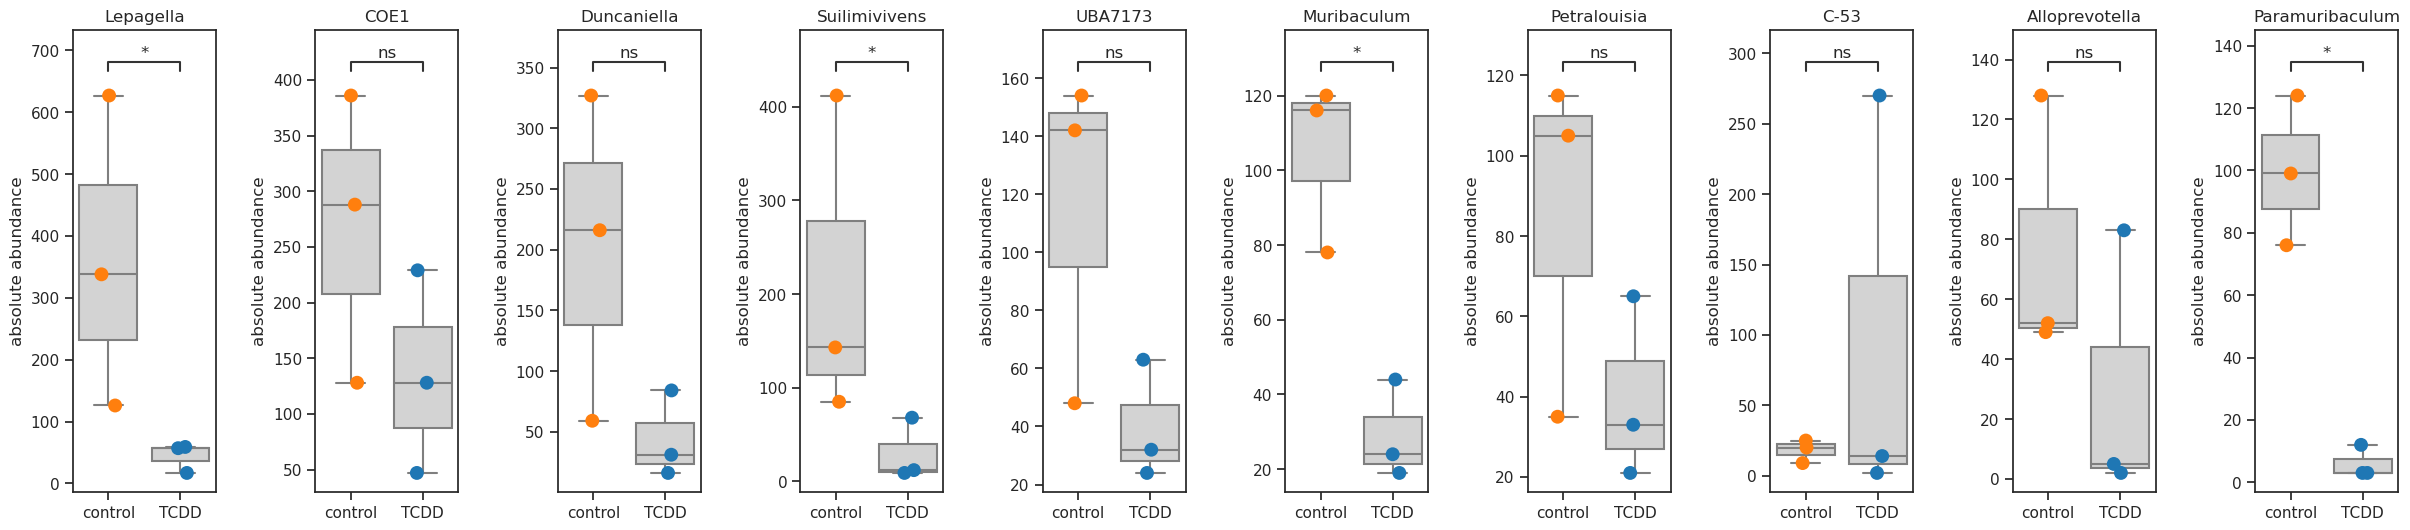

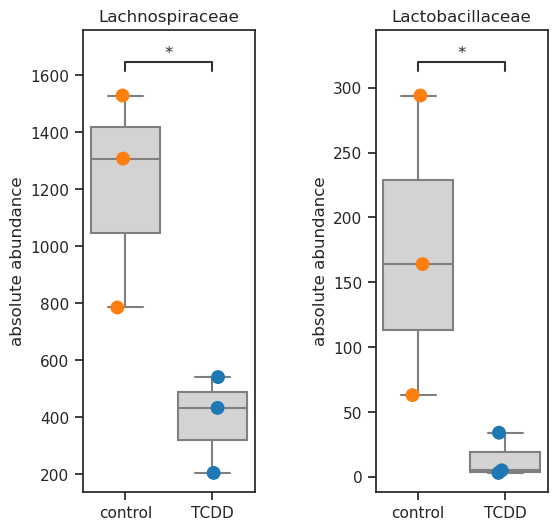

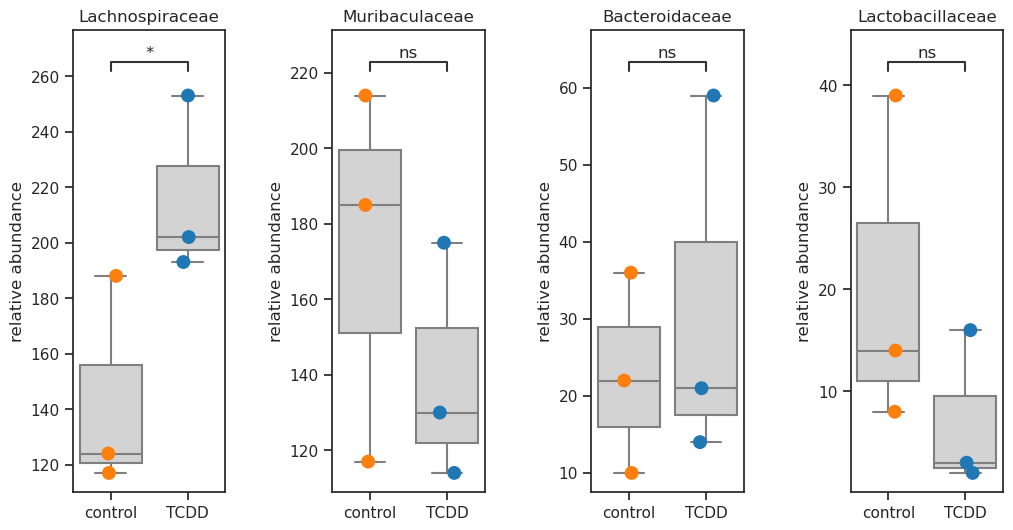

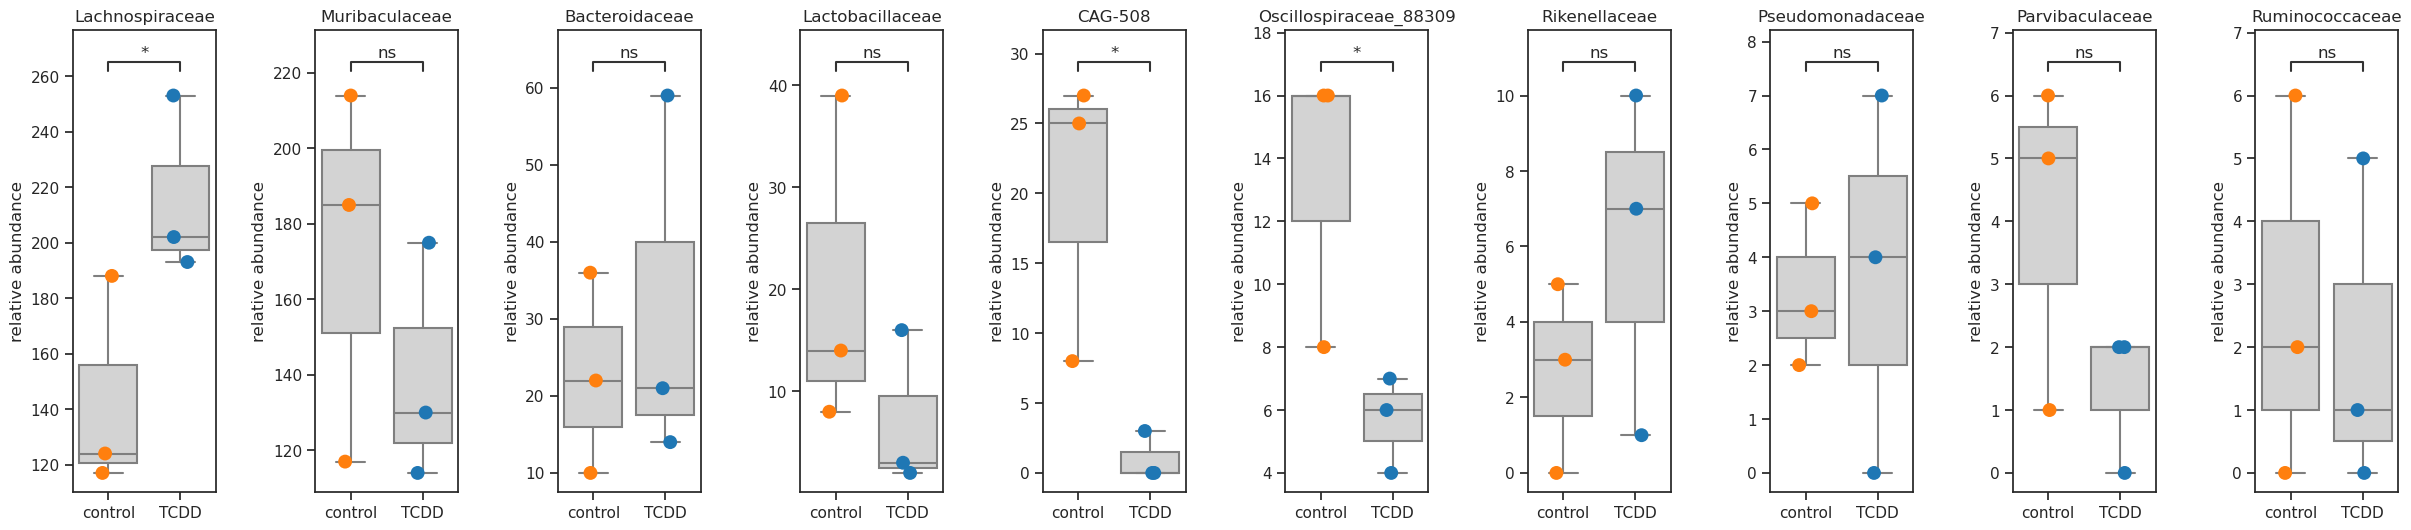

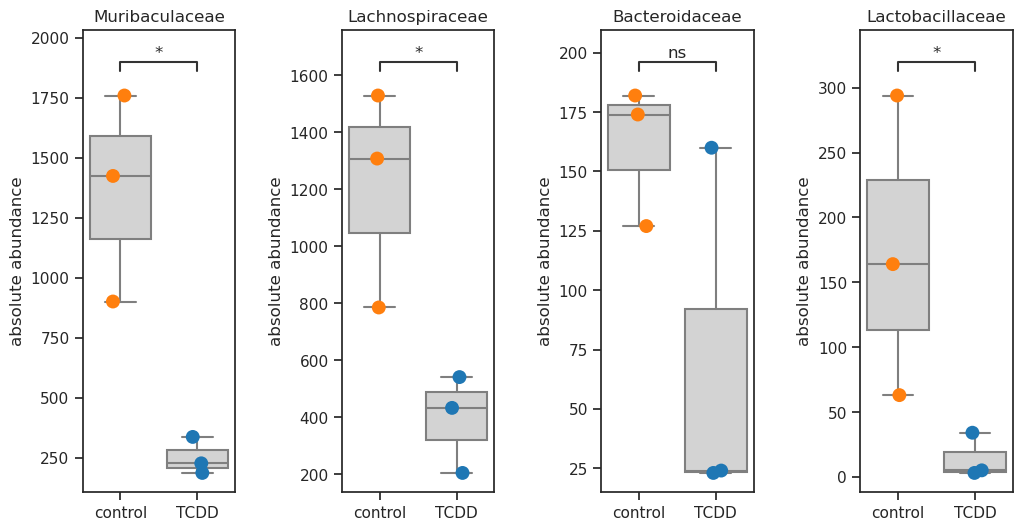

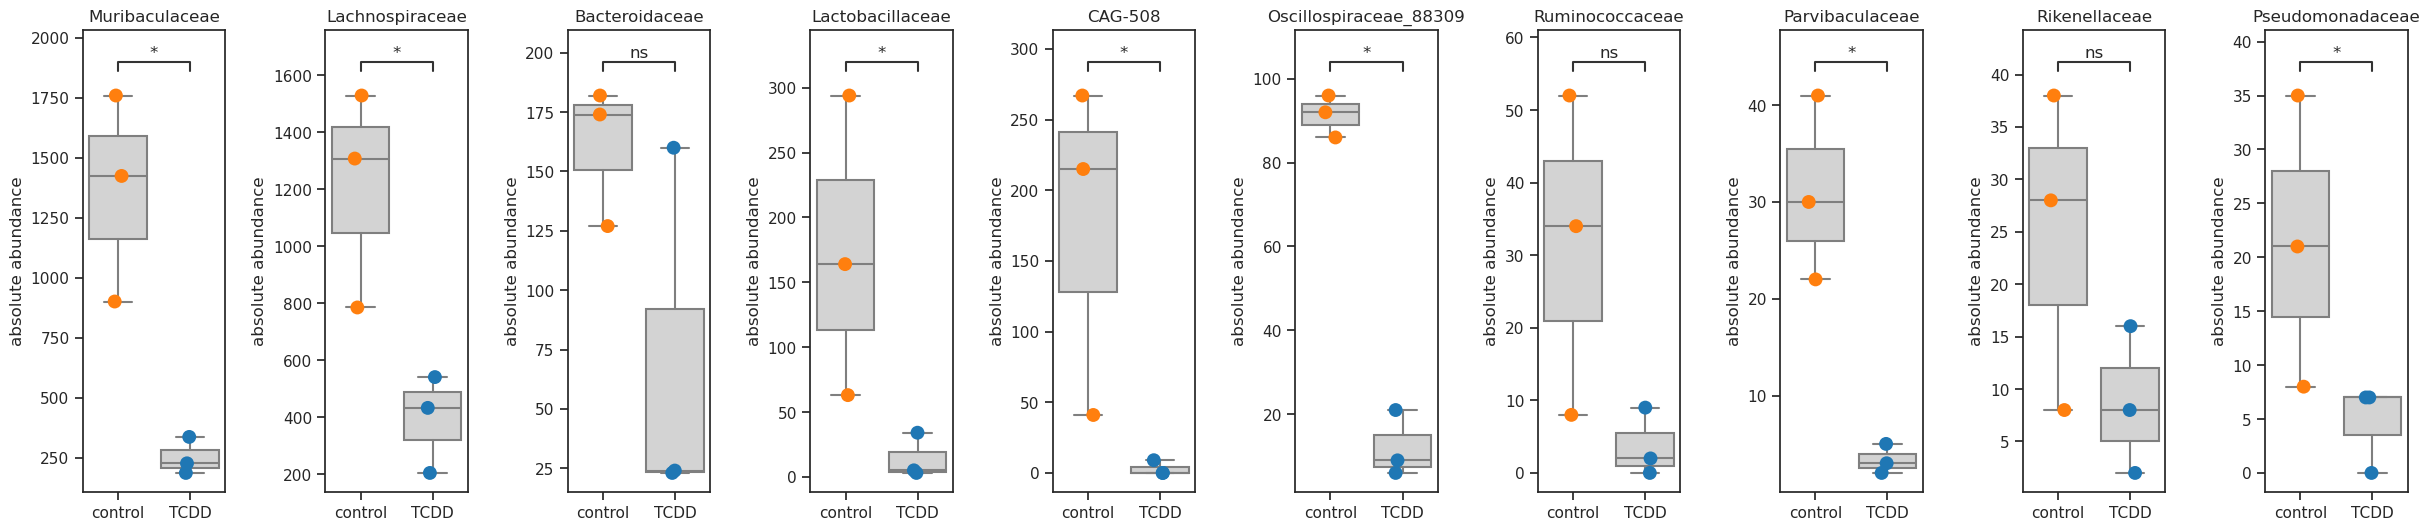

In [27]:
for (selType, relType, RANK) in taxaSelections.keys():
    data = None
    if relType == 'relative':
        data = collapseCounts_objects(res_flow['rarefaction']['results'], RANK, res_flow['taxonomy']['RDP']['results']['Taxon'])[0].loc[taxaSelections[(selType, relType, RANK)], :].stack().reset_index().merge(prj_data['metadata'], right_on='sample_name', left_on='level_1', how='left').rename(columns={0: 'relative abundance'})
    else:
        data = collapseCounts_objects(res_flow['counts_plantsStillIn'], RANK, res_flow['taxonomy']['RDP']['results']['Taxon'])[0].loc[taxaSelections[(selType, relType, RANK)], :].stack().reset_index().merge(prj_data['metadata'], right_on='sample_name', left_on='level_1', how='left').rename(columns={0: 'absolute abundance'})
    
    sns.set_style('ticks')
    fig, axes = plt.subplots(1, len(taxaSelections[(selType, relType, RANK)]), figsize=(len(taxaSelections[(selType, relType, RANK)])*3, 6))
    plt.subplots_adjust(wspace=0.7)
    for ax, taxon in zip(axes, taxaSelections[(selType, relType, RANK)]):
        g = data[data[RANK] == taxon]
        sns.boxplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], dodge=False, color='lightgray')
        sns.stripplot(data=g, y='%s abundance' % relType, x='condition', ax=ax, order=ORDERS['condition'], palette=COLORS_CONDITIONS, size=10)
        ax.set_title(taxon[3:])
        ax.set_xlabel("")
        
        annotator = Annotator(ax, [('control', 'TCDD')], data=g, y='%s abundance' % relType, x='condition', order=ORDERS['condition'])
        annotator.configure(test='Kruskal', text_format='star', loc='inside', comparisons_correction="fdr_bh", correction_format="default", verbose=False)
        annotator.apply_and_annotate()
    #break
    _savefig(fig, 'fig5_panelE_%s_%s_%s' % (RANK, relType, selType))
    #plt.close(fig)

#### get qPCR sequences from GG13.8

In [24]:
from skbio import DNA
import skbio
for (name, fwd, rev) in [('Blautia', 'aaatgacggtacctgactaa', 'ctttgagtttcattcttgcgaa'),
                         ('LactobacillusC', 'agcagtagggaatcttcca', 'attccaccgctacacatg'),
                         ('LactobacillusT', 'agcagtagggaatcttcca', 'atttcaccgctacacatg')]:
    fp_hits = prj_data['paths']['tmp_workdir'] + '/pcr_hits_%s.fasta' % name
    cmd = ('grep -i "%s" -B 1 /homes/sjanssen/MicrobiomeAnalyses/References/gg_13_5_otus/rep_set/99_otus.fasta | '
           'grep -i "%s" -B 1 | grep -v -- "--" > %s') % (fwd, DNA(rev.upper()).reverse_complement(), fp_hits)
    if not os.path.exists(fp_hits):
        !$cmd
    else:
        seqs = skbio.io.read(fp_hits, format='fasta')
        res_tax = taxonomy_RDP(pd.DataFrame(index=[str(s) for s in seqs], columns=['fake'], data=1), 
                               fp_classifier='/homes/sjanssen/MicrobiomeAnalyses/References/Q2-Naive_Bayes_classifiers/2024.09.backbone.full-length.nb.sklearn-1.4.2.qza',
                               dry=False, wait=False, verbose=False)
        if res_tax['results'] is not None:
            display(collapseCounts_objects(pd.DataFrame(index=res_tax['results']['Taxon'].index, columns=[name], data=1), 'Family', res_tax['results']['Taxon'], out=None)[0].sort_values(by=name, ascending=False).head(5))

Blautia
Family                            
f__Lachnospiraceae            6442
f__                              3
f__Oscillospiraceae_88309        1

LactobacillusC
Family                               
f__Lactobacillaceae               624
f__Carnobacteriaceae                7
f__Hepatoplasmataceae               1

LactobacillusT
Family                              
f__Lactobacillaceae              488
f__Carnobacteriaceae              51
f__Planococcaceae                 19
f__Exiguobacteraceae               9
f__Effusibacillaceae               5

## Figure S6
### Panel A

11 taxa left after collapsing to Phylum.
70 samples left with metadata and counts.
10 taxa left after filtering low abundant.
raw counts: 70
raw meta: 172
meta with counts: 8 samples x 5 fields
counts with meta: 8


/tmp/ipykernel_1103567/3551045497.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  p[0].get_axes()[0].set_yticklabels(map(lambda x: '%01.f' % (x*100), p[0].get_axes()[0].get_yticks()))


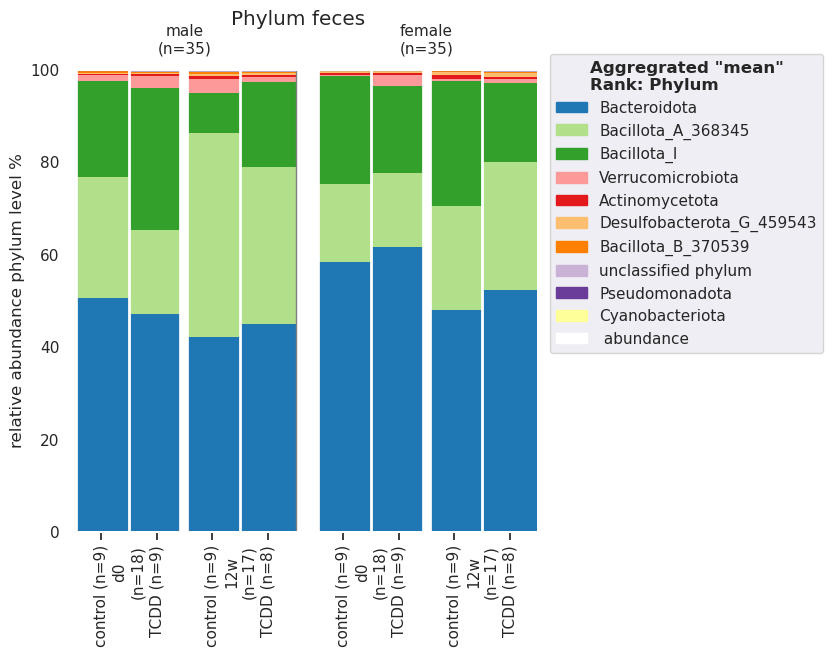

In [25]:
p = plotTaxonomy(res_feces['rarefaction']['results'],
                 prj_data['metadata'].sort_values(by=['sex', 'condition'], ascending=[False, False]), 
                 rank='Phylum', file_taxonomy=res_feces['taxonomy']['RDP']['results']['Taxon'],
                 group_l0='sex', group_l1='timepoint', group_l2='condition',
                 fct_aggregate=np.mean, 
                 horizontal_spacer=[0.35, 0.07, 0.02],
                 legend_remove_rank_prefix=True,
                 #reorder_samples=False
                 colors=colors_phyla,
                 print_sample_labels=True,
                )
colors_phyla = p[4]
p[0].get_axes()[0].set_ylabel('relative abundance phylum level %')
p[0].get_axes()[0].set_yticklabels(map(lambda x: '%01.f' % (x*100), p[0].get_axes()[0].get_yticks()))
p[0].suptitle('Phylum feces')
p[0].set_size_inches((6, 6))
#_savefig(p[0], 'figSx_panelA')

### Panel B

11 taxa left after collapsing to Phylum.
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

12w_control vs. 12w_TCDD: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.626e-01 U_stat=3.500e+01
d0_control vs. d0_TCDD: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:9.296e-01 U_stat=3.900e+01
d0_TCDD vs. 12w_control: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.333e-01 U_stat=2.300e+01
d0_control vs. 12w_control: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.333e-01 U_stat=2.300e+01
d0_TCDD vs. 12w_TCDD: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.414e-01 U_stat=2.900e+01
d0_control vs. 12w_TCDD: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:4.234e-01 U_stat=2.

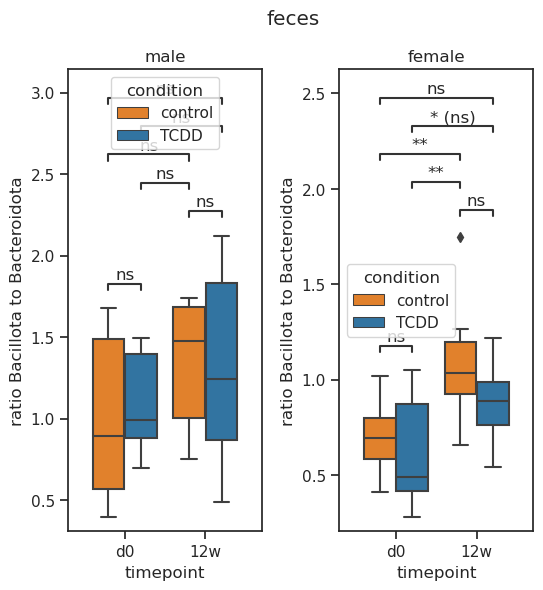

In [29]:
sns.set_style('ticks')

rank_counts = collapseCounts_objects(res_feces['rarefaction']['results'], 'Phylum', res_feces['taxonomy']['RDP']['results']['Taxon'])[0]
ratio_Bacillota_Bacteroidota = (rank_counts.loc[[p for p in rank_counts.index if p.startswith('p__Bacillota')], :].sum(axis=0) / rank_counts.loc[['p__Bacteroidota'], :].sum(axis=0))
ratio_Bacillota_Bacteroidota.name = 'ratio Bacillota to Bacteroidota'

fig, axes = plt.subplots(1,2, figsize=(6, 6))
sns.set_style('ticks')
plt.subplots_adjust(wspace=0.4)
hue_order = ['control', 'TCDD']
for ax, (sex, g) in zip(axes, prj_data['metadata'].merge(ratio_Bacillota_Bacteroidota, left_index=True, right_index=True).sort_values(by=['sex'], ascending=[False]).groupby('sex', sort=False)):
    sns.boxplot(data=g, ax=ax,
                y=ratio_Bacillota_Bacteroidota.name, x='timepoint', hue='condition', hue_order=ORDERS['condition'], order=ORDERS['timepoint'], palette=COLORS_CONDITIONS)
    ax.set_title(sex)

    annotator = Annotator(ax, [
        (('d0', 'control'), ('d0', 'TCDD')),
        (('12w', 'control'), ('12w', 'TCDD')),

        (('d0', 'control'), ('12w', 'control')),
        (('d0', 'TCDD'), ('12w', 'TCDD')),

        (('d0', 'TCDD'), ('12w', 'control')),
        (('d0', 'control'), ('12w', 'TCDD')),
        
            ], data=g, y=ratio_Bacillota_Bacteroidota.name, hue='condition', x='timepoint', hue_order=ORDERS['condition'], order=ORDERS['timepoint'])
        
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="fdr_bh", correction_format="default")
    annotator.apply_and_annotate()
fig.suptitle('feces')
#_savefig(fig, 'figSx_panelB')

### Panel C

10 taxa left after collapsing to Phylum.
36 samples left with metadata and counts.
raw counts: 36
raw meta: 172
meta with counts: 4 samples x 4 fields
counts with meta: 4


/tmp/ipykernel_1103567/1370871956.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  p[0].get_axes()[0].set_yticklabels(map(lambda x: '%01.f' % (x*100), p[0].get_axes()[0].get_yticks()))


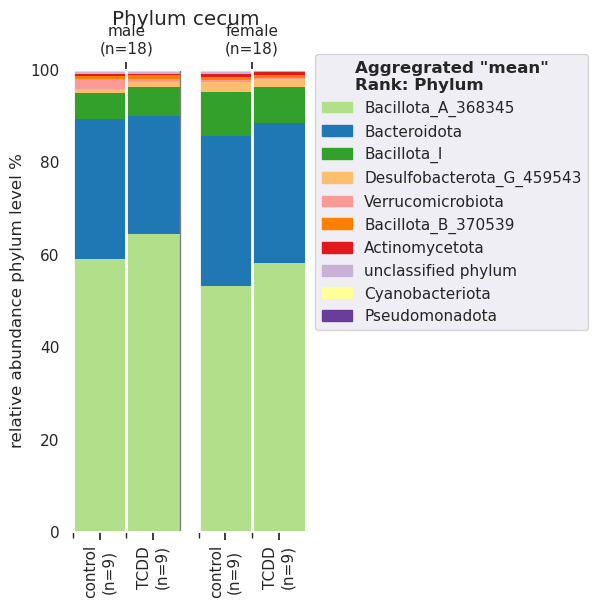

In [30]:
p = plotTaxonomy(res_cecal['rarefaction']['results'],
                 prj_data['metadata'].sort_values(by=['sex', 'condition'], ascending=[False, False]), 
                 rank='Phylum', file_taxonomy=res_cecal['taxonomy']['RDP']['results']['Taxon'],
                 group_l0='sex', group_l1='condition', #group_l2='condition',
                 fct_aggregate=np.mean, 
                 horizontal_spacer=[0.35, 0.02, None],
                 legend_remove_rank_prefix=True,
                 #reorder_samples=False
                 colors=colors_phyla,
                 #print_sample_labels=True,
                )
colors_phyla = p[4]
p[0].get_axes()[0].set_ylabel('relative abundance phylum level %')
p[0].get_axes()[0].set_yticklabels(map(lambda x: '%01.f' % (x*100), p[0].get_axes()[0].get_yticks()))
p[0].suptitle('Phylum cecum')
p[0].set_size_inches((3, 6))
#_savefig(p[0], 'figSx_panelC')

### Panel D

10 taxa left after collapsing to Phylum.
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

female_control vs. female_TCDD: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.164e-01 U_stat=2.600e+01
male_control vs. male_TCDD: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.120e-01 U_stat=2.200e+01
male_TCDD vs. female_control: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.998e-03 U_stat=7.600e+01
male_control vs. female_control: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.365e-01 U_stat=4.800e+01
male_TCDD vs. female_TCDD: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:5.206e-02 U_stat=6.300e+01
male_control vs. female_TCDD: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correct

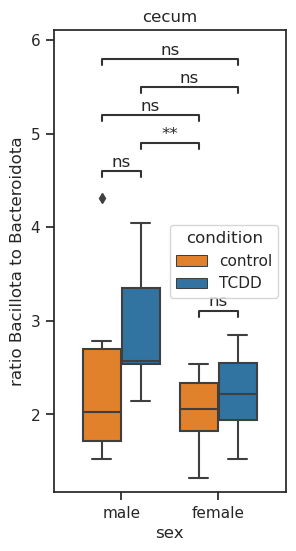

In [32]:
sns.set_style('ticks')

rank_counts = collapseCounts_objects(res_cecal['rarefaction']['results'], 'Phylum', res_cecal['taxonomy']['RDP']['results']['Taxon'])[0]
ratio_Bacillota_Bacteroidota = (rank_counts.loc[[p for p in rank_counts.index if p.startswith('p__Bacillota')], :].sum(axis=0) / rank_counts.loc[['p__Bacteroidota'], :].sum(axis=0))
ratio_Bacillota_Bacteroidota.name = 'ratio Bacillota to Bacteroidota'

fig, axes = plt.subplots(1,1, figsize=(3, 6))
sns.set_style('ticks')
plt.subplots_adjust(wspace=0.4)
hue_order = ['ctrl', 'TCDD']
for ax, (sex, g) in zip([axes], prj_data['metadata'].merge(ratio_Bacillota_Bacteroidota, left_index=True, right_index=True).sort_values(by=['sex'], ascending=[False]).groupby('timepoint', sort=False)):
    sns.boxplot(data=g, ax=ax,
                y=ratio_Bacillota_Bacteroidota.name, x='sex', hue='condition', hue_order=ORDERS['condition'], palette=COLORS_CONDITIONS),
    ax.set_title('cecum')

    annotator = Annotator(ax, [
        (('male', 'control'), ('male', 'TCDD')),
        (('female', 'control'), ('female', 'TCDD')),

        (('male', 'control'), ('female', 'control')),
        (('male', 'TCDD'), ('female', 'TCDD')),

        (('male', 'TCDD'), ('female', 'control')),
        (('male', 'control'), ('female', 'TCDD')),
        
            ], data=g, y=ratio_Bacillota_Bacteroidota.name, hue='condition', x='sex', hue_order=ORDERS['condition'])
        
    annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="fdr_bh", correction_format="default")
    annotator.apply_and_annotate()
#fig.suptitle('cecum')
#_savefig(fig, 'figSx_panelD')

# Further Analyses

In [96]:
dms = dict()
for (bodysite, beta) in [('feces', res_feces['beta_diversity']['results']),
                         ('cecum', res_cecal['beta_diversity']['results'])]:
    for metric in beta.keys():
        dms[(bodysite, metric)] = beta[metric].to_data_frame()

In [97]:
data = []

# strict within cage comparisons
for (bs, tp, cage), g in prj_data['metadata'].groupby(['bodysite', 'timepoint', 'host_cageid']):
    for (bs_beta, metric) in dms.keys():
        if bs == bs_beta:
            avail_idx = set(g.index) & set(dms[(bs_beta, metric)].index)
            for a, b in combinations(list(avail_idx), 2):
                data.append([bs, tp, cage, 'const_bs_tp_sex__intra_cage', a, b, dms[(bs_beta, metric)].loc[a, b], metric, 
                             g.loc[[a,b], 'sex'].unique()[0],
                             g.loc[[a,b], 'condition'].unique()[0]
                            ])

# across cages, but within same bodysite, sex, timepoint and condition
for (bs, sex, tp, cond), g in prj_data['metadata'].groupby(['bodysite', 'sex', 'timepoint', 'condition']):
    for (bs_beta, metric) in dms.keys():
        if bs == bs_beta:
            avail_idx = set(g.index) & set(dms[(bs_beta, metric)].index)
            for a, b in combinations(list(avail_idx), 2):
                data.append([bs, tp, cage, 'const_bs_tp_sex_cond__acrossCages', a, b, dms[(bs_beta, metric)].loc[a, b], metric, sex, cond])

# beta change over time per animal
for (bs, cage, sex, condition, animalID), g in prj_data['metadata'].groupby(['bodysite', 'host_cageid', 'sex', 'condition', 'host_subject_id']):
    for (bs_beta, metric) in dms.keys():
            if bs == bs_beta:
                avail_idx = set(g.index) & set(dms[(bs_beta, metric)].index)
                for a, b in combinations(list(avail_idx), 2):
                    data.append([bs, 'd0 to 12w', cage, 'deriv_animalID_time', a, b, dms[(bs_beta, metric)].loc[a, b], metric, sex, condition])

if False:
    for (bs, tp, cage), g in prj_data['metadata'].groupby(['bodysite', 'timepoint', 'sex']):
        for (bs_beta, metric) in dms.keys():
            if bs == bs_beta:
                avail_idx = set(g.index) & set(dms[(bs_beta, metric)].index)
                for a, b in combinations(list(avail_idx), 2):
                    if g.loc[[a, b], 'host_cageid'].unique().shape[0] < 2:
                        continue
                    data.append([bs, tp, cage, 'const_bs_tp_sex__inter_cage', a, b, dms[(bs_beta, metric)].loc[a, b], metric, 
                                 g.loc[[a, b], 'sex'].unique()[0],
                                 g.loc[[a, b], 'condition'].unique()[0]
                                ])

data = pd.DataFrame(data, columns=['bodysite', 'timepoint', 'host_cageid', 'cmp', 'idx_a', 'idx_b', 'distance', 'metric', 'sex', 'condition'])
#data = data[data['metric'] == 'unweighted_unifrac']

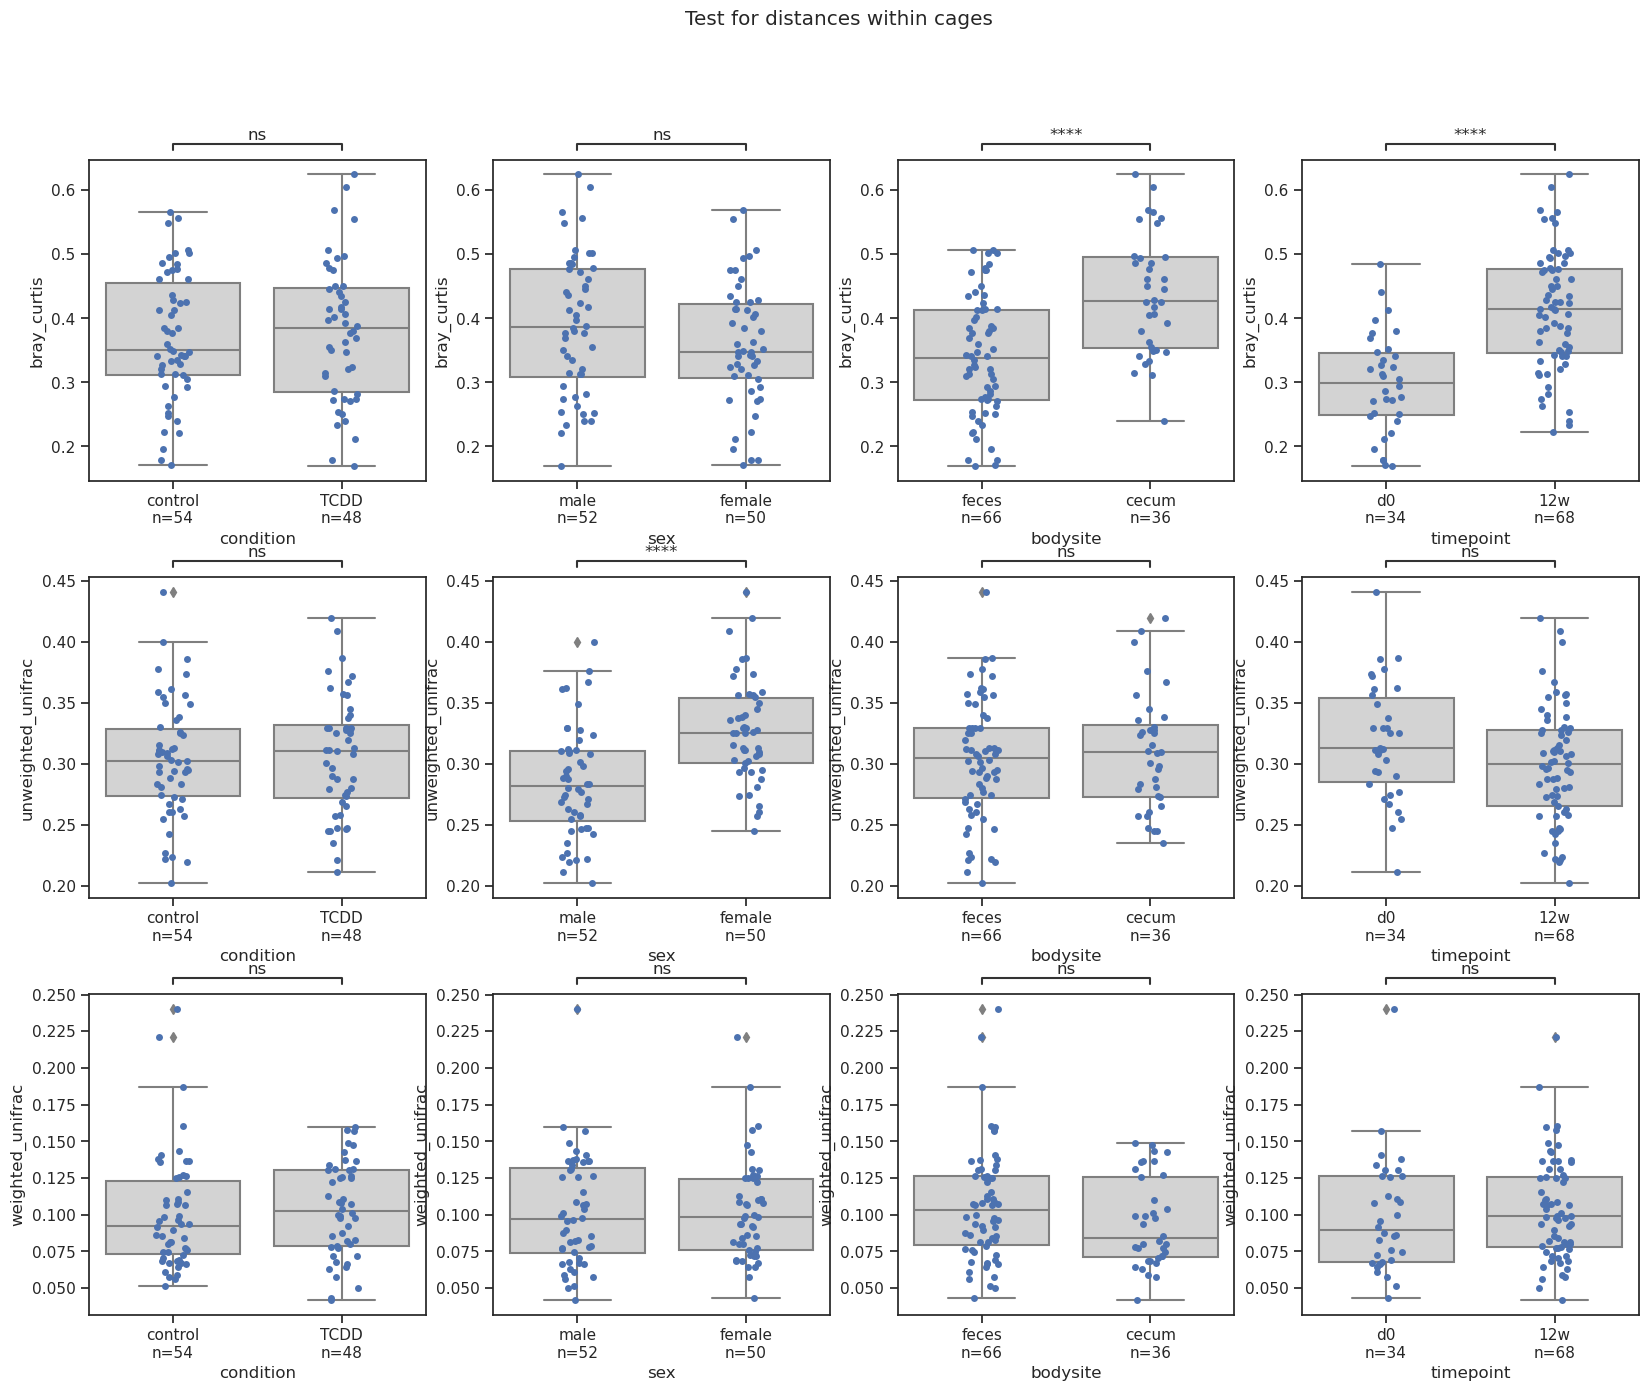

In [98]:
plotdata = data[data['cmp'] == 'const_bs_tp_sex__intra_cage']

fields = ['condition', 'sex', 'bodysite', 'timepoint']
fig, axes = plt.subplots(data['metric'].unique().shape[0], len(fields), figsize=(5*len(fields), 5*data['metric'].unique().shape[0]))
fig.subplots_adjust(hspace=0.3)
y = 'distance'

for (ax_row, (metric, metric_data)) in zip(axes, plotdata.groupby('metric')):
    for ax, field in zip(ax_row, fields):
        order = [x for x in ORDERS[field] if x in list(metric_data[field].unique())]
        
        sns.boxplot(data=metric_data, y=y, x=field, ax=ax, order=order, color='lightgray')
        sns.stripplot(data=metric_data, y=y, x=field, ax=ax, order=order)
        ax.set_ylabel(metric)

        if len(order) >= 2:
            annotator = Annotator(ax, [tuple(order)], data=metric_data, y=y, x=field, order=order)
            annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction="fdr_bh", correction_format="default", verbose=False)
            annotator.apply_and_annotate()

        num_data = metric_data.groupby(field).size()
        ax.set_xticks(ax.get_xticks(), ['%s\nn=%i' % (t.get_text(), num_data.loc[t.get_text()]) for t in ax.get_xticklabels()])
    
_ = fig.suptitle('Test for distances within cages')

In [111]:
def plot_level2(field, subfields, data, cross_sub='no', addlabel="", return_figure=False):
    COLORS_SEX = {'female': ['#f9ecf9ff', '#f3d8f3ff'],
                  'male': ['#ebebf9ff', '#d8d8f3ff']}
    fields = [f for f in subfields if f != field]
    fig, axes = plt.subplots(data['metric'].unique().shape[0], len(fields), figsize=((5 / 2 * len(data[field].unique()))*len(fields), 5*data['metric'].unique().shape[0]))
    fig.subplots_adjust(hspace=0.3)
    y = 'distance'

    if data['metric'].unique().shape[0] <= 1:
        axes = [axes]
    for (ax_row, (metric, metric_data)) in zip(axes, data.groupby('metric')):
        if len(fields) <= 1:
            ax_row = [ax_row]
        for ax, subfield in zip(ax_row, fields):
            hue_order = [x for x in ORDERS[subfield] if x in list(metric_data[subfield].unique())]
            order = [x for x in ORDERS[field] if x in list(metric_data[field].unique())]
            
            color, palette = 'lightgray', None
            if (subfield != 'sex') & (field != 'sex') & (metric_data['sex'].unique().shape[0] < 2):
                color, palette = None, COLORS_SEX.get(''.join(metric_data['sex'].unique()))
            #if field == 'sex':
            #    print(hue_order, order)
            #    color, palette = None, {a: COLORS_SEX['f'][1] for a in hue_order}
            #    color, palette = None, {f"{sex}-{a}": COLORS_SEX[sex][hue_order.index(a)] for a in hue_order for sex in order}
            #    print(palette, color)
                
            #if subfield == 'sex':
            sns.boxplot(data=metric_data, y=y, x=field, hue=subfield, ax=ax, order=order, hue_order=hue_order, color=color, palette=palette)
            sns.stripplot(data=metric_data, y=y, x=field, hue=subfield, ax=ax, order=order, hue_order=hue_order, dodge=True)
            ax.set_ylabel(metric)
            
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles[-1 * int(len(handles)/2):], labels[-1 * int(len(labels)/2):])

            cmps = []
            if cross_sub in ['no', 'both']:
                cmps.extend([((x, hue_order[0]), (x, hue_order[1])) for x in order if metric_data[metric_data[field] == x][subfield].unique().shape[0] >= 2])
            if cross_sub == 'yes':
                cmps = []
            if cross_sub in ['yes', 'both']:
                cmps.extend([((order[0], y), (order[1], y)) for y in hue_order])
            annotator = Annotator(ax, cmps, 
                                  data=metric_data, y=y, x=field, order=order, hue=subfield, hue_order=hue_order)
            annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', comparisons_correction="fdr_bh", correction_format="default", verbose=False)
            annotator.apply_and_annotate()

            num_data = metric_data.groupby([field, subfield]).size().to_dict()
            ax.set_xticks(ax.get_xticks(), ['%s\nn=%i, %i' % tuple([t.get_text()] + [num_data.get((t.get_text(), sf), 0) for sf in hue_order]) for t in ax.get_xticklabels()])
        
    _ = fig.suptitle('%s%s: Test for distances within cages' % (addlabel, field.upper()))
    if return_figure:
        return fig

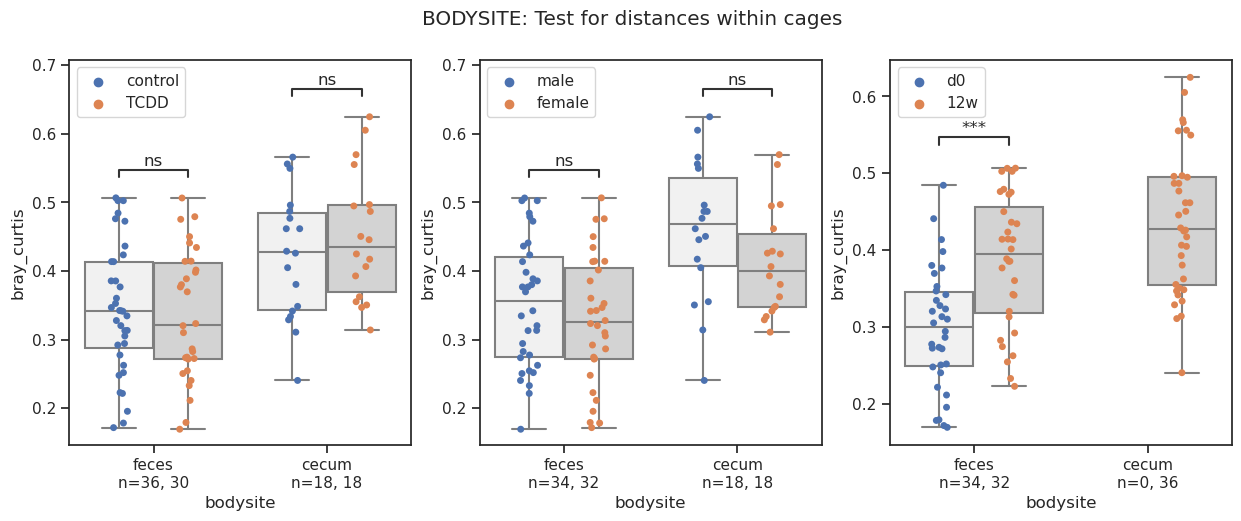

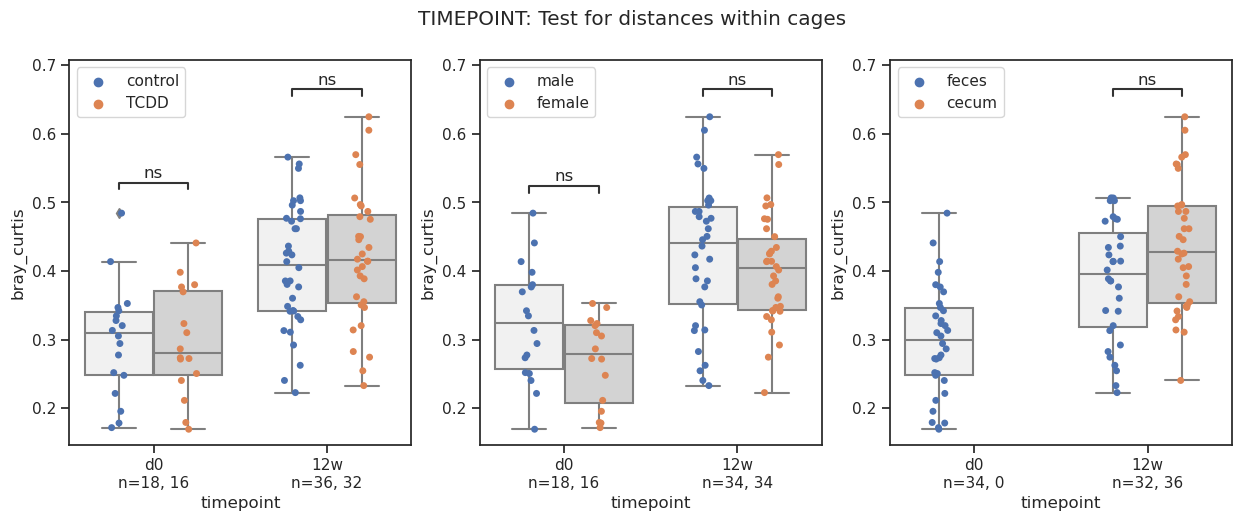

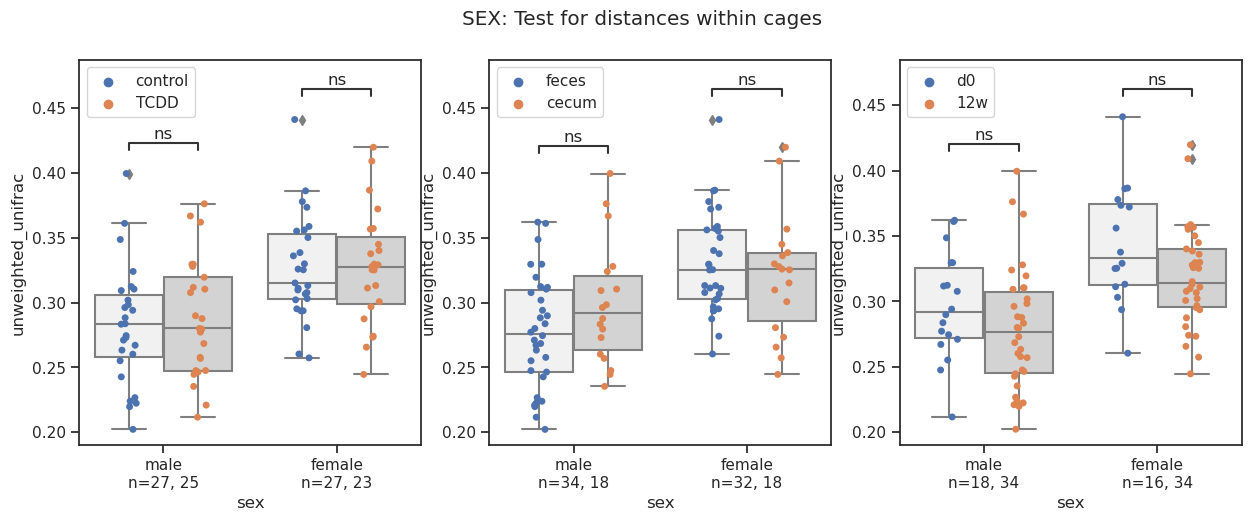

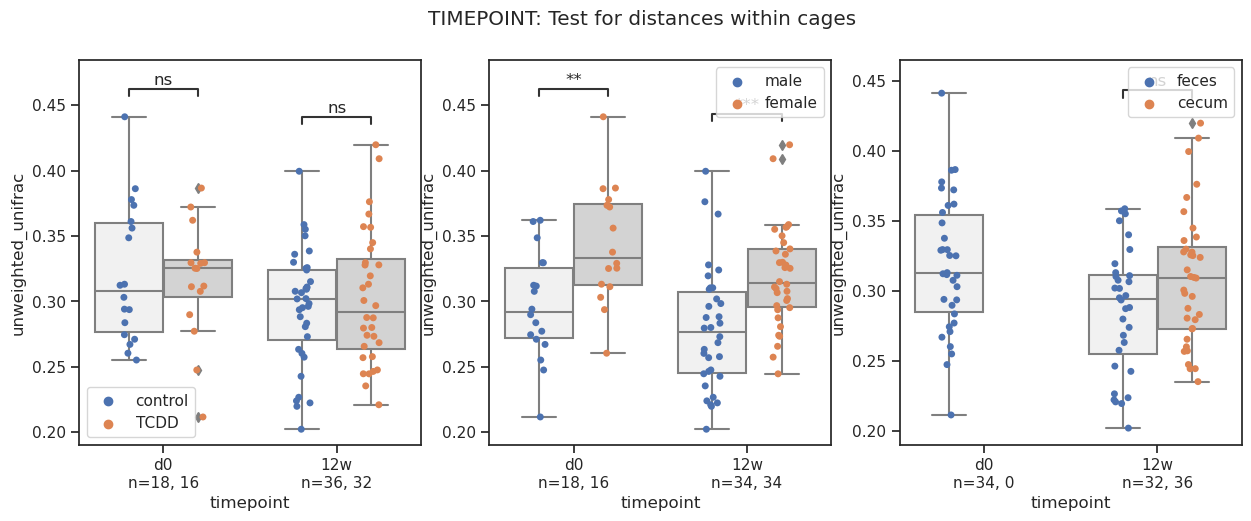

In [100]:
plotdata = data[(data['cmp'] == 'const_bs_tp_sex__intra_cage') & (data['metric'] == 'bray_curtis')]
plot_level2('bodysite', ['condition', 'sex', 'bodysite', 'timepoint'], plotdata)
plot_level2('timepoint', ['condition', 'sex', 'bodysite', 'timepoint'], plotdata)

plotdata = data[(data['cmp'] == 'const_bs_tp_sex__intra_cage') & (data['metric'] == 'unweighted_unifrac')]
plot_level2('sex', ['condition', 'sex', 'bodysite', 'timepoint'], plotdata)
plot_level2('timepoint', ['condition', 'sex', 'bodysite', 'timepoint'], plotdata)

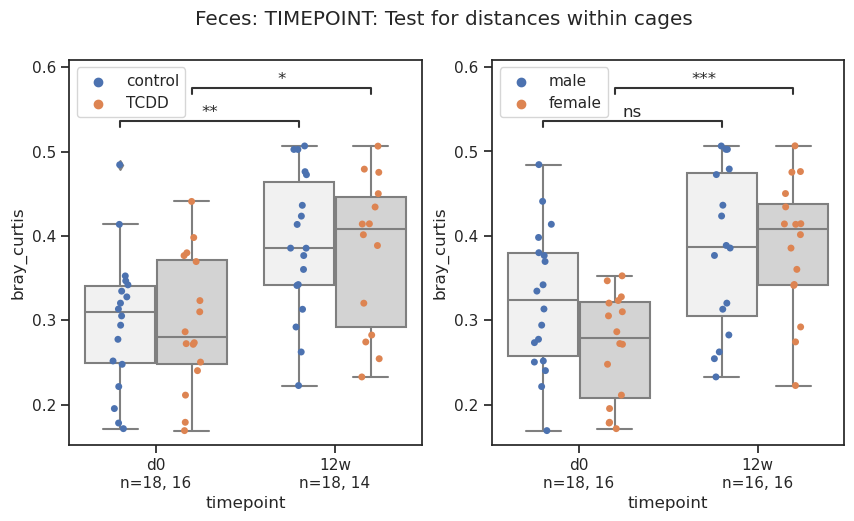

In [101]:
plotdata = data[(data['cmp'] == 'const_bs_tp_sex__intra_cage') & (data['metric'] == 'bray_curtis') & (data['bodysite'] == 'feces')]
x = plot_level2('timepoint', ['condition', 'sex'], plotdata, cross_sub='yes', addlabel='Feces: ')

In [102]:
plotdata[(plotdata['timepoint'] == 'd0') &  (plotdata['condition'] == 'control') & (plotdata['metric'] == 'bray_curtis') ].sort_values(by='distance')

bodysite timepoint host_cageid                          cmp  \
304    feces        d0           9  const_bs_tp_sex__intra_cage   
286    feces        d0           7  const_bs_tp_sex__intra_cage   
295    feces        d0           8  const_bs_tp_sex__intra_cage   
242    feces        d0           2  const_bs_tp_sex__intra_cage   
303    feces        d0           9  const_bs_tp_sex__intra_cage   
241    feces        d0           2  const_bs_tp_sex__intra_cage   
249    feces        d0           3  const_bs_tp_sex__intra_cage   
250    feces        d0           3  const_bs_tp_sex__intra_cage   
285    feces        d0           7  const_bs_tp_sex__intra_cage   
240    feces        d0           2  const_bs_tp_sex__intra_cage   
296    feces        d0           8  const_bs_tp_sex__intra_cage   
305    feces        d0           9  const_bs_tp_sex__intra_cage   
251    feces        d0           3  const_bs_tp_sex__intra_cage   
210    feces        d0           1  const_bs_tp_sex__intra_cage   
294    feces        d0           8  const_bs_tp_sex__intra_cage   
287    feces        d0           7  const_bs_tp_sex__intra_cage   
212    feces        d0           1  const_bs_tp_sex__intra_cage   
211    feces        d0           1  const_bs_tp_sex__intra_cage   

             idx_a          idx_b  distance       metric     sex condition  
304  15900.s26.S26  15900.s27.S27  0.171600  bray_curtis  female   control  
286  15900.s19.S19  15900.s21.S21  0.178267  bray_curtis  female   control  
295  15900.s24.S24  15900.s23.S23  0.195400  bray_curtis  female   control  
242    15900.s5.S5    15900.s4.S4  0.221467  bray_curtis    male   control  
303  15900.s26.S26  15900.s25.S25  0.247867  bray_curtis  female   control  
241    15900.s6.S6    15900.s4.S4  0.251800  bray_curtis    male   control  
249    15900.s8.S8    15900.s9.S9  0.277467  bray_curtis    male   control  
250    15900.s8.S8    15900.s7.S7  0.294200  bray_curtis    male   control  
285  15900.s19.S19  15900.s20.S20  0.305200  bray_curtis  female   control  
240    15900.s6.S6    15900.s5.S5  0.313333  bray_curtis    male   control  
296  15900.s22.S22  15900.s23.S23  0.320333  bray_curtis  female   control  
305  15900.s25.S25  15900.s27.S27  0.327733  bray_curtis  female   control  
251    15900.s9.S9    15900.s7.S7  0.334533  bray_curtis    male   control  
210    15900.s2.S2    15900.s3.S3  0.342000  bray_curtis    male   control  
294  15900.s24.S24  15900.s22.S22  0.346733  bray_curtis  female   control  
287  15900.s20.S20  15900.s21.S21  0.352600  bray_curtis  female   control  
212    15900.s3.S3    15900.s1.S1  0.413667  bray_curtis    male   control  
211    15900.s2.S2    15900.s1.S1  0.484333  bray_curtis    male   control

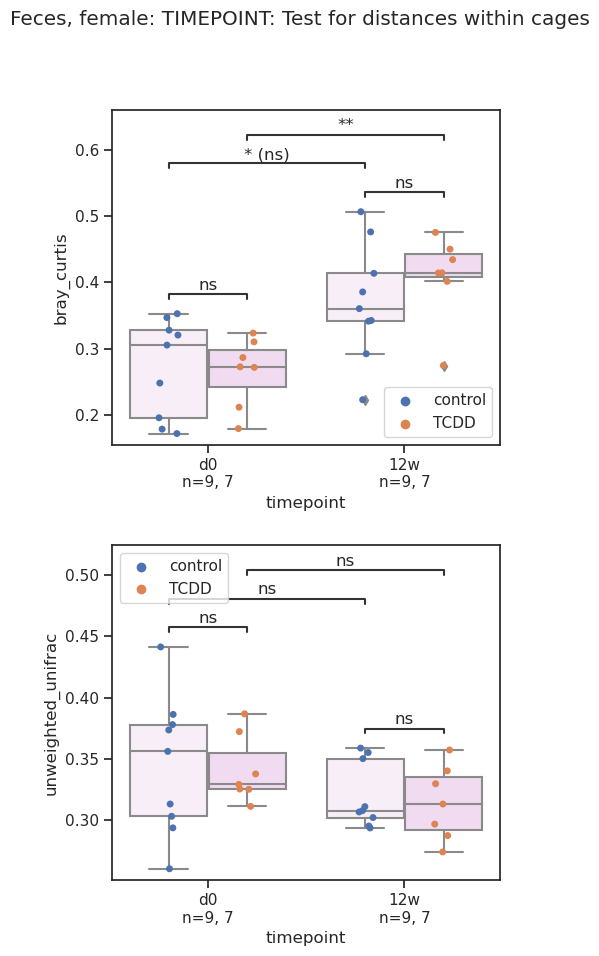

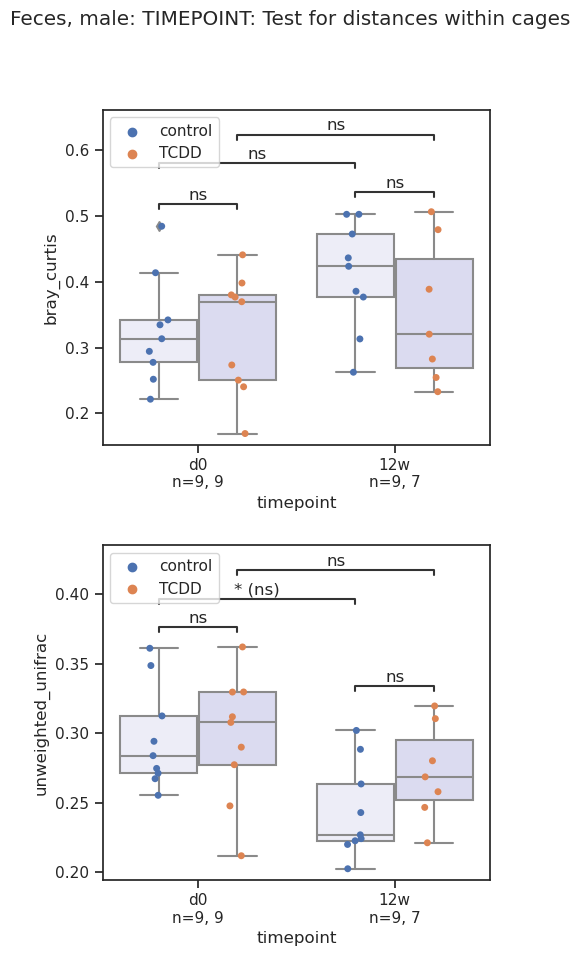

In [123]:
plotdata = data[(data['cmp'] == 'const_bs_tp_sex__intra_cage') & (data['metric'].isin(['bray_curtis', 'unweighted_unifrac'])) & (data['bodysite'] == 'feces') & (data['sex'] == 'female')]
x = plot_level2('timepoint', ['condition'], plotdata, cross_sub='both', addlabel='Feces, female: ', return_figure=True)
#x.savefig('Generated/Figures/SVG/control_check_allonecage.svg')
_savefig(x, 'figS6_panelAB_feces_female')

plotdata = data[(data['cmp'] == 'const_bs_tp_sex__intra_cage') & (data['metric'].isin(['bray_curtis', 'unweighted_unifrac'])) & (data['bodysite'] == 'feces') & (data['sex'] == 'male')]
x = plot_level2('timepoint', ['condition'], plotdata, cross_sub='both', addlabel='Feces, male: ', return_figure=True)
_savefig(x, 'figS6_panelAB_feces_male')

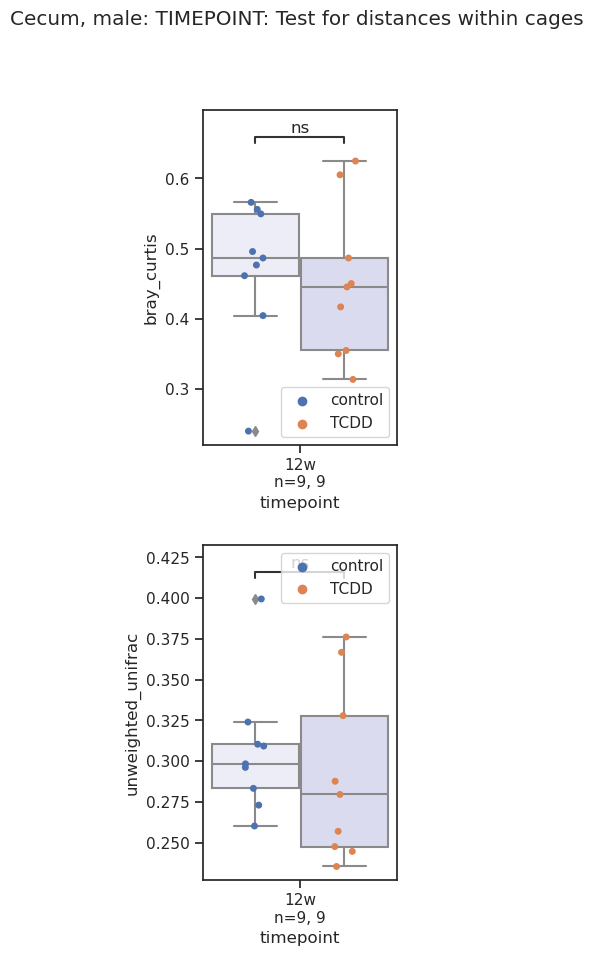

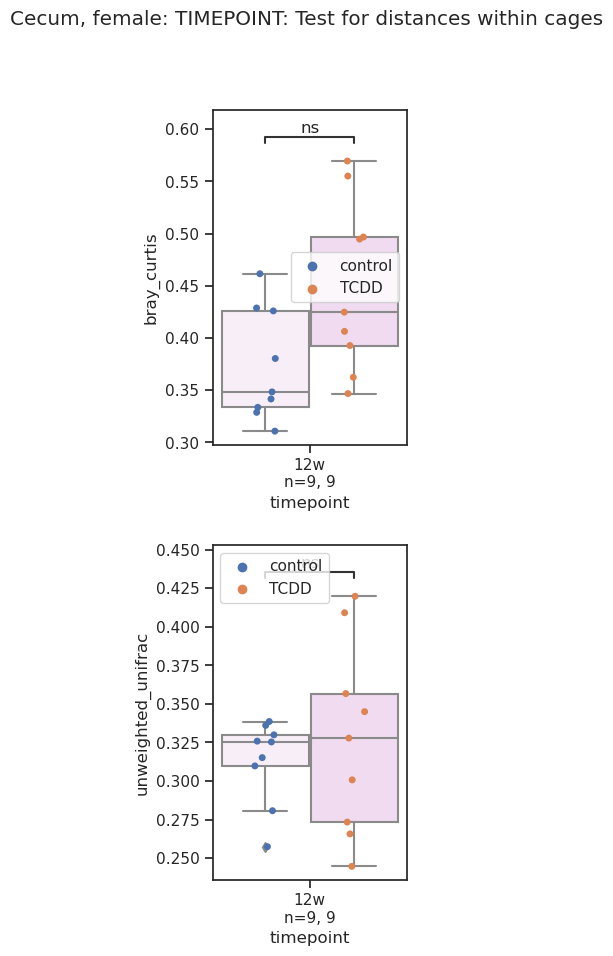

In [122]:
plotdata = data[(data['cmp'] == 'const_bs_tp_sex__intra_cage') & (data['metric'].isin(['bray_curtis', 'unweighted_unifrac'])) & (data['bodysite'] == 'cecum') & (data['sex'] == 'male')]
x = plot_level2('timepoint', ['condition'], plotdata, cross_sub='no', addlabel='Cecum, male: ', return_figure=True)
_savefig(x, 'figS6_panelX_cecum_male')

plotdata = data[(data['cmp'] == 'const_bs_tp_sex__intra_cage') & (data['metric'].isin(['bray_curtis', 'unweighted_unifrac'])) & (data['bodysite'] == 'cecum') & (data['sex'] == 'female')]
x = plot_level2('timepoint', ['condition'], plotdata, cross_sub='no', addlabel='Cecum, female: ', return_figure=True)
_savefig(x, 'figS6_panelY_cecum_female')

## Beta, across cages within same time, bodysite, condition and sex

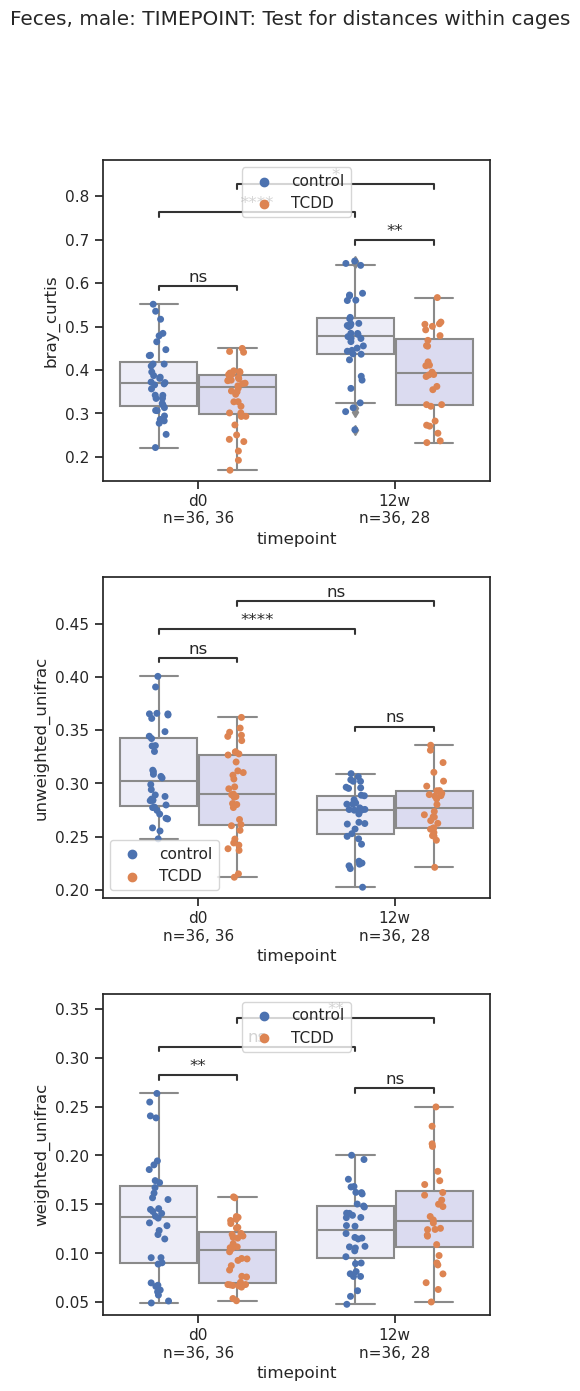

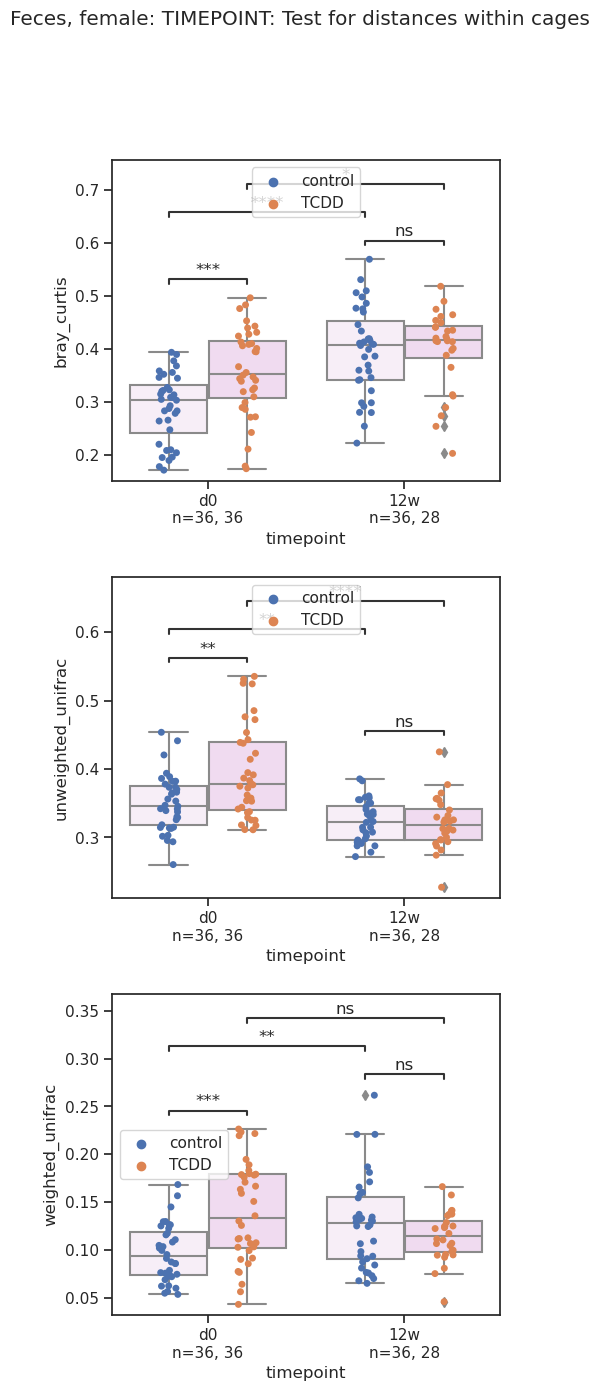

In [41]:
plotdata = data[(data['cmp'] == 'const_bs_tp_sex_cond__acrossCages') & (data['bodysite'] == 'feces') & (data['sex'] == 'male')]
x = plot_level2('timepoint', ['condition'], plotdata, cross_sub='both', addlabel='Feces, male: ')

plotdata = data[(data['cmp'] == 'const_bs_tp_sex_cond__acrossCages') & (data['bodysite'] == 'feces') & (data['sex'] == 'female')]
x = plot_level2('timepoint', ['condition'], plotdata, cross_sub='both', addlabel='Feces, female: ')


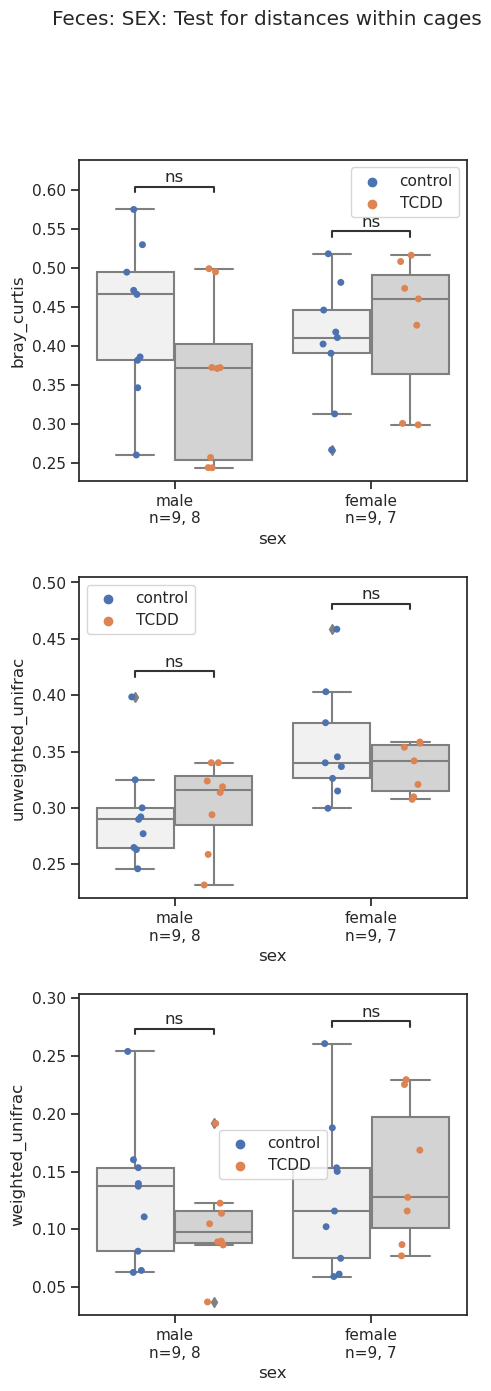

In [42]:
plotdata = data[(data['cmp'] == 'deriv_animalID_time') & (data['bodysite'] == 'feces')]
x = plot_level2('sex', ['condition'], plotdata, cross_sub='no', addlabel='Feces: ')


In [ ]:
print('10 iterations for male at 12w with unweighted UniFrac')
for (sex, tp), g in prj_data['metadata'][prj_data['metadata']['bodysite'] == 'feces'].groupby(['sex', 'timepoint']):
    if sex != 'male':
        continue
    if tp != '12w':
        continue
    for i in range(10):
        x = plotNetworks('condition', g, alpha=None, beta=res_feces['beta_diversity']['results'], name=','.join([sex, tp]), summarize=True)
        #print(sex, tp)
        print((x[0][x[0]['metric'] == 'unweighted_unifrac']['p-value'].values)[0])
    #break

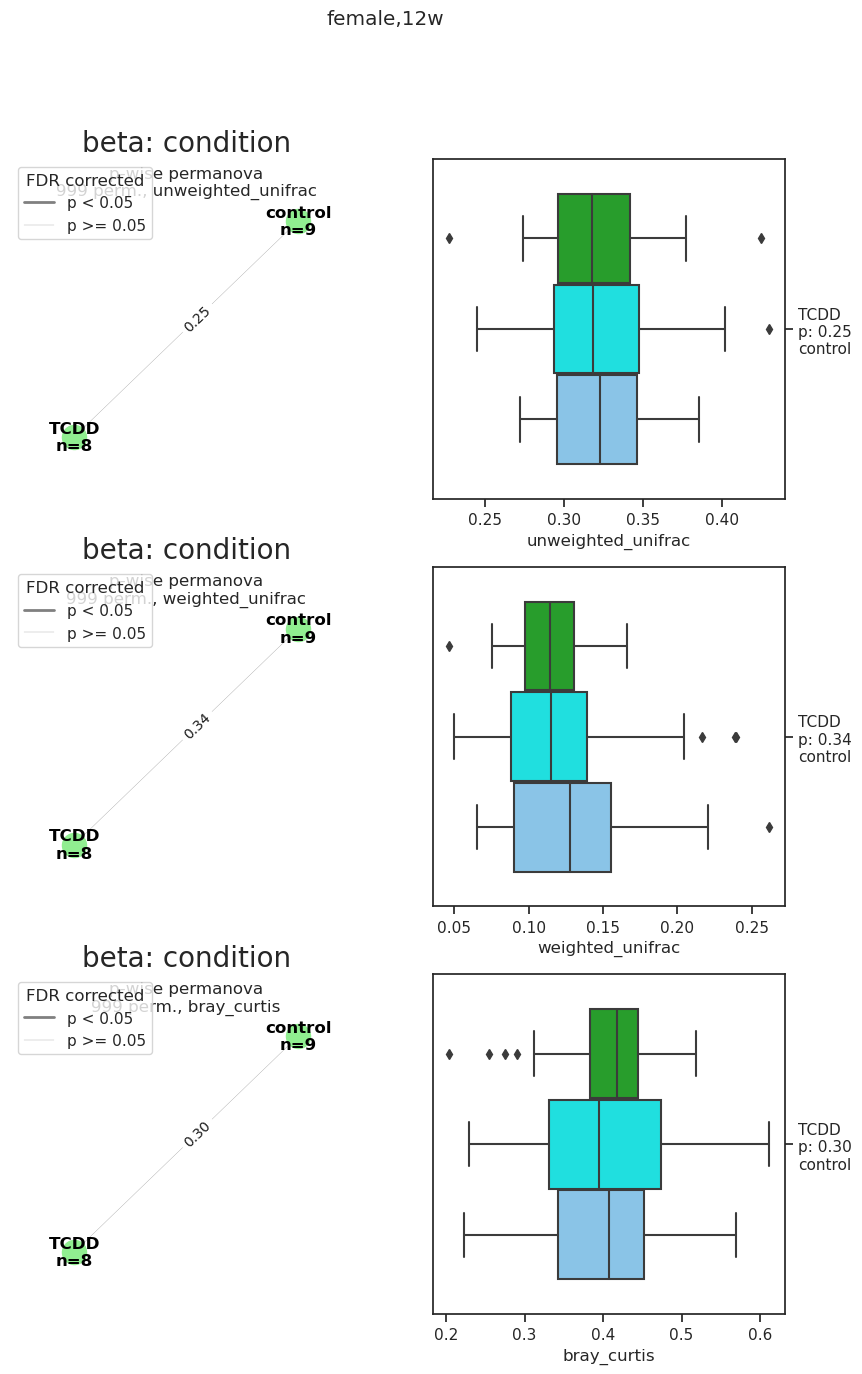

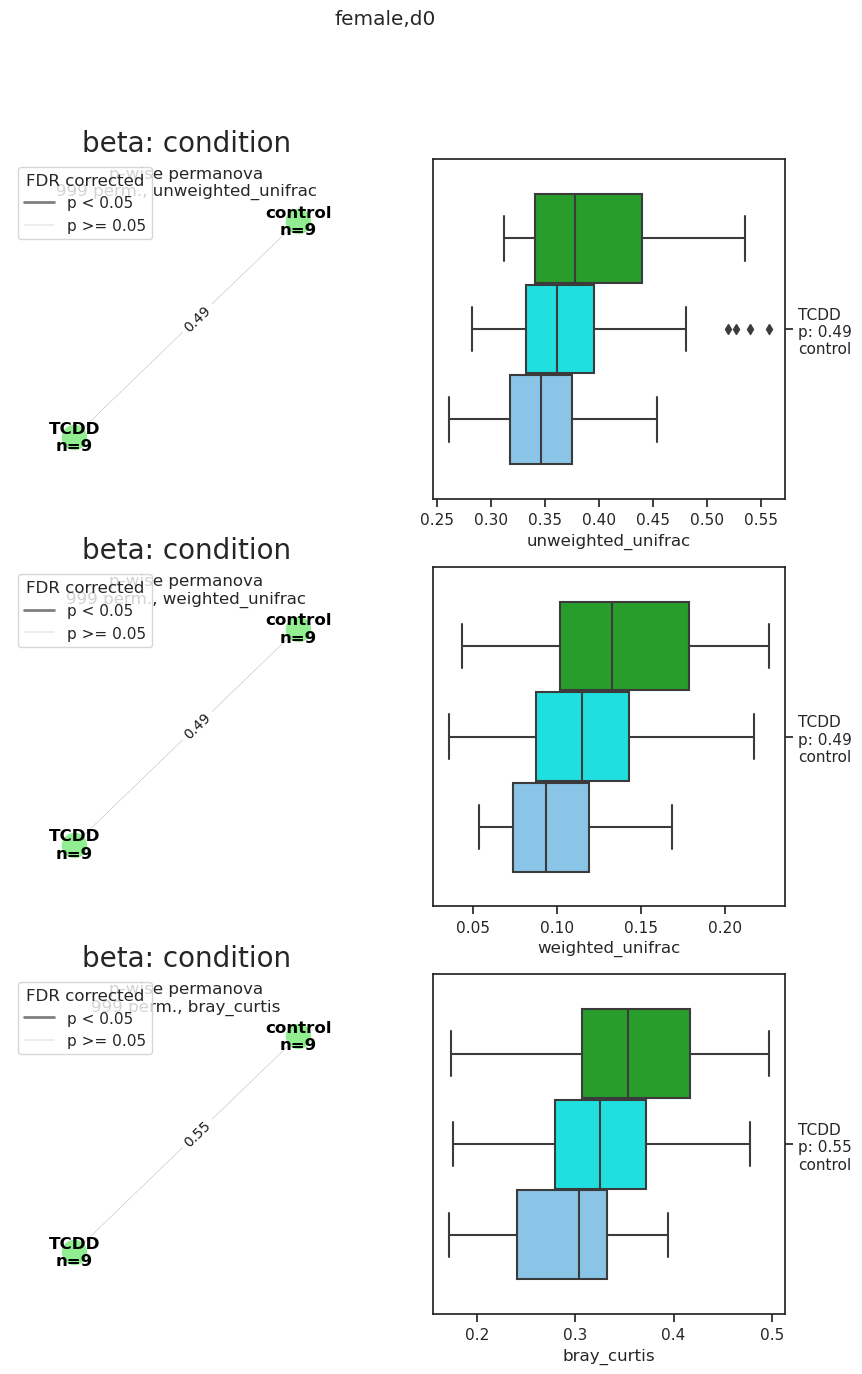

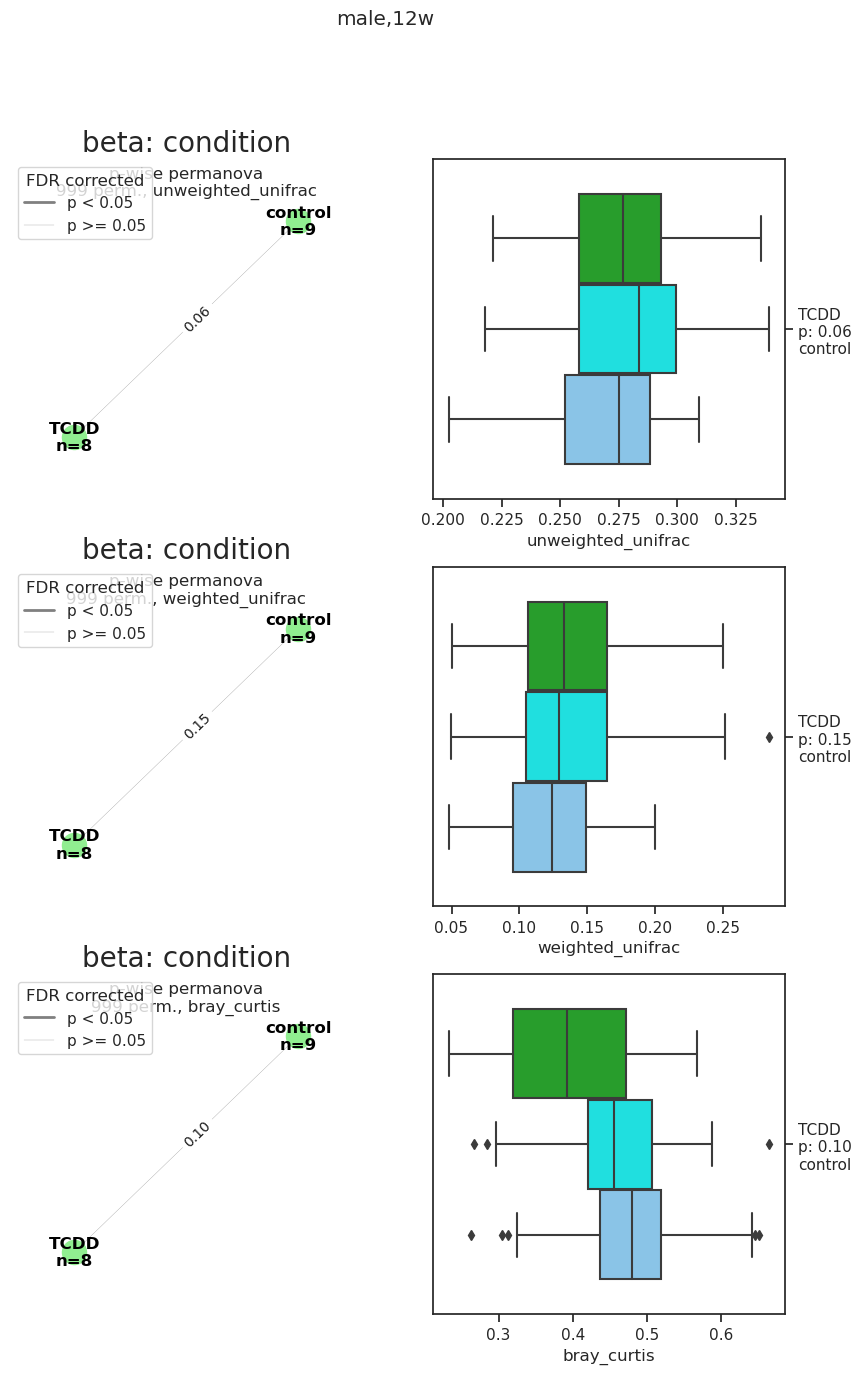

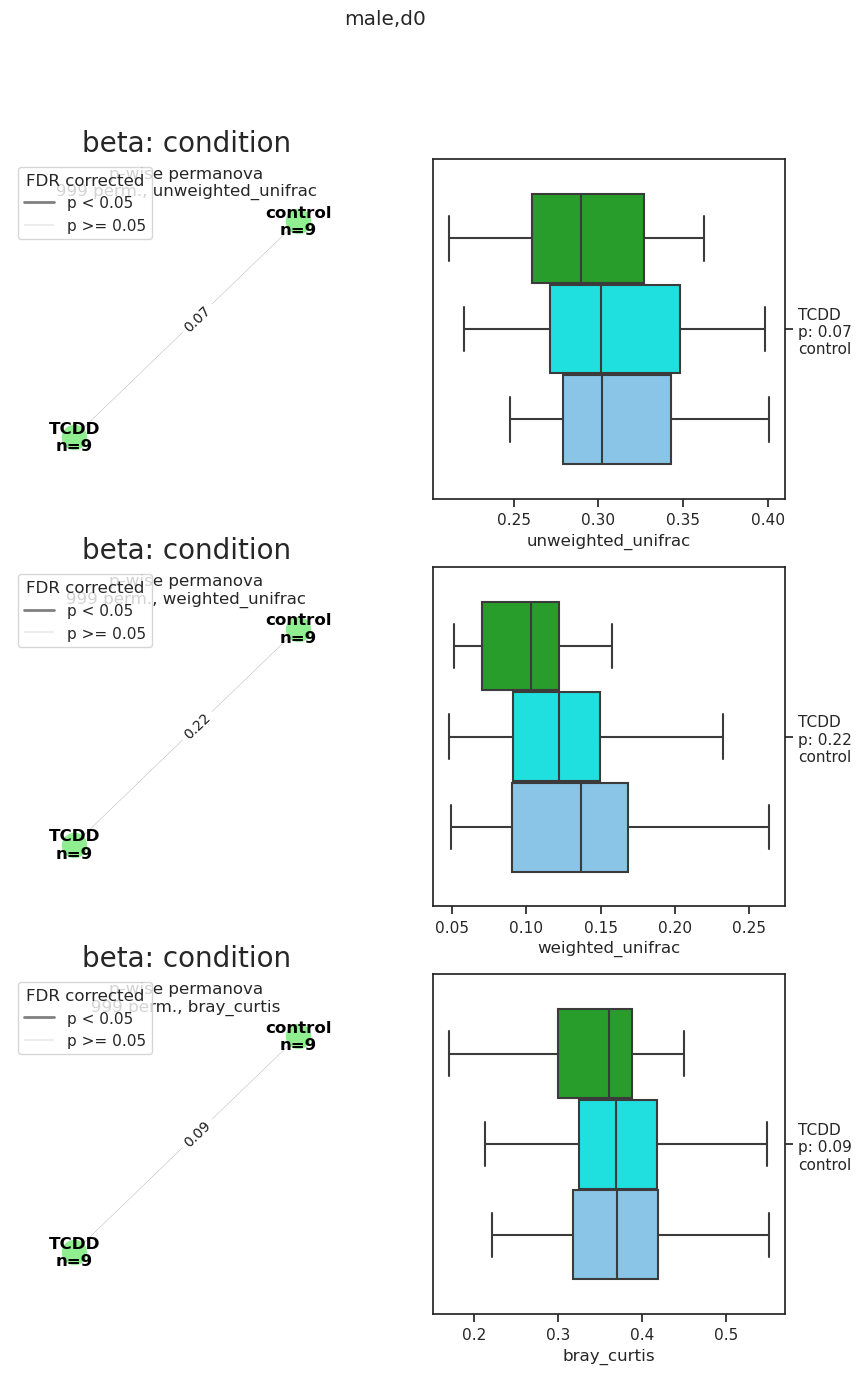

In [43]:
for (sex, tp), g in prj_data['metadata'][prj_data['metadata']['bodysite'] == 'feces'].groupby(['sex', 'timepoint']):
    x = plotNetworks('condition', g, alpha=None, beta=res_feces['beta_diversity']['results'], name=','.join([sex, tp]))

In [92]:
print("feces, 0d : male vs female")
display(plotNetworks('sex', prj_data['metadata'][prj_data['metadata']['timepoint'] == 'd0'], alpha=None, beta=res_feces['beta_diversity']['results'], summarize=True)[0].set_index('metric').loc['unweighted_unifrac', 'p-value'])

print("feces, 12w : male vs female")
display(plotNetworks('sex', prj_data['metadata'][prj_data['metadata']['timepoint'] == '12w'], alpha=None, beta=res_feces['beta_diversity']['results'], summarize=True)[0].set_index('metric').loc['unweighted_unifrac', 'p-value'])

print("cecal, 12w : male vs female")
display(plotNetworks('sex', prj_data['metadata'][prj_data['metadata']['timepoint'] == '12w'], alpha=None, beta=res_cecal['beta_diversity']['results'], summarize=True)[0].set_index('metric').loc['unweighted_unifrac', 'p-value'])


feces, 0d : male vs female


0.001

feces, 12w : male vs female


0.001

cecal, 12w : male vs female


0.001

## Differential Abundance
One typical line of investigation is the question for differentially abundant taxa between two groups of microbial samples. I suggest two alternative computational approaches for the very same question. 
  1. Ancom is the more conservative method (=if it reports taxa, they are probably really diff. abundant), 
  2. dsFDR is more liberal regarding correction for multiple hypothesis testing and less well accepted in the field, but reports more

124 taxa left after collapsing to Genus.


Reduced to 36 samples (feature-table had 70, metadata had 36 samples)
Using existing results from '.anacache/396d0c533d832b7631128bf550c7130f.ancom'. 


significantly different  >= 0.007000 mean rel. abundance  #Genus
2                     True                             True       1
1                    False                             True      16
0                    False                            False     107

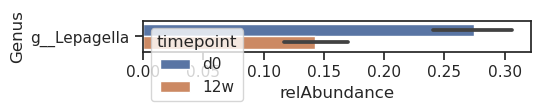

In [44]:
res_ancom = ancom(
    res_feces['rarefaction']['results'],  # you can in principle also start from a feature table NOT being rarefied, i.e. res_all['counts_plantsremoved']
    rank='Genus',  # feature table is collapsed at this taxonomic rank, as ANCOM struggles from too many features like individual ASVs. But try rank="raw" as well!
    taxonomy=res_feces['taxonomy']['RDP']['results']['Taxon'],
    grouping=prj_data['metadata'][(prj_data['metadata']['bodysite'] == 'feces') & (prj_data['metadata']['condition'] == 'control')]['timepoint'],  # the metadata column that groups all samples into two conditions
    dry=False, wait=False,
    # following are plotting parameters only, i.e. won't change/trigger a re-run
    min_mean_abundance_per_feature=0.007,
    post_cache_arguments={#'palette': {'B6J': 'blue', 'C': 'green'}, 
                          #'feature_order': list(name_map.keys()), 
                          #'hue_order': ['B6J', 'C']
    })

### dsFDR
You need to additionally import (and probably install first) the "calor" package: https://github.com/biocore/calour
My code regarding this type of analysis is a bit ugly, since you need to "export" metadata as well as feature counts to actual files before importing them into the calor module :-/

In [45]:
import calour as ca
ca.set_log_level(40)

'timepoint'  (n=36)
    31 (of  720) taxa different between 'd0' (n=18) vs. '12w' (n=18)



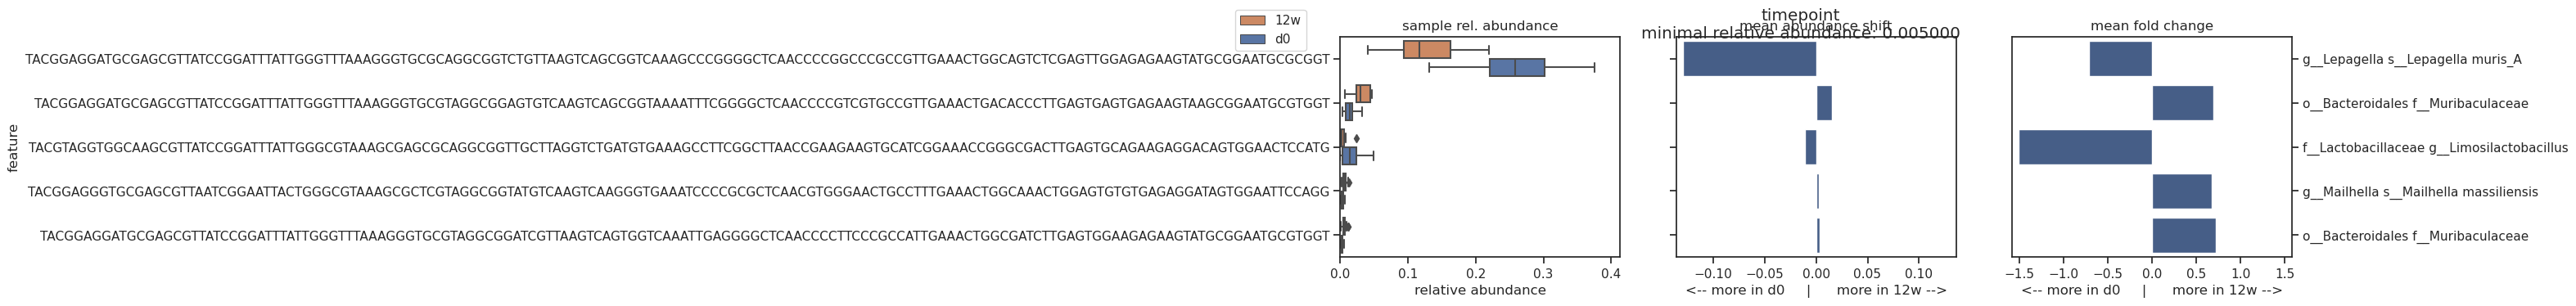

In [46]:
pandas2biom('%s/tmp_dsfrd.biom' % prj_data['paths']['tmp_workdir'], res_feces['counts_plantsremoved'])
meta = prj_data['metadata'][(prj_data['metadata']['bodysite'] == 'feces') & (prj_data['metadata']['condition'] == 'control')].copy()
meta.to_csv('%s/tmp_dsfdr.tsv' % prj_data['paths']['tmp_workdir'], sep="\t", index=True)

dsFDR_experiment = ca.read_amplicon('%s/tmp_dsfrd.biom' % prj_data['paths']['tmp_workdir'], 
                                    '%s/tmp_dsfdr.tsv' % prj_data['paths']['tmp_workdir'], min_reads=0, normalize=10000)

field = 'timepoint'  # the metadata column that groups all samples into two conditions
res_dsFDR_genotype = find_diff_taxa(dsFDR_experiment, meta, [field],
                                    # random_seed=43  # hard code a random seed for reproducible results
                                   )

if len(res_dsFDR_genotype) > 0:
    p = plot_diff_taxa(res_feces['counts_plantsremoved'],
                       meta[field], res_dsFDR_genotype,
                       min_mean_abundance=0.005,
                       #colors_boxplot={'B6J': 'blue', 'C': 'green'}, 
                       #color_barplot='gray'
                       taxonomy=res_feces['taxonomy']['RDP']['results']['Taxon']
                      )

In [47]:
p[1]

12w        d0
feature                                                               
TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGC...  0.005657  0.002574
TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGC...  0.030291  0.014654
TACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCTC...  0.006118  0.003124
TACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGAGC...  0.004055  0.015142
TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGC...  0.126057  0.255504

In [48]:
list(set(prj_data['metadata'][(prj_data['metadata']['bodysite'] == 'feces') & 
                                 (prj_data['metadata']['condition'] == 'control')].index) & \
        set(res_feces['rarefaction']['results'].columns))

['15900.s1.S1',
 '15900.s27.S27',
 '15900.s44.S44',
 '15900.s2.S2',
 '15900.s59.S59',
 '15900.s41.S41',
 '15900.s40.S40',
 '15900.s8.S8',
 '15900.s55.S55',
 '15900.s37.S37',
 '15900.s45.S45',
 '15900.s57.S57',
 '15900.s56.S56',
 '15900.s24.S24',
 '15900.s42.S42',
 '15900.s22.S22',
 '15900.s3.S3',
 '15900.s4.S4',
 '15900.s60.S60',
 '15900.s20.S20',
 '15900.s39.S39',
 '15900.s21.S21',
 '15900.s26.S26',
 '15900.s38.S38',
 '15900.s9.S9',
 '15900.s23.S23',
 '15900.s6.S6',
 '15900.s7.S7',
 '15900.s61.S61',
 '15900.s5.S5',
 '15900.s25.S25',
 '15900.s63.S63',
 '15900.s58.S58',
 '15900.s19.S19',
 '15900.s62.S62',
 '15900.s43.S43']

In [49]:
x = res_feces['rarefaction']['results'].loc[:, list(
        set(prj_data['metadata'][(prj_data['metadata']['bodysite'] == 'feces') & 
                                 (prj_data['metadata']['condition'] == 'control')].index) & \
        set(res_feces['rarefaction']['results'].columns))]
x = x[x.sum(axis=1) > 0]
x.to_csv('help_otu.tsv', sep="\t", index_label='sample_name')


'timepoint'  (n=34)
   104 (of  720) taxa different between 'd0' (n=18) vs. '12w' (n=16)



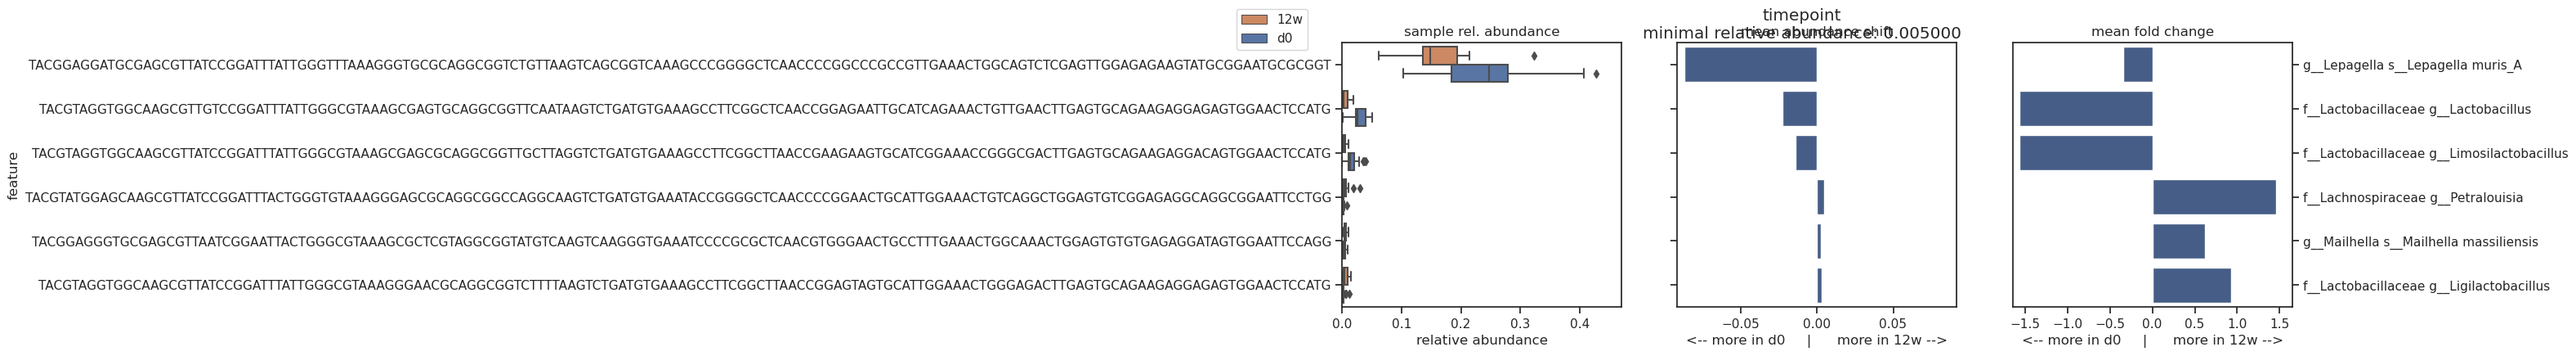

In [50]:
pandas2biom('%s/tmp_dsfrd.biom' % prj_data['paths']['tmp_workdir'], res_feces['counts_plantsremoved'])
meta = prj_data['metadata'][(prj_data['metadata']['bodysite'] == 'feces') & (prj_data['metadata']['condition'] == 'TCDD')].copy()
meta.to_csv('%s/tmp_dsfdr.tsv' % prj_data['paths']['tmp_workdir'], sep="\t", index=True)

dsFDR_experiment = ca.read_amplicon('%s/tmp_dsfrd.biom' % prj_data['paths']['tmp_workdir'], 
                                    '%s/tmp_dsfdr.tsv' % prj_data['paths']['tmp_workdir'], min_reads=0, normalize=10000)

field = 'timepoint'  # the metadata column that groups all samples into two conditions
res_dsFDR_genotype = find_diff_taxa(dsFDR_experiment, meta, [field],
                                    # random_seed=43  # hard code a random seed for reproducible results
                                   )

if len(res_dsFDR_genotype) > 0:
    p = plot_diff_taxa(res_feces['counts_plantsremoved'],
                       meta[field], res_dsFDR_genotype,
                       min_mean_abundance=0.005,
                       #colors_boxplot={'B6J': 'blue', 'C': 'green'}, 
                       #color_barplot='gray'
                       taxonomy=res_feces['taxonomy']['RDP']['results']['Taxon']
                      )

'timepoint'  (n=17)
     0 (of  720) taxa different between 'd0' (n=9) vs. '12w' (n=8)

'timepoint'  (n=18)
    16 (of  720) taxa different between '12w' (n=9) vs. 'd0' (n=9)

'timepoint'  (n=17)
    49 (of  720) taxa different between 'd0' (n=9) vs. '12w' (n=8)

'timepoint'  (n=18)
    14 (of  720) taxa different between 'd0' (n=9) vs. '12w' (n=9)



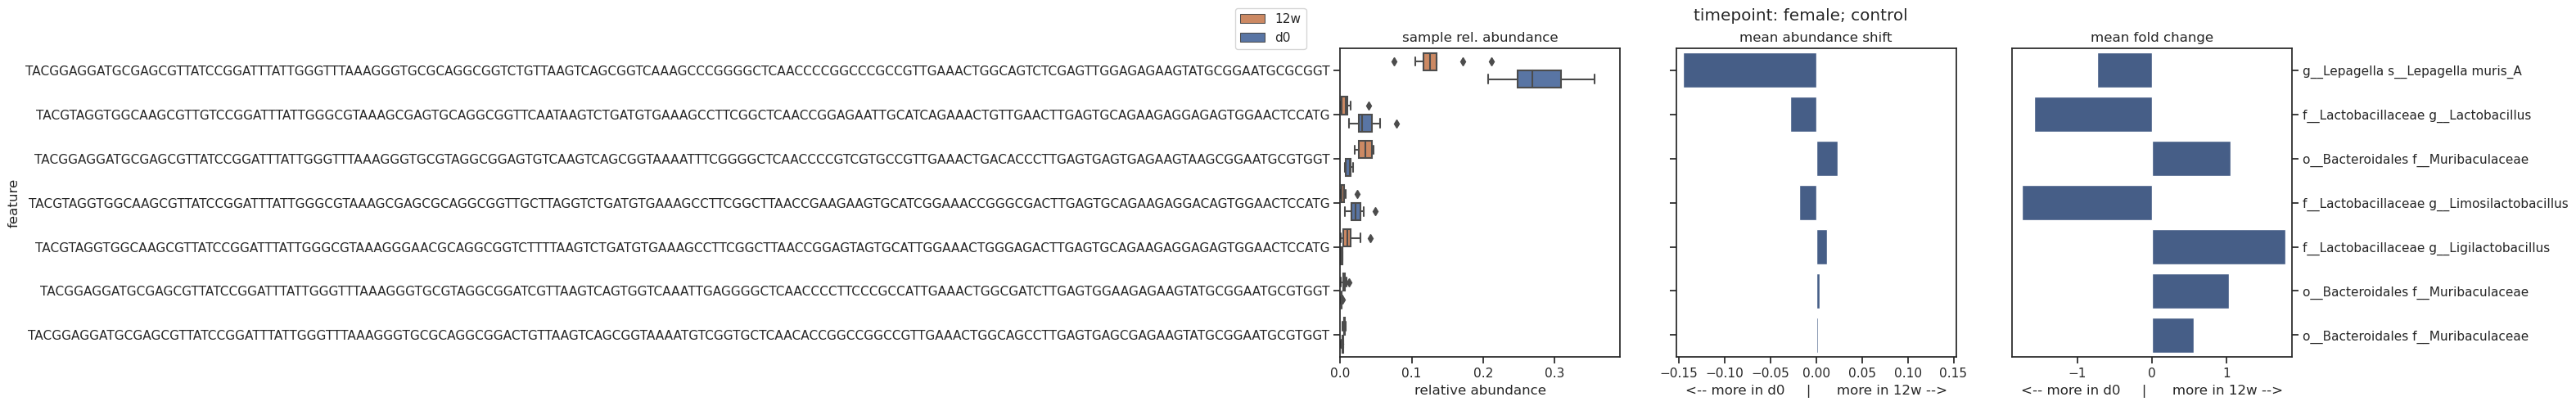

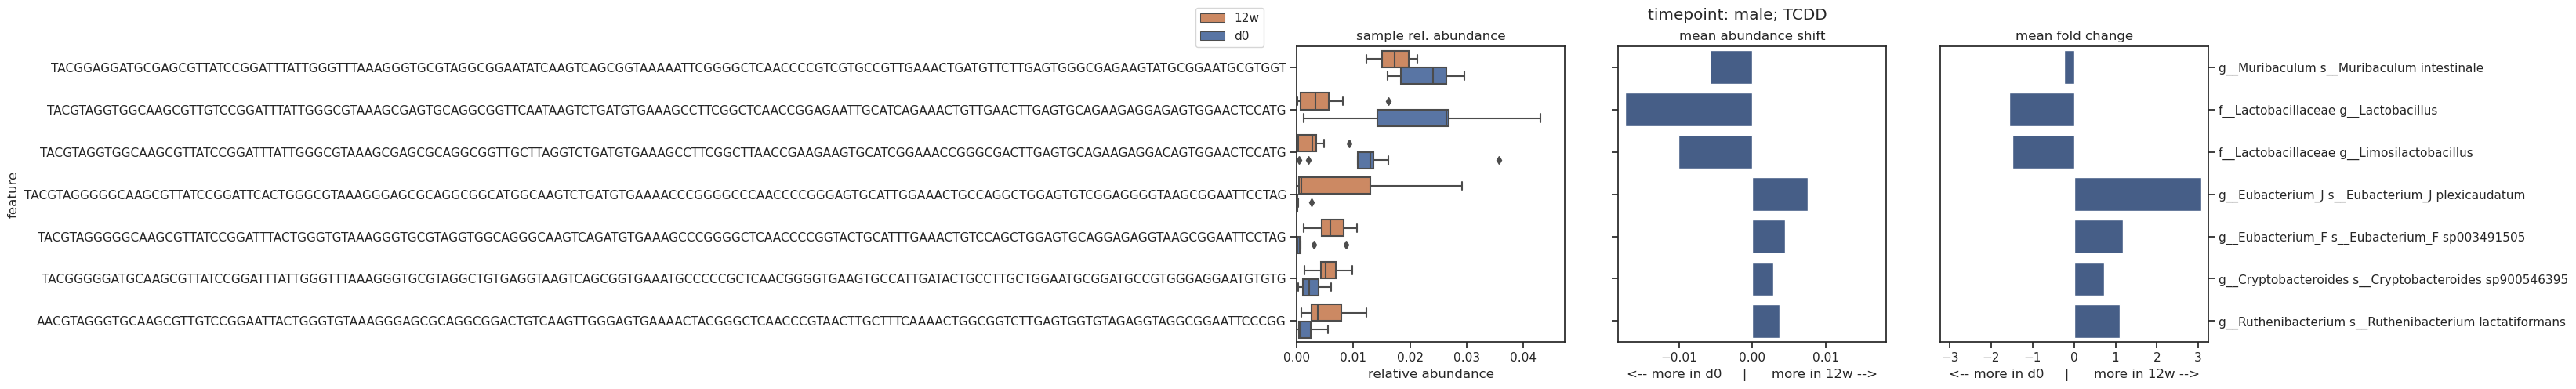

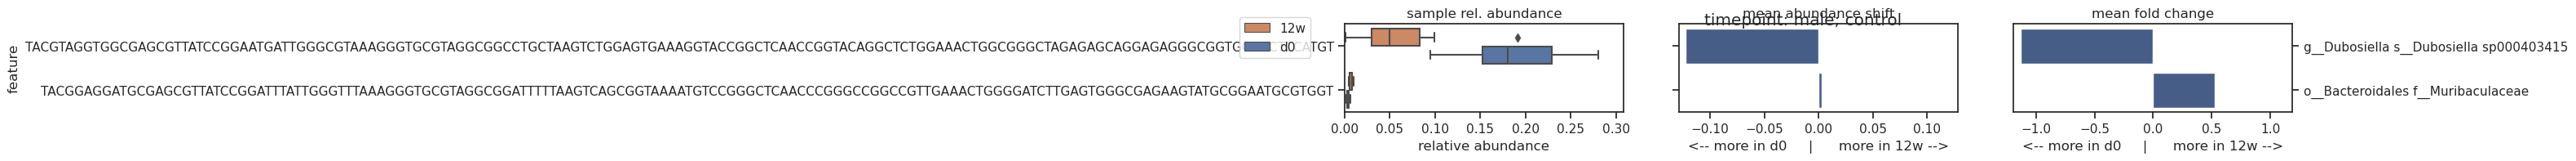

In [51]:
pandas2biom('%s/tmp_dsfrd.biom' % prj_data['paths']['tmp_workdir'], res_feces['counts_plantsremoved'])
meta = prj_data['metadata'][(prj_data['metadata']['bodysite'] == 'feces')].copy()
for (sex, condition), g in meta.groupby(['sex', 'condition']):
    meta.to_csv('%s/tmp_dsfdr_%s_%s.tsv' % (prj_data['paths']['tmp_workdir'], sex, condition), sep="\t", index=True)
    
    dsFDR_experiment = ca.read_amplicon('%s/tmp_dsfrd.biom' % prj_data['paths']['tmp_workdir'], 
                                        '%s/tmp_dsfdr_%s_%s.tsv' % (prj_data['paths']['tmp_workdir'], sex, condition), min_reads=0, normalize=10000)
    
    field = 'timepoint'  # the metadata column that groups all samples into two conditions
    res_dsFDR_genotype = find_diff_taxa(dsFDR_experiment, g, [field],
                                        # random_seed=43  # hard code a random seed for reproducible results
                                       )
    
    if len(res_dsFDR_genotype) > 0:
        p = plot_diff_taxa(res_feces['counts_plantsremoved'],
                           g[field], res_dsFDR_genotype,
                           min_mean_abundance=0.005,
                           #colors_boxplot={'B6J': 'blue', 'C': 'green'}, 
                           #color_barplot='gray'
                           taxonomy=res_feces['taxonomy']['RDP']['results']['Taxon']
                          )
        p[0].suptitle('%s: %s; %s' % (field, sex, condition))
    #break

use 370 of 1930 ASVs


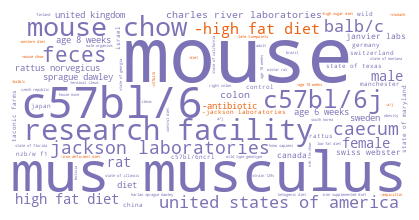

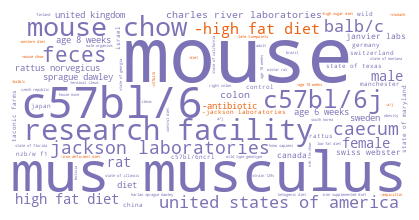

In [52]:
dbbact_wordcloud(biom2pandas('FromQiita/214725_reference-hit.biom'))['figure']